# Lab 8 Search Algorithm: Snake Game

In this notebook, we will be applying the seven search strategies covered in Module 3 to our problem of choice: Snake Game. Our game consists of a snake navigating a 4 x 4 grid to consume food items, and we will be displaying **each frame for every movement steps as individual figures** to show how the snake navigates the map to reach the food. We will also display the game such that the snake will eat the food first before growing.

However, our game is currently modified such that each time the snake eats a food and grows, the snake's body after growth acts as a **static obstacle that is factored into the path calculation** to the newly spawned food. As such, for situation whereby the food is spawned at an area that is blocked off by the snake's body, the snake will not be able to find a path to this food, triggering the **Game Over condition**.


## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import queue
from random import randint

## Environment Set-up & Visualisation

We will be using a 2D numpy array to represent our playing field. We are using the PiYG colour scheme for visualisation. <br>See more: https://loading.io/color/feature/PiYG-4/

**1.0 (Dark Green)**: Wall (will be avoided during path calculation) <br>
**0.75 (Light Green)**: Snake's head <br>
**0.6 (Pale Green)**: Snake's body <br>
**0.25 (Pink)**: Spawned Feed <br>
**0.0 (Red)**: Unoccupied grid position (legal to move into)

In [2]:
# Setting up the 4 x 4 grid, the snake and feed will be updated to the grid in the subsequent functions
newGrid = [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

newGrid = np.array(newGrid)


Two functions are used to visualise the environment.

showGrid is called only **when the snake eats the food**, whereas showGridProblem is called **whenever the snake moves and has yet to reach the food.**

In [3]:
def showGrid(grid):
    ''' Display the 4 x 4 grid with the moving snake
        This function is called when the snake eats the food
        Input : 2D NumPy array representing the grid
        Output : Heatmap grid with snake
    '''
    grid = grid.copy()
    (height, width) = grid.shape
    grid = grid * 255                # just to match standard pixel values (0 to 255)
    
    f = plt.figure(figsize = (width,height))
    heatmap(grid, vmin = 0, vmax = 255, cmap = "PiYG", cbar = False)
    
    
    
def showGridProblem(grid, feed):
    ''' Display the 4 x 4 grid with feed and the moving snake
        Input : 2D NumPy array representing the grid
        Input : 2D coordinate of the spawned "feed"    
        Output : Heatmap grid with feed and snake
    '''
    
    grid = grid.copy()
    (height, width) = grid.shape
    
    # Pink block represents the spawned feed
    grid[feed[0], feed[1]] = 0.25
    grid = grid.copy() * 255
     
    f = plt.figure(figsize = (width,height))
    heatmap(grid, vmin = 0, vmax = 255, cmap = "PiYG", cbar = False)

updateGrid is called **whenever the grid changes** due to movement of snake in the subsequent function

In [4]:
def updateGrid(grid, snakeArr):
    ''' Updates the 4 x 4 grid with the new position of the snake
        Input : 2D NumPy array representing the grid
        Input : A list of coordinates occupied by the snake, with the snake head as the first element of the list 
        Output : Returns the updated grid
    '''
    grid = grid.copy()
    for i in range(len(snakeArr)):
        x,y = snakeArr[i][0], snakeArr[i][1]
        if i == 0: # First element: Snake's head
            grid[x,y] = 0.75
        else: # Remaining elements: Snake's body
            grid[x,y] = 0.6
    return grid
    

showGridPath is a wrapper function for **path visualisation**, calling the showGrid and showGridProblem functions as required as the snake traverse through the path, to show how the snake moves step by step.

In [74]:
# Helper function for Path Visualisation

def showGridPath(grid, path, goal, snakeArr):
    ''' Given a path, display how the snake moves to the feed.  
        Input : 2D NumPy array representing the grid
        Input : A list of coordinates representing the path taken by the snake to reach the feed
        Input : The coordinates of the feed location (Goal)
        Input : A list of coordinates occupied by the snake, with the snake head as the first element of the list 
        Output : Heatmap grid of each step of path until the snake eats the food
    '''
    grid = grid 
    for i in range(len(path)):
        node = path[i]
        if i != 0:
            
            tail = snakeArr[-1]
            snakeArr = snakeArr[:-1]
            snakeArr.insert(0, node)
            grid[tail[0], tail[1]] = 0
            grid[prevNode[0], prevNode[1]] = 0.6 
            grid[node[0], node[1]] = 0.75
        
            if i == len(path) - 1:
                showGrid(grid)
            else:
                showGridProblem(grid, goal)
        prevNode = node
    


spawnFeed generates the **coordinates of the newly spawned food.**

In [6]:
def spawnFeed(grid):
    ''' Determines a new random feed location
        Input : 2D NumPy array representing the grid
        Output : Returns the coordinates of newly spawned food
    '''
    location = (randint(1,4), randint(1,4))
    while grid[location[0], location[1]] in (0.75, 1, 0.6): # Food cannot spawn on snake or the wall
        location = (randint(1,4), randint(1,4))
    
    return location

Grid class is defined for us to **represent our environment states** so that searching can occur. <br>
grid_to_graph function will convert our grid into its **corresponding graphical represention of the environmental states.**

In [7]:
# Create a Graph class
class GridGraph(object):
    ''' Class to represent a Graph
        Construction : Using Edges
    '''
    def __init__(self):
        self.edges = {}
    
    def all_edges(self):
        return self.edges
    
    def neighbors(self, node):
        return self.edges[node]    

In [36]:
def grid_to_graph(grid):
    ''' Converts a 2D binary maze to corresponding graph
        Input : 2D NumPy array with 0 and 1 as elements
        Output : MazeGraph corresponding to input maze
    '''
    gridGraph = GridGraph()
    (height, width) = grid.shape
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            
            # Only consider blank cells and Snake's head as nodes
            if grid[i,j] in (0, 0.75):
                
                neighbors = []
                
                # Adjacent cell : Top
                if (i > 1) and grid[i-1,j] == 0:
                    neighbors.append(((i-1,j), 1))
                    
                # Adjacent cell : Left                
                if (j > 1) and grid[i,j-1] == 0:
                    neighbors.append(((i,j-1), 1))
                    
                # Adjacent cell : Bottom                    
                if (i < height - 2) and grid[i+1,j] == 0:
                    neighbors.append(((i+1,j), 1))

                # Adjacent cell : Right                    
                if (j < width - 2) and grid[i,j+1] == 0:
                    neighbors.append(((i,j+1), 1))

                # Insert edges in the graph
                #if len(neighbors) > 0:
                gridGraph.edges[(i,j)] = neighbors

    return gridGraph

In [71]:
def grid_to_graph(grid, snakeArr):
    ''' Converts a 2D binary maze to corresponding graph
        Input : 2D NumPy array with 0 and 1 as elements
        Output : MazeGraph corresponding to input maze
    '''
    gridGraph = GridGraph()
    (height, width) = grid.shape
    
    head = snakeArr[0]
    legalMoves = []
    
    for i in range(1, height-1):
        for j in range(1, width-1):

            distFromHead = heuristic(head, (i,j))
            neighbors = []

            # Adjacent cell : Top
            if (i > 1) and (grid[i-1,j] == 0 or (i-1,j) in snakeArr[-distFromHead-1:]):
                if not (len(snakeArr) > 1 and (i, j) == head and (i-1,j) == snakeArr[1]):
                    neighbors.append(((i-1,j), 1))

            # Adjacent cell : Left                
            if (j > 1) and (grid[i,j-1] == 0 or (i,j-1) in snakeArr[-distFromHead-1:]):
                if not (len(snakeArr) > 1 and (i, j) == head and (i,j-1) == snakeArr[1]):
                    neighbors.append(((i,j-1), 1))

            # Adjacent cell : Bottom                    
            if (i < height - 2) and (grid[i+1,j] == 0 or (i+1,j) in snakeArr[-distFromHead-1:]):
                if not (len(snakeArr) > 1 and (i, j) == head and (i+1,j) == snakeArr[1]):
                    neighbors.append(((i+1,j), 1))

            # Adjacent cell : Right                    
            if (j < width - 2) and (grid[i,j+1] == 0 or (i,j+1) in snakeArr[-distFromHead-1:]):
                if not (len(snakeArr) > 1 and (i, j) == head and (i,j+1) == snakeArr[1]):
                    neighbors.append(((i,j+1), 1))

            # Insert edges in the graph
            #if len(neighbors) > 0:
            gridGraph.edges[(i,j)] = neighbors
    
                
    return gridGraph

Snake class is defined to **keep track of internal state of the snake**, including its length and the coordinates occupied (with the first corresponding to its head).

In [9]:
class Snake:
    def __init__(self):
        self._length = 1
        self._posArr = [(3,3)]
        
    def grow(self):
        self._length += 1
    
    def updatePos(self, path):
        path.reverse()
        stepCount = len(path)
        snakeLength = self._length
        if snakeLength > len(path):
            self._posArr = path + self._posArr[1:snakeLength-stepCount+1]
        else:
            self._posArr = path[:snakeLength]
    
    def getPos(self):
        return self._posArr
    
    def getLength(self):
        return self._length

## Search Strategies

In [10]:
# Breadth-First-Search (BFS) with FIFO Queue

def breadth_first_search(gridGraph, start, goal):
    ''' Function to perform BFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.Queue()    # FIFO Queue for Frontier
    
    # initialization
    frontier.put(start)         # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in gridGraph.neighbors(currentNode):
           
            # ignore if it has already been explored, helps to ensure we get optimal soln
            if nextNode not in explored:
                
                # put new node in frontier
                frontier.put(nextNode)
                
                # assign current node as parent
                explored[nextNode] = currentNode
    
    return explored, processed

In [11]:
def depth_first_search(gridGraph, start, goal):
    ''' Function to perform DFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.LifoQueue()      # LIFO Queue for Frontier
    
    # initialization
    frontier.put(start)         # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in gridGraph.neighbors(currentNode):
            
            # ignore if it has already been explored
            if nextNode not in explored:
                
                # put new node in frontier
                frontier.put(nextNode)
                
                # assign current node as parent
                explored[nextNode] = currentNode
    
    return explored, processed

In [12]:
def uniform_cost_search(gridGraph, start, goal):
    ''' Function to perform UCS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.PriorityQueue()      # Priority Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()[1]
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in gridGraph.neighbors(currentNode):
            
            # compute the new cost for the node based on the current node
            newcost = pathcost[currentNode] + weight

            # consider if not yet explored or if the new cost is lower 
            if (nextNode not in explored) or (newcost < pathcost[nextNode]):

                # set priority as newcost 
                priority = newcost
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = newcost
    
    return explored, processed

In [13]:
def depth_limited_search(limit):
    ''' Function to perform DLS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    def search(gridGraph, start, goal):
        frontier = queue.LifoQueue()      # LIFO Queue for Frontier

        # initialization
        frontier.put([start,0])         # Add the start node to frontier
        explored = {}               # Dict of explored nodes {node : parentNode}
        explored[start] = None      # start node has no parent node
        processed = 0               # Count of total nodes processed

        while not frontier.empty():
            # get next node from frontier
            currentNode = frontier.get()
            processed += 1

            # stop when goal is reached
            if currentNode[0] == goal:
                break

            depth = currentNode[1]
            if depth < limit:
                # explore every single neighbor of current node
                for nextNode, weight in gridGraph.neighbors(currentNode[0]):

                    # ignore if it has already been explored
                    if nextNode not in explored:

                        # put new node in frontier
                        frontier.put([nextNode,depth+1])

                        # assign current node as parent
                        explored[nextNode] = currentNode[0]

        return explored, processed
    return search

In [14]:
def iterative_deepening_search():
    ''' Function to perform IDS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    i = 0
    while i!= 16:  #maximum steps for 4x4 grid is 15 units for any point x to y
        yield depth_limited_search(i)
        i += 1

In [15]:
def heuristic(nodeA, nodeB):
    (xA, yA) = nodeA
    (xB, yB) = nodeB
    return abs(xA - xB) + abs(yA - yB)


# Greedy-Search (GS) with Priority Queue

def greedy_search(gridGraph, start, goal):
    ''' Function to perform GS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.PriorityQueue()      # Priority Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed
                                # -- 6
                                #    3
                                # -- 3
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()[1]
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in gridGraph.neighbors(currentNode):
            
            # compute the new cost for the node based on the current node
            newcost = pathcost[currentNode] + weight

            # consider if not yet explored
            # cost from start not considered
            if (nextNode not in explored):

                # set priority as distance from goal
                priority = heuristic(nextNode, goal)
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = newcost
    
    return explored, processed

In [16]:
def astar_search(gridGraph, start, goal):
    ''' Function to perform A*S to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.PriorityQueue()      # Priority Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()[1]
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in gridGraph.neighbors(currentNode):
            
            # compute the new cost for the node based on the current node
            newcost = pathcost[currentNode] + weight

            # consider if not yet explored or if the new cost is lower 
            if (nextNode not in explored) or (newcost < pathcost[nextNode]):

                # set priority as newcost + distance from goal
                priority = newcost + heuristic(nextNode, goal)
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = newcost
    
    return explored, processed

In [17]:
# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

applySearch is a wrapper function for us to call the respective search methods to see how they fare for our game.

In [78]:
def applySearch(search, searchName):
    def searchGraph(search, prevNodesExplored = None):
        if searchName == "Iterative Deepening Search":
            nodesExplored, nodesProcessed = next(search)(gridGraph, start = head, goal = feed)
        else:
            nodesExplored, nodesProcessed = search(gridGraph, start = head, goal = feed)
        try:  
            path = reconstruct_path(nodesExplored, start = head, goal = feed)
        except KeyError:
            if searchName == "Iterative Deepening Search" and prevNodesExplored != nodesExplored:
                nodesExplored, nodesProcessed, path = searchGraph(search, nodesExplored)
                
            if feed not in nodesExplored:
                print("Game Over!")
                path = None
            '''
            if len(nodesExplored) == 1:
                print("Game Over!")
                path = None
            else:
                
                for curr, prev in nodesExplored.items():
                    if prev == head:
                        arr = snakeArr[:-1]
                        arr.insert(0, curr)
                        testGrid = updateGrid(newGrid, arr)
                        testGridGraph = grid_to_graph(testGrid)
                        nodesExplored, nodesProcessed = search(testGridGraph, start = curr, goal = feed)
                        if feed in nodesExplored:
                            nodesExplored[curr] = head
                            nodesExpressed += 1
                            path = reconstruct_path(nodesExplored, start = head, goal = feed)
                            break
                print("Game Over!")
                path = None
            '''

        finally:
            return nodesExplored, nodesProcessed, path
        
    s1 = Snake()
    while s1.getLength() < 13:
        snakeArr = s1.getPos()
        grid = updateGrid(newGrid, snakeArr)    
        feed = spawnFeed(grid)
        showGridProblem(grid, feed)

        # Convert the maze to a graph
        gridGraph = grid_to_graph(grid, snakeArr)

        # Print the edges with weights
        print(gridGraph.all_edges())

        head = snakeArr[0]

        # Run the BFS algorithm for path finding
        if searchName == "Iterative Deepening Search":
            IDSearch = search() 
            nodesExplored, nodesProcessed, path = searchGraph(IDSearch)
        else:
            nodesExplored, nodesProcessed, path = searchGraph(search)
        
        if not path:
            break
        
        # Basic measures for the algorithm
        print(searchName)
        print()

        totalNodes = np.count_nonzero(grid == 0)
        print("Total nodes in maze :", totalNodes)
        print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
        print("Final path distance :", len(path))
        print()

        # Print the path and show using helper functions
        print("Path through the Maze :", path)
        print("========================")
        showGridPath(grid,path,feed,snakeArr)

        s1.grow()
        s1.updatePos(path)
        
    print("Score: ", s1.getLength())




## Results

{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Breadth-First-Search (BFS)

Total nodes in maze : 15
Total nodes visited : 5  |  33.33 %
Final path distance : 2

Path through the Maze : [(3, 3), (3, 4)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), (

C:\Users\huang\AppData\Local\Temp\ipykernel_29308\3245365467.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize = (width,height))


{(1, 1): [((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((2, 2), 1)], (2, 2): [((1, 2), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((3, 2), 1)], (3, 2): [((2, 2), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Breadth-First-Search (BFS)

Total nodes in maze : 9
Total nodes visited : 3  |  33.33 %
Final path distance : 3

Path through the Maze : [(4, 1), (4, 2), (3, 2)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)],

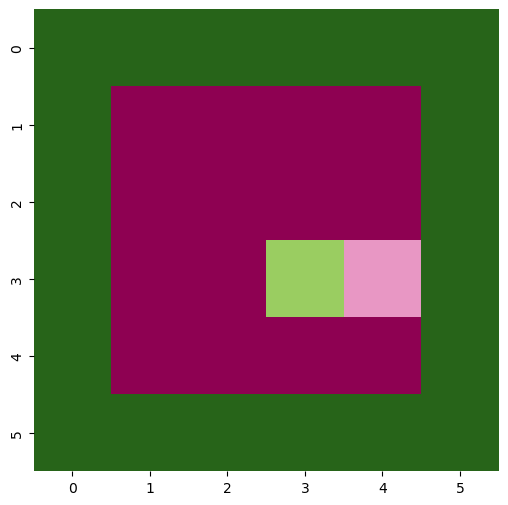

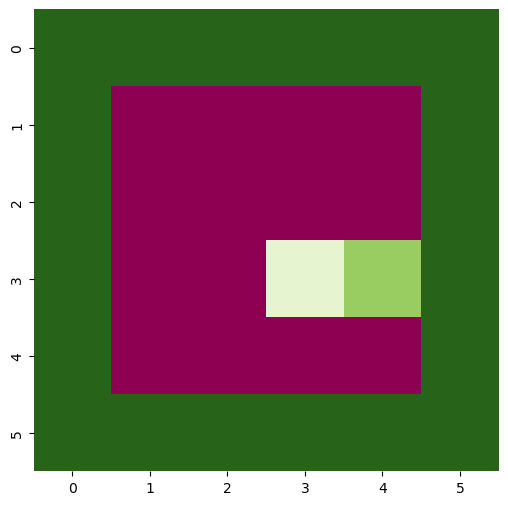

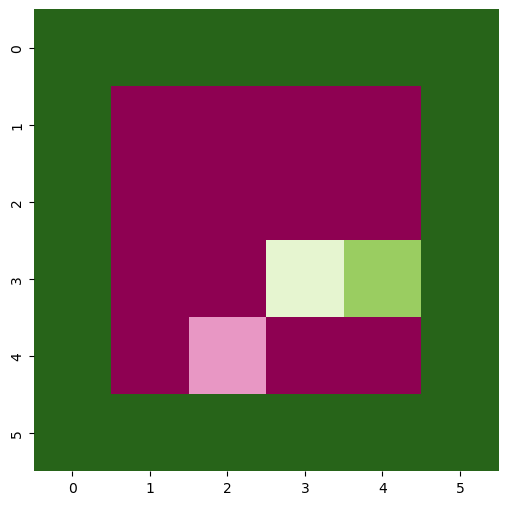

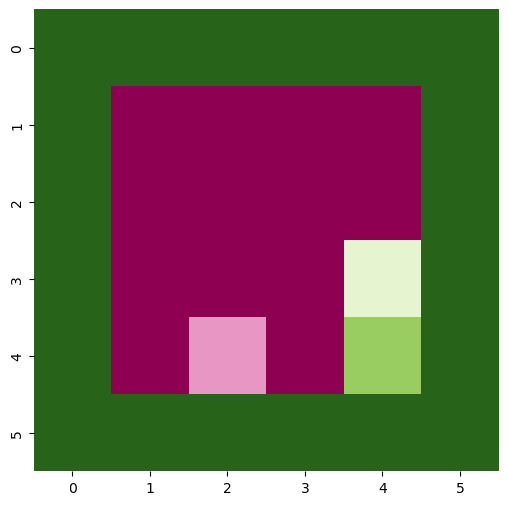

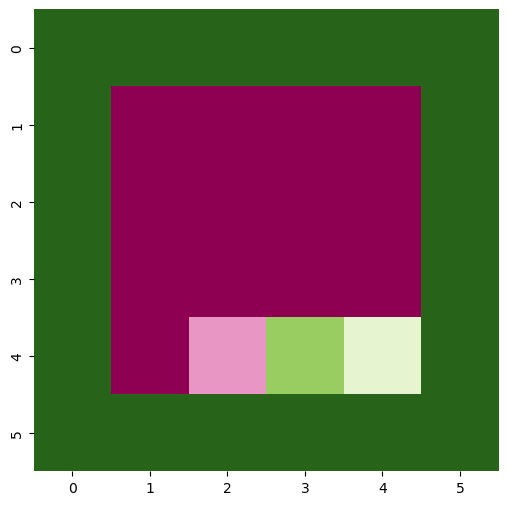

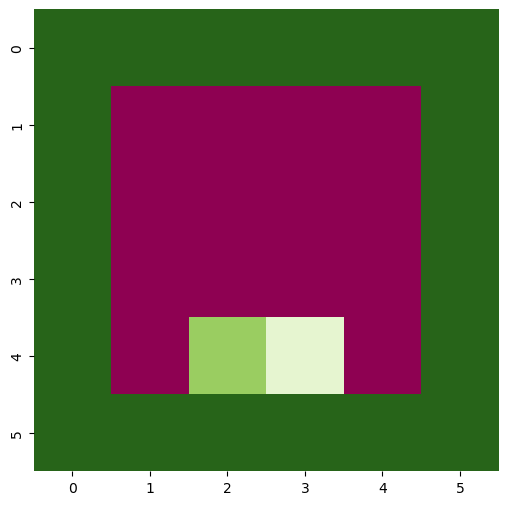

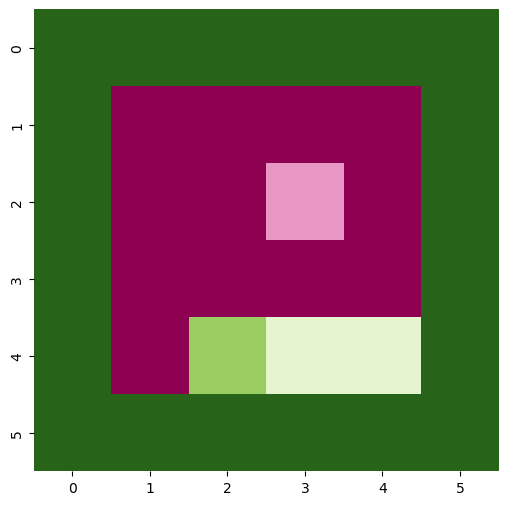

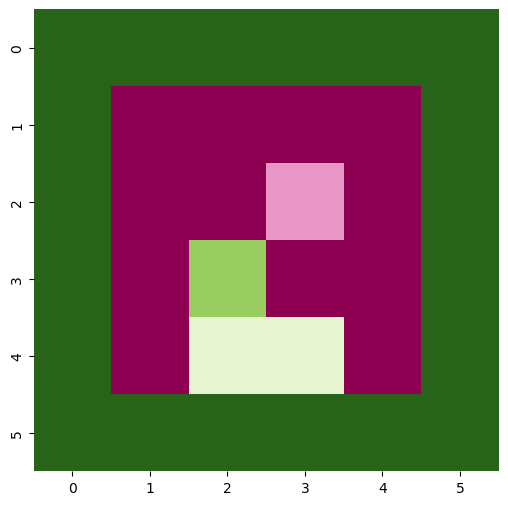

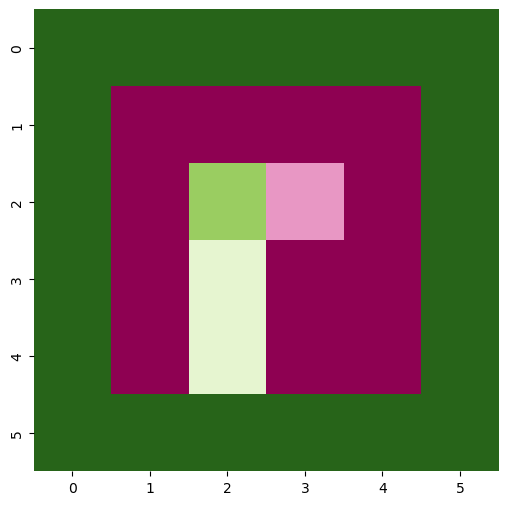

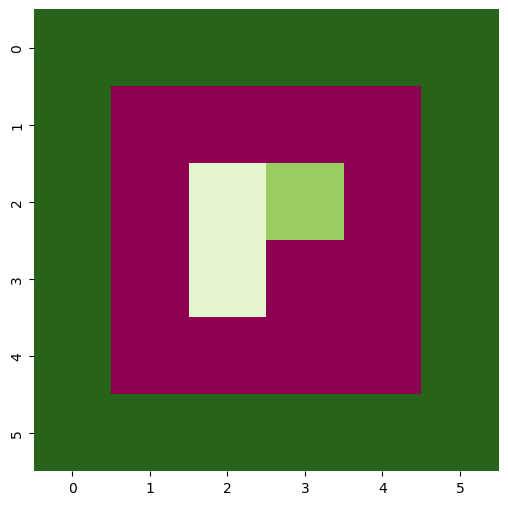

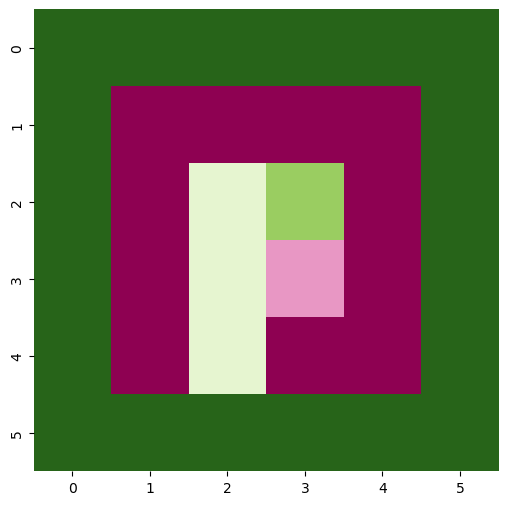

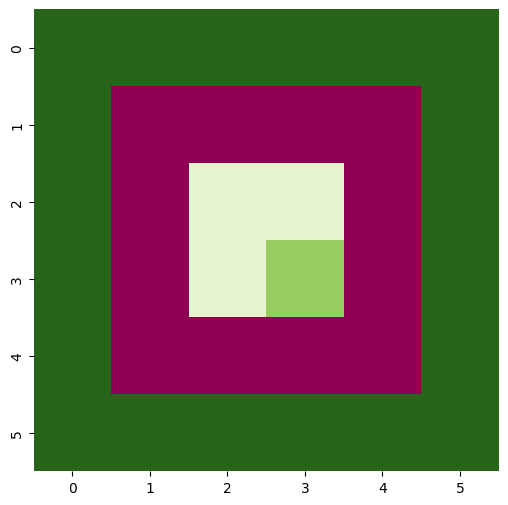

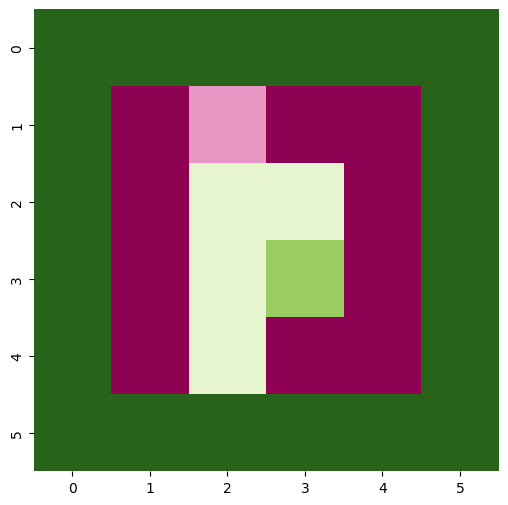

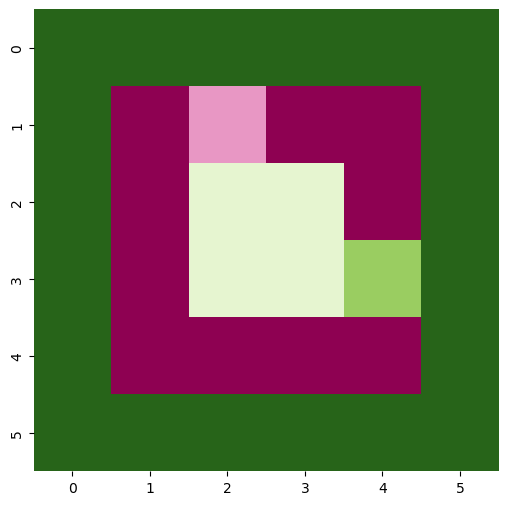

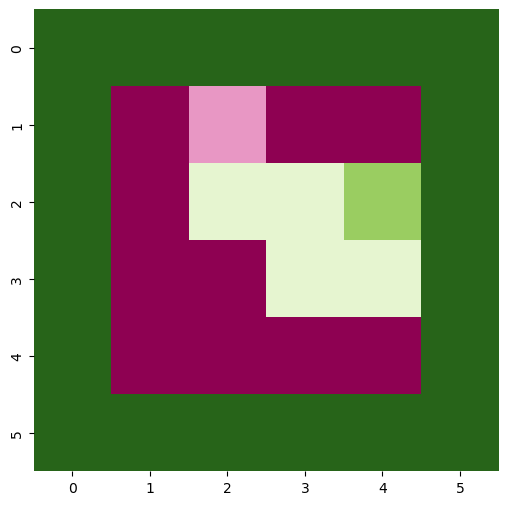

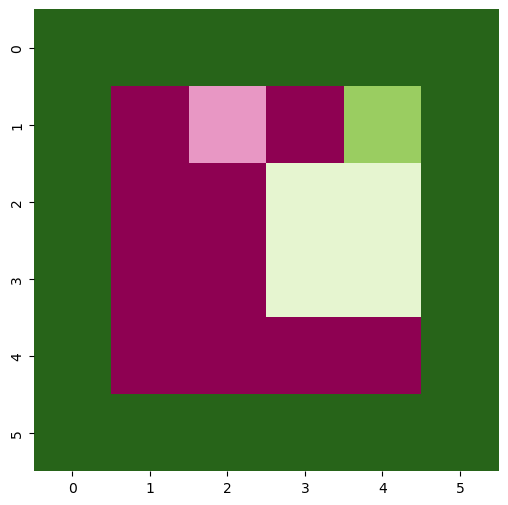

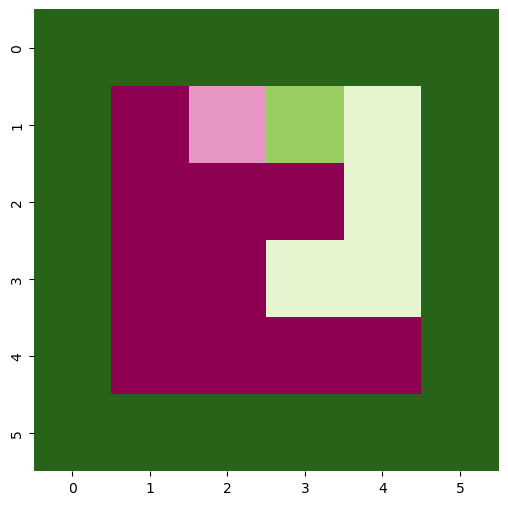

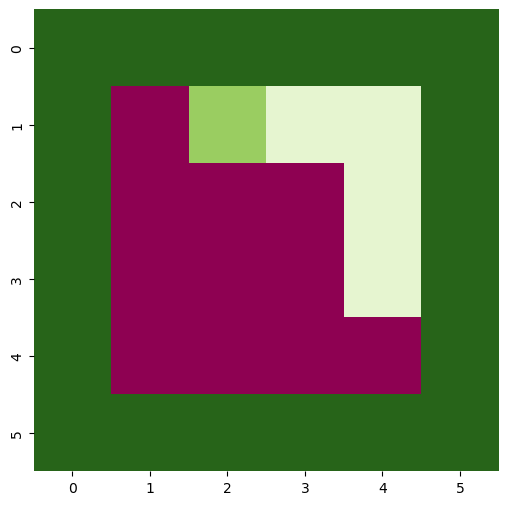

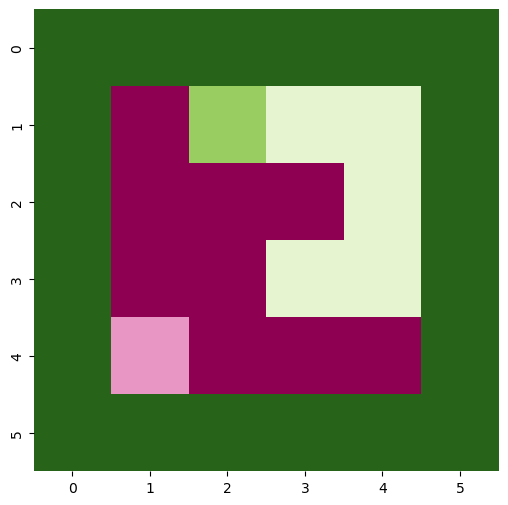

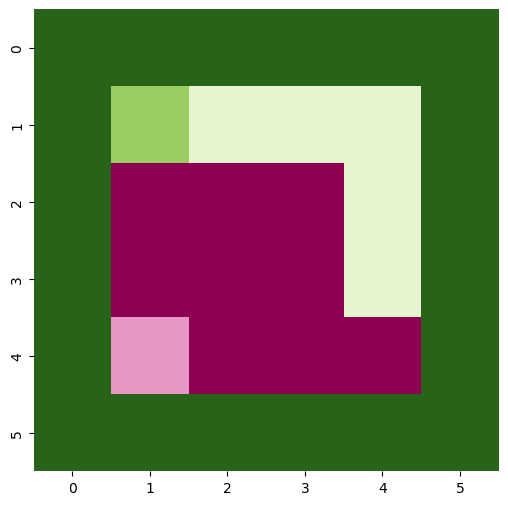

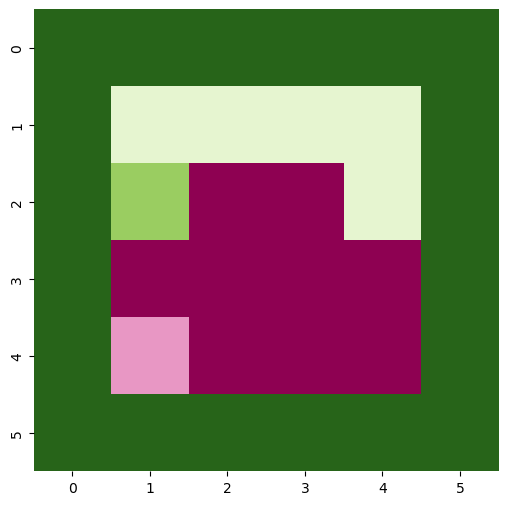

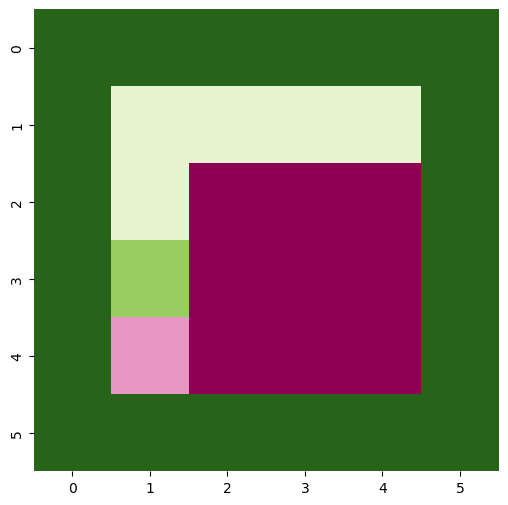

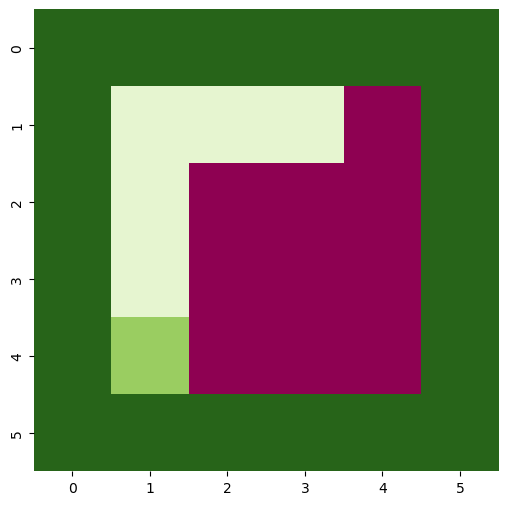

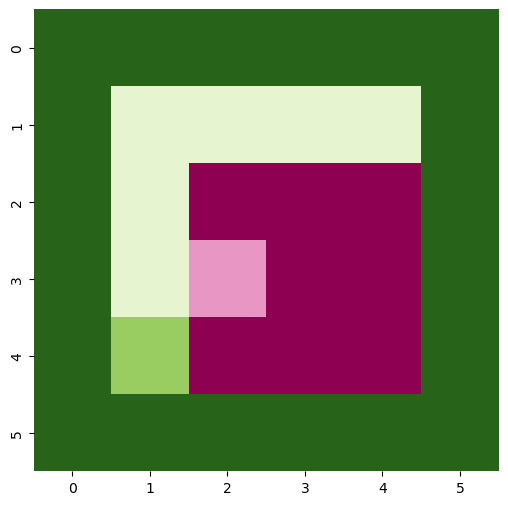

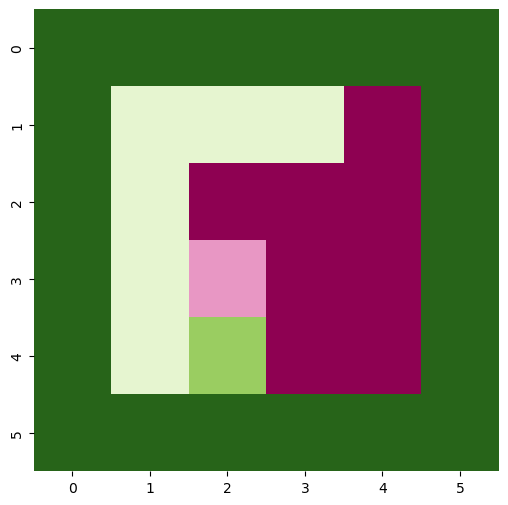

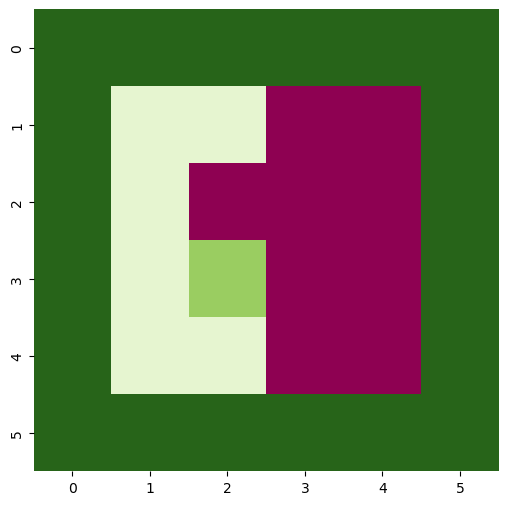

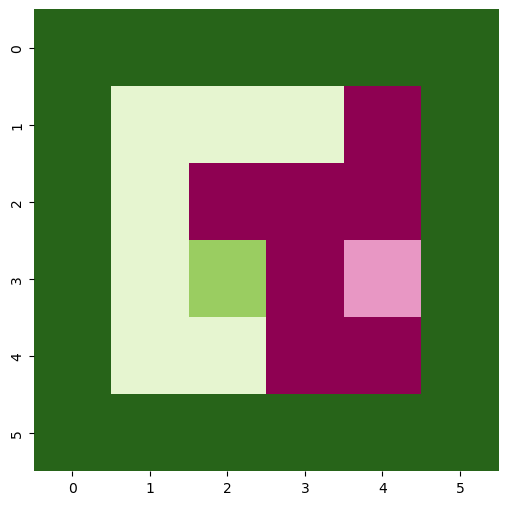

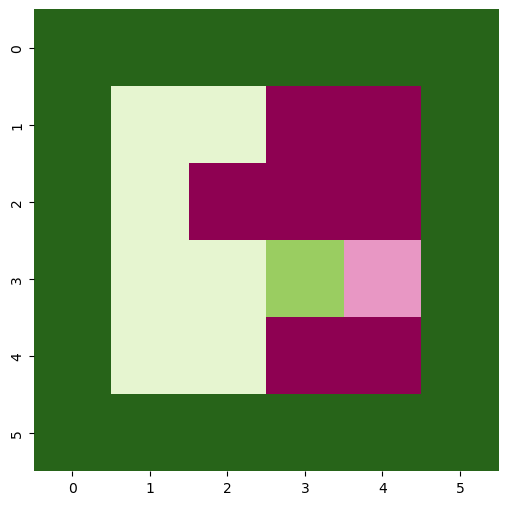

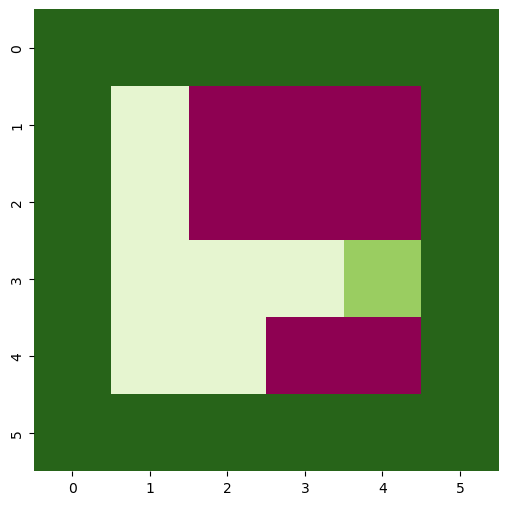

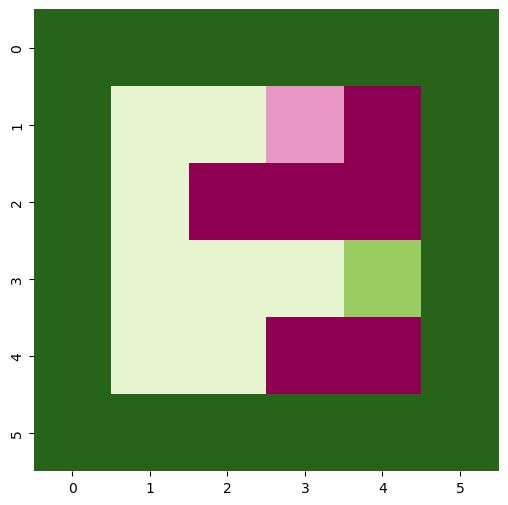

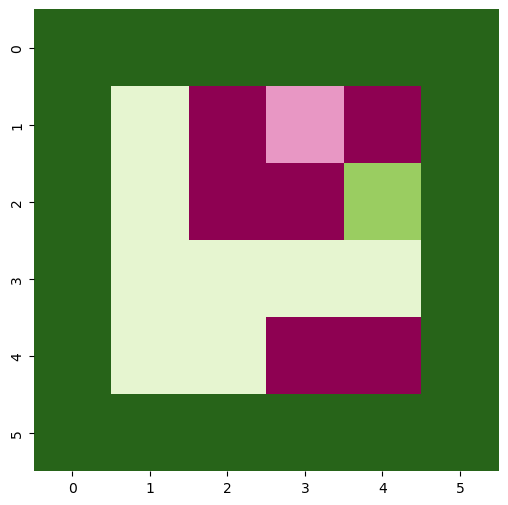

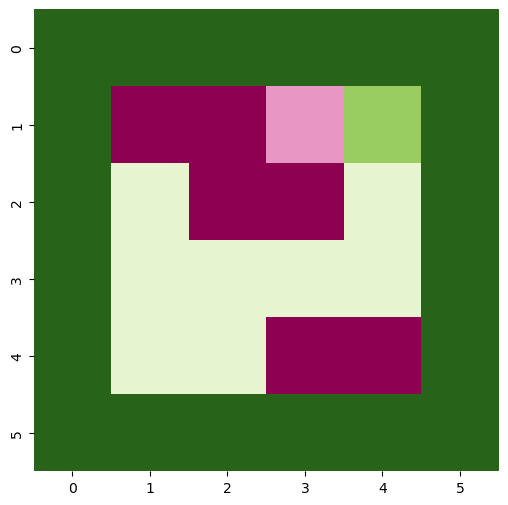

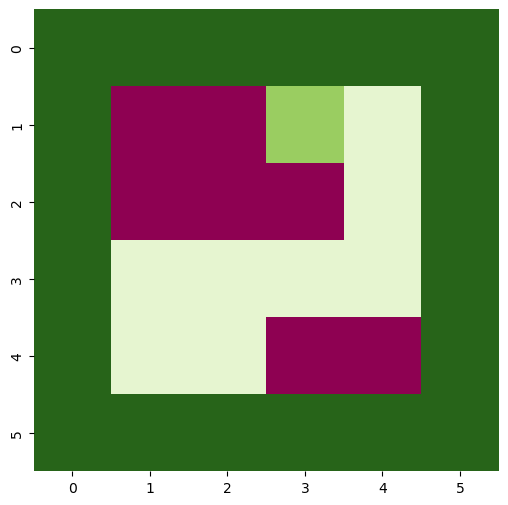

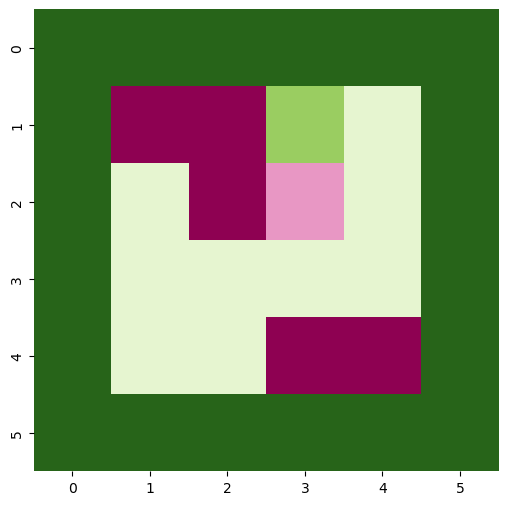

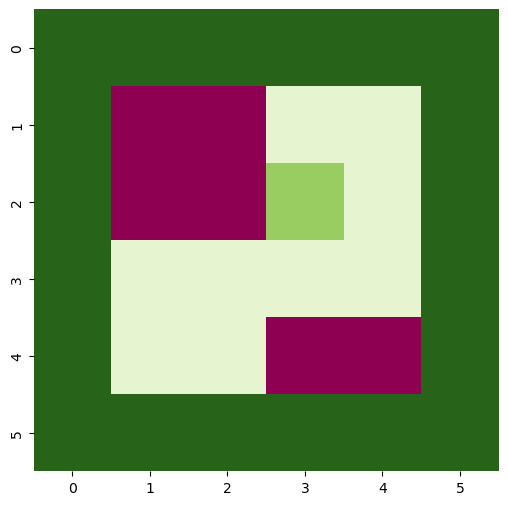

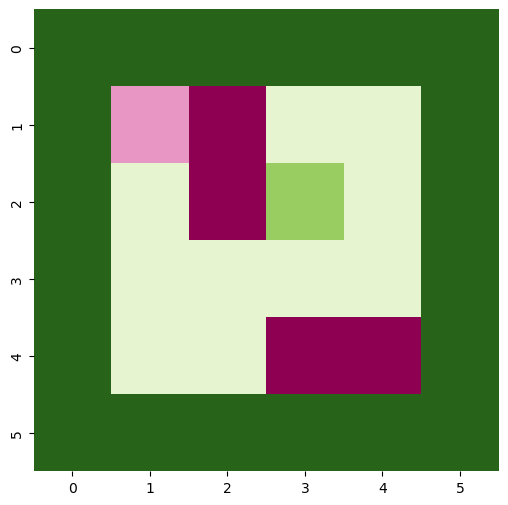

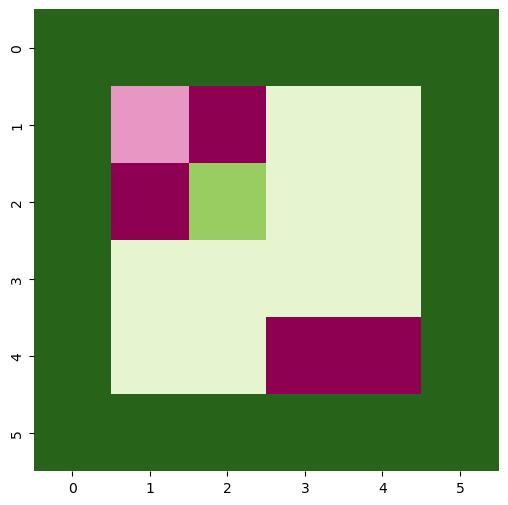

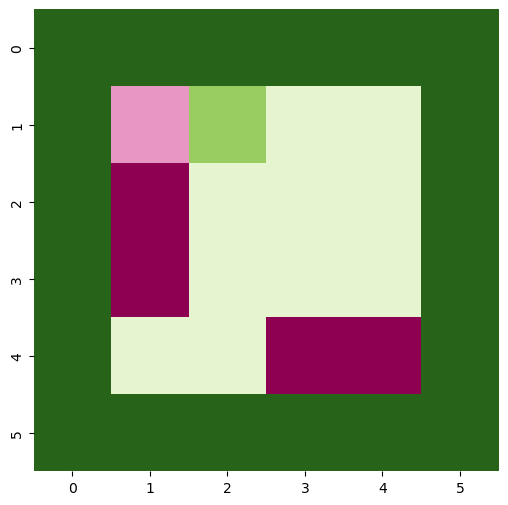

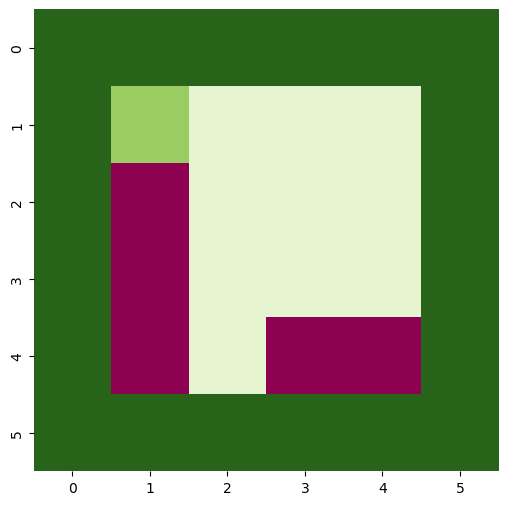

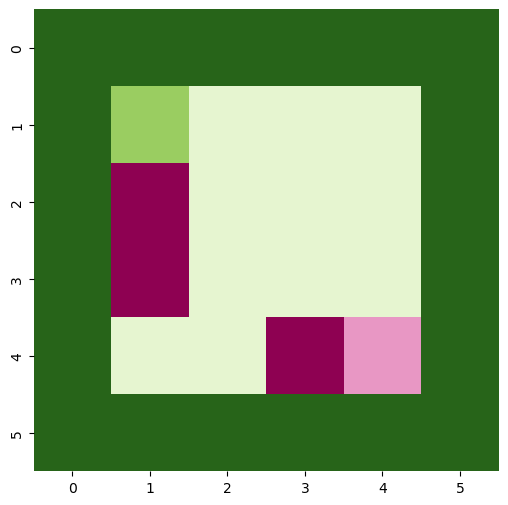

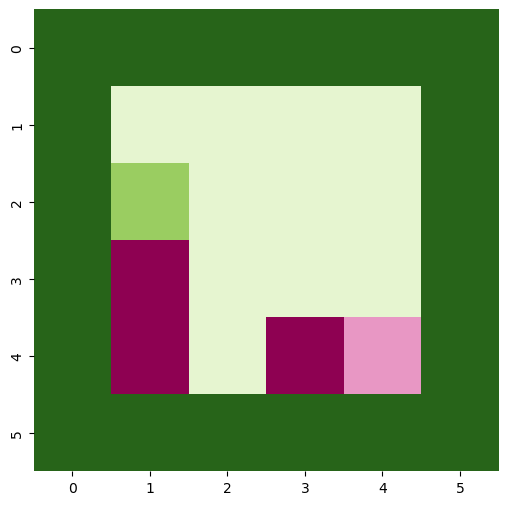

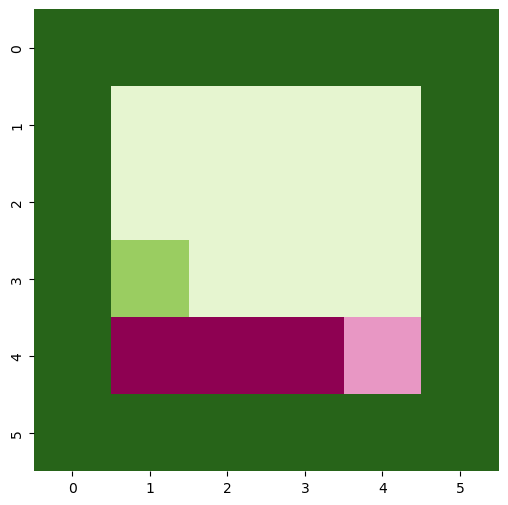

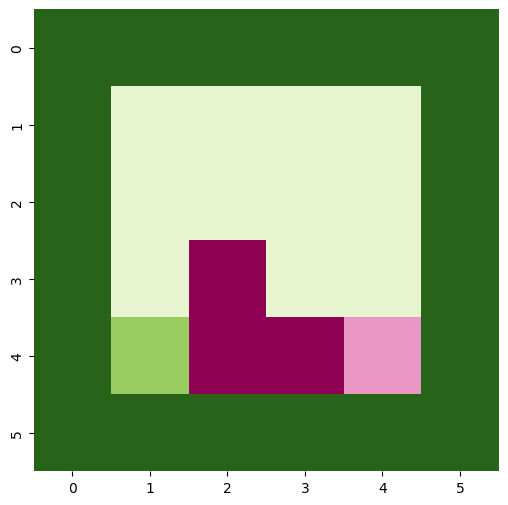

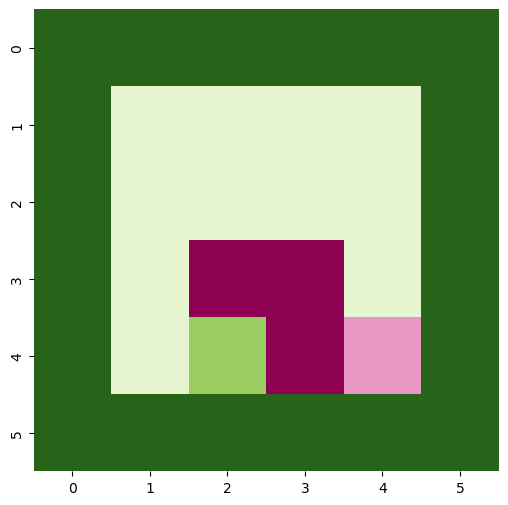

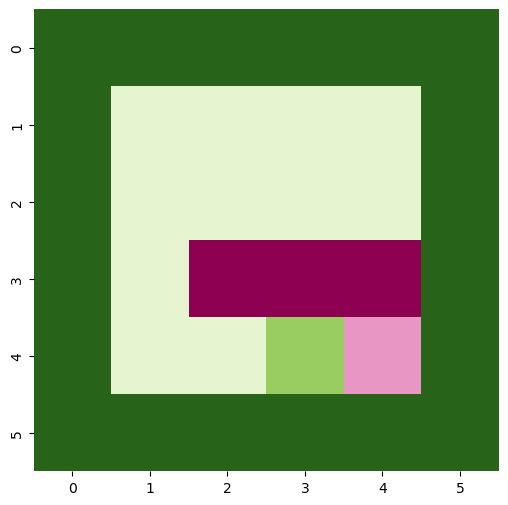

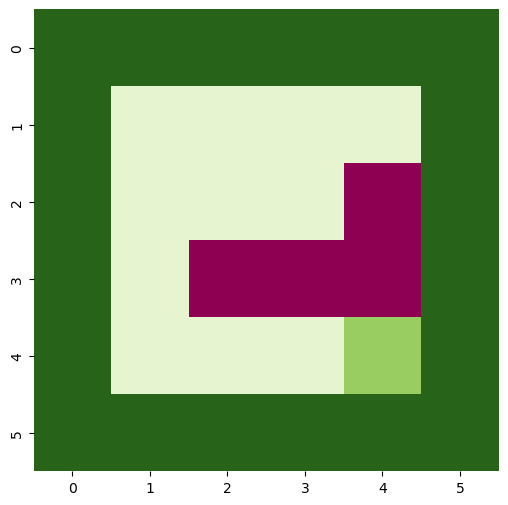

In [81]:
applySearch(breadth_first_search,"Breadth-First-Search (BFS)")

{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Depth-First-Search (DFS)

Total nodes in maze : 15
Total nodes visited : 10  |  66.67 %
Final path distance : 9

Path through the Maze : [(3, 3), (3, 4), (2, 4), (1, 4), (1, 3), (1, 2), (2, 2), (2, 1), (3, 1)]
{(1, 

C:\Users\huang\AppData\Local\Temp\ipykernel_29308\3245365467.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize = (width,height))


{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Depth-First-Search (DFS)

Total nodes in maze : 12
Total nodes visited : 4  |  33.33 %
Final path distance : 4

Path through the Maze : [(3, 1), (3, 2), (3, 3), (3, 4)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1

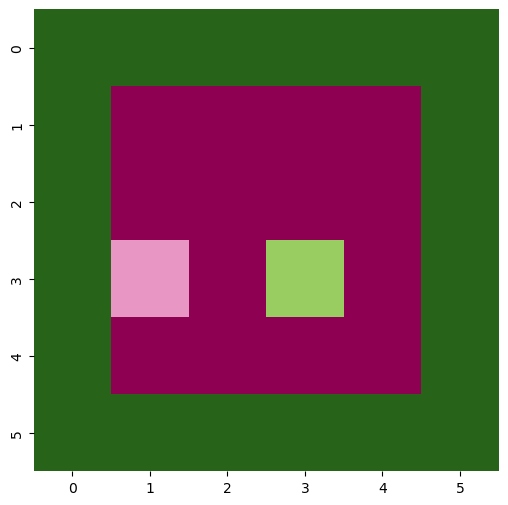

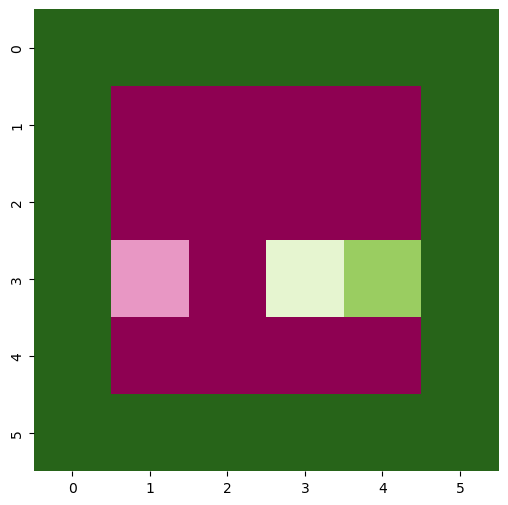

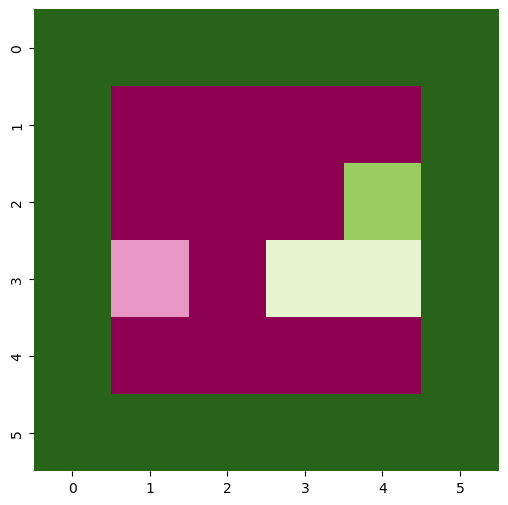

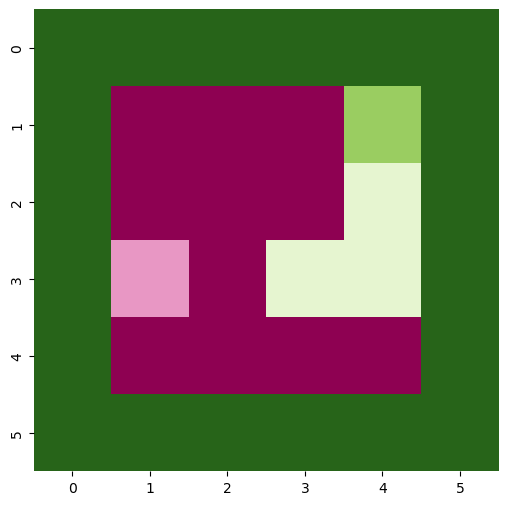

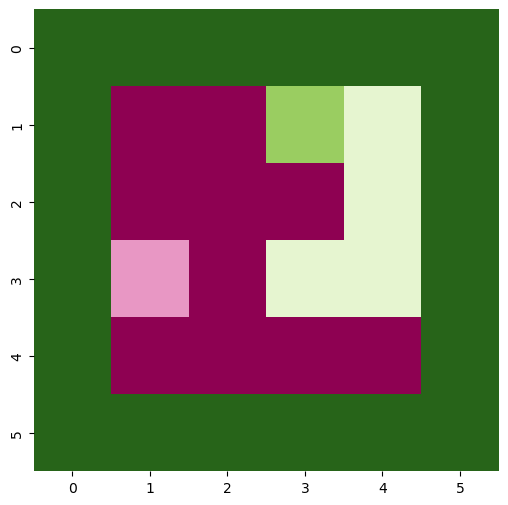

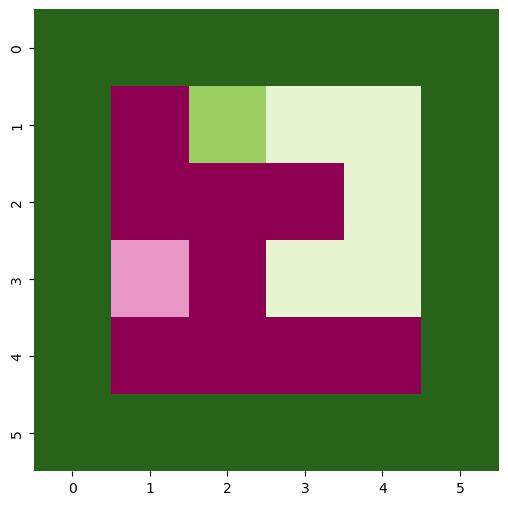

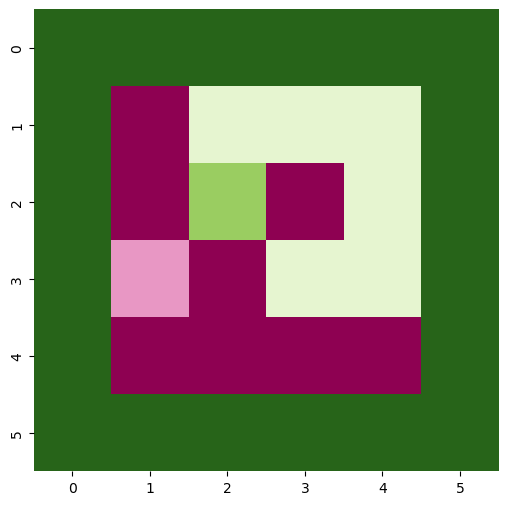

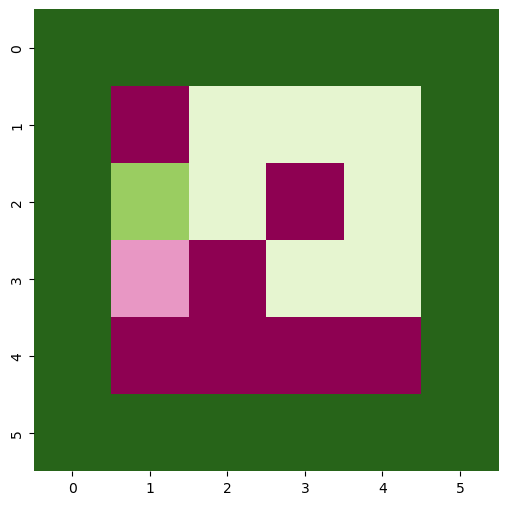

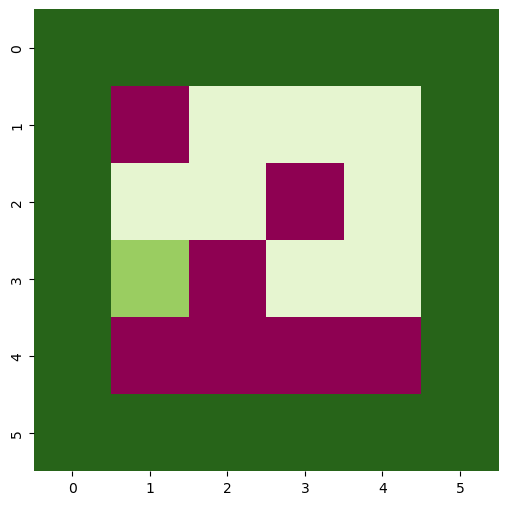

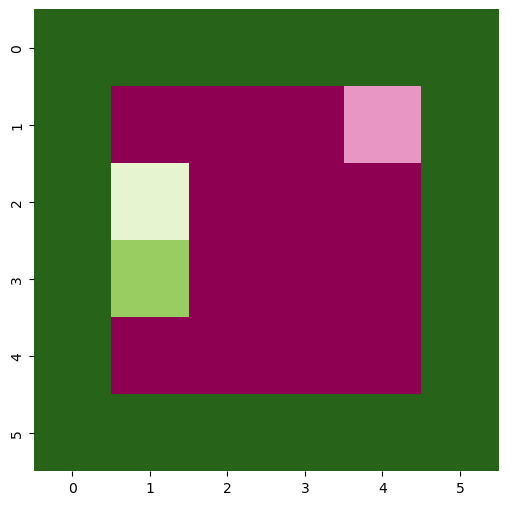

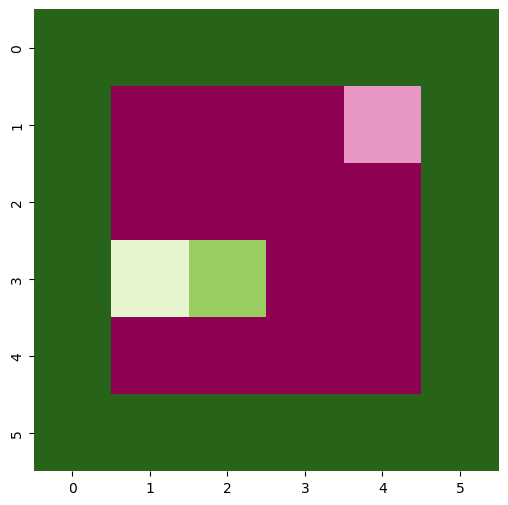

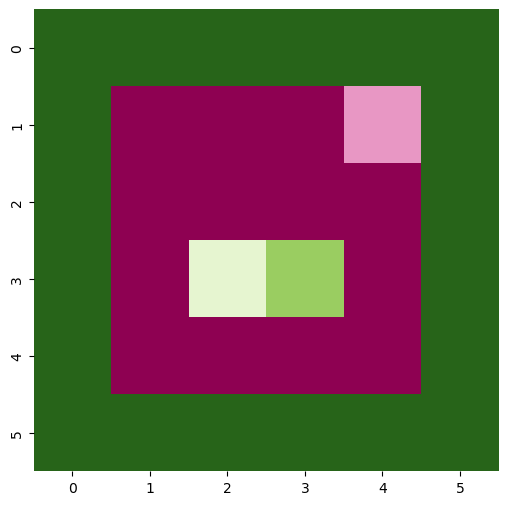

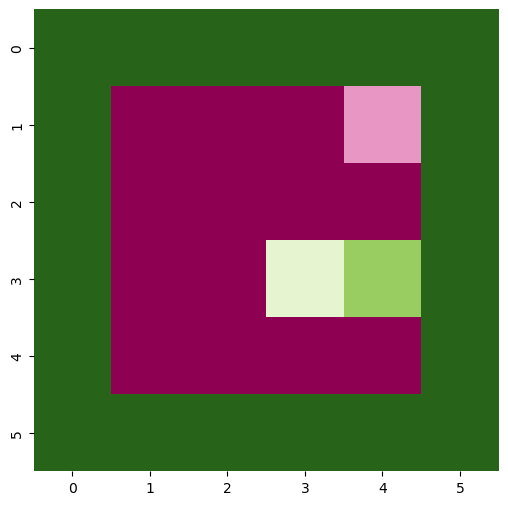

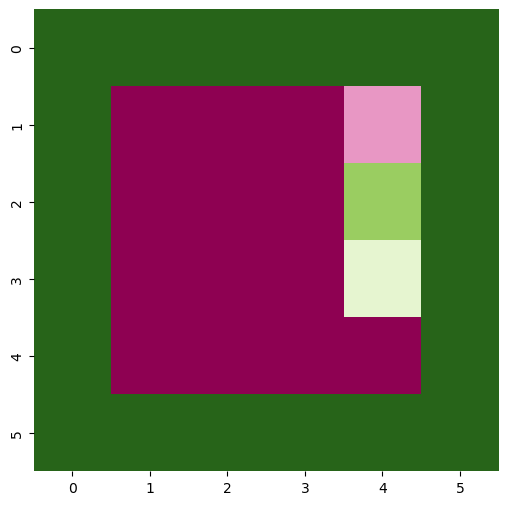

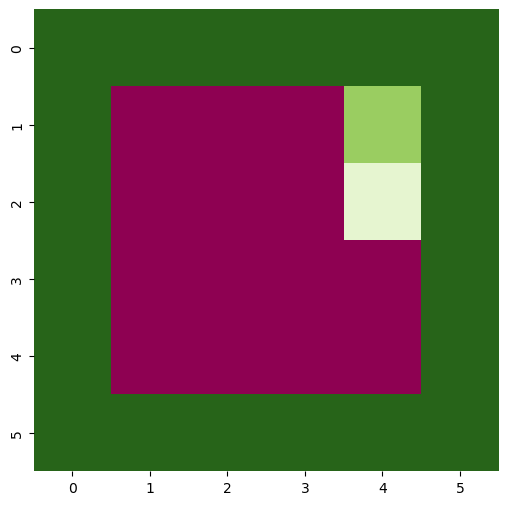

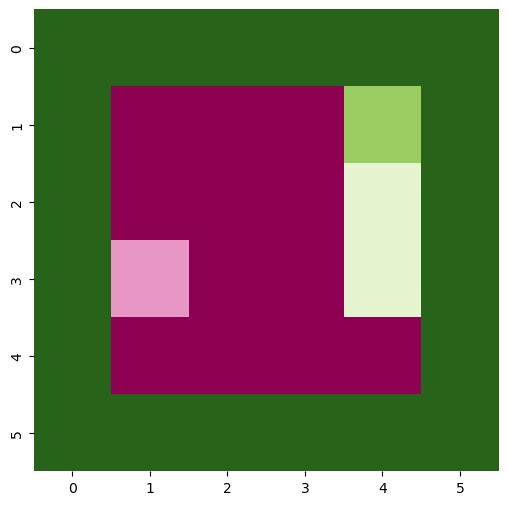

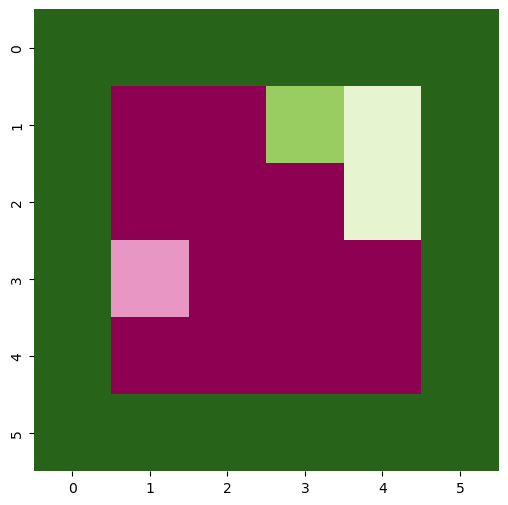

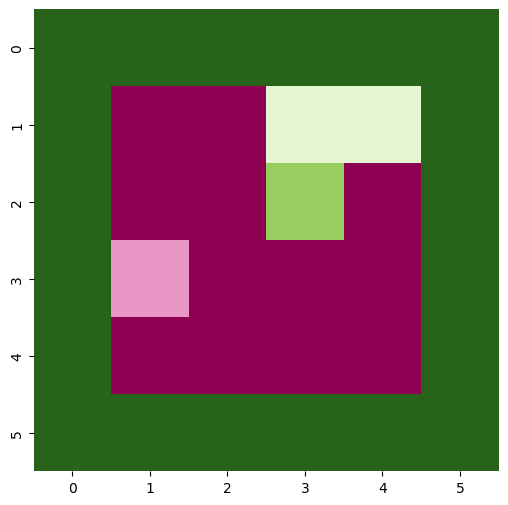

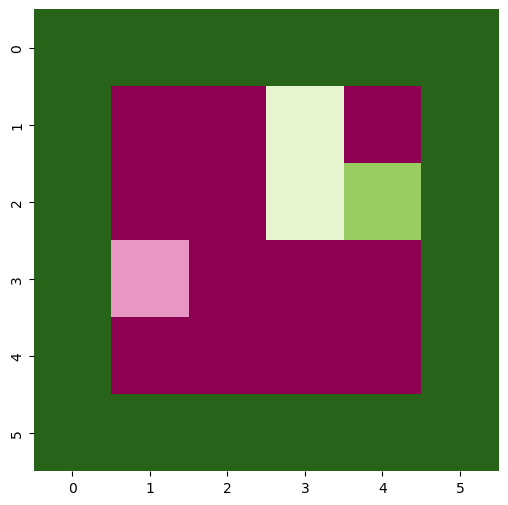

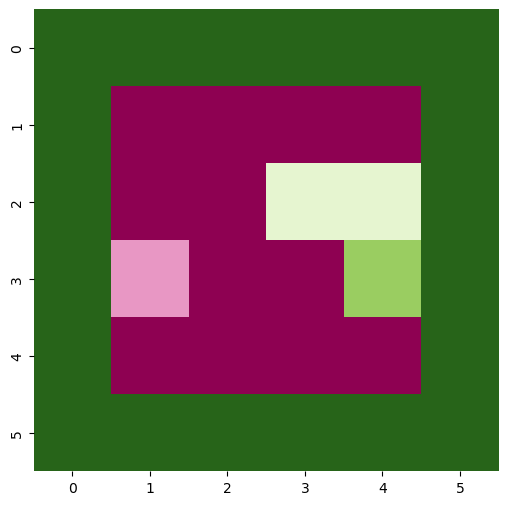

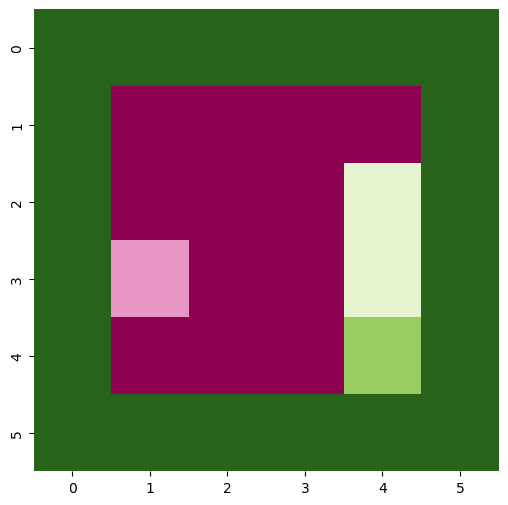

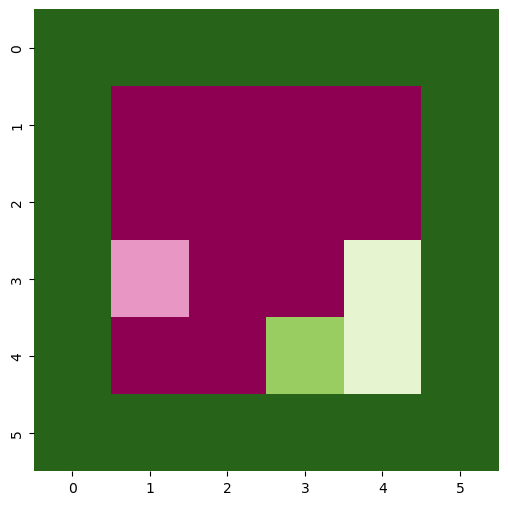

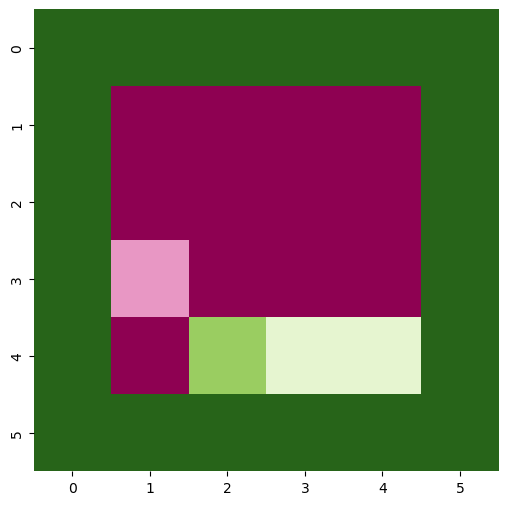

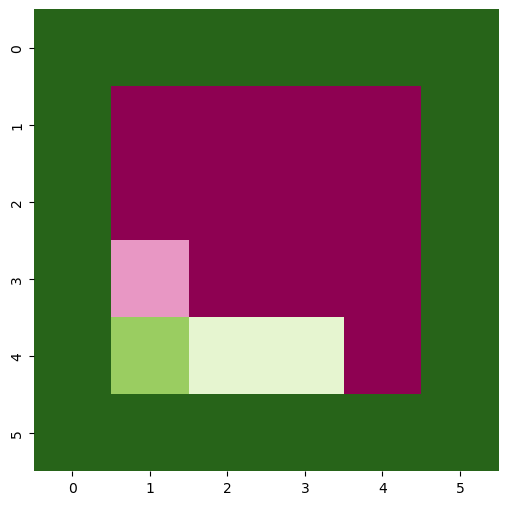

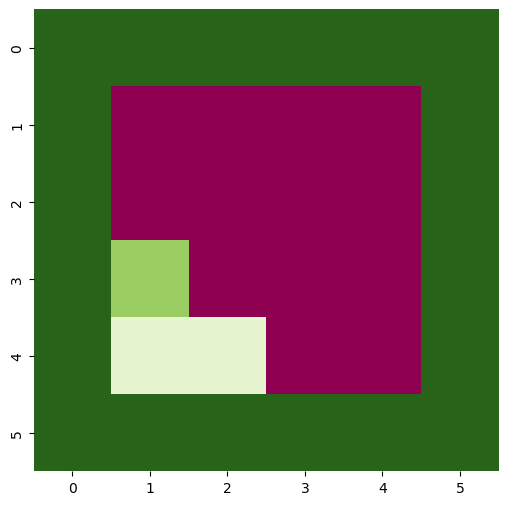

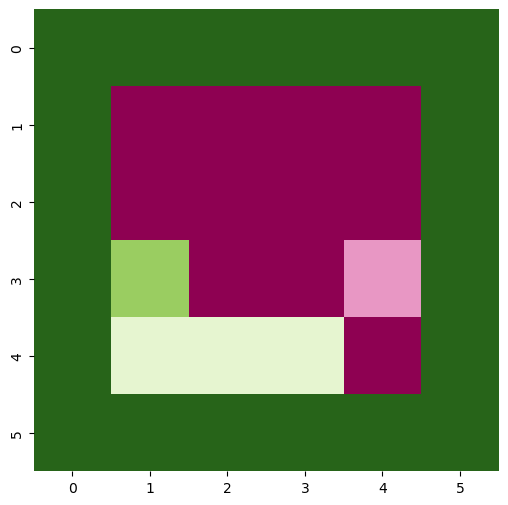

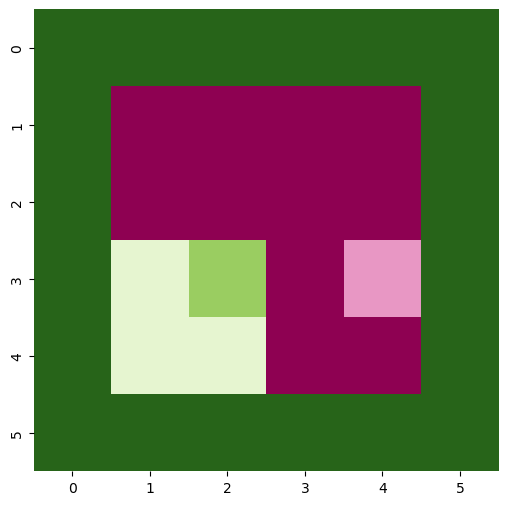

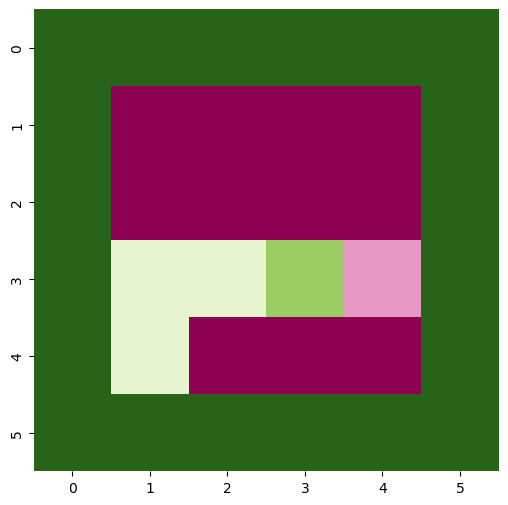

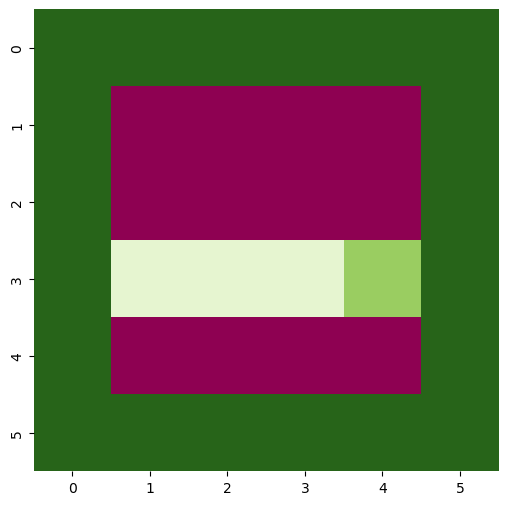

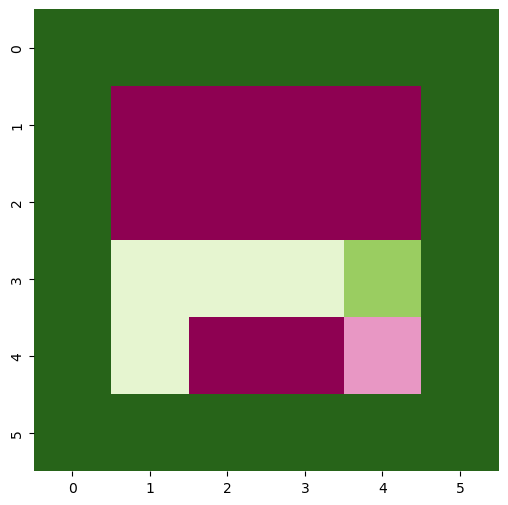

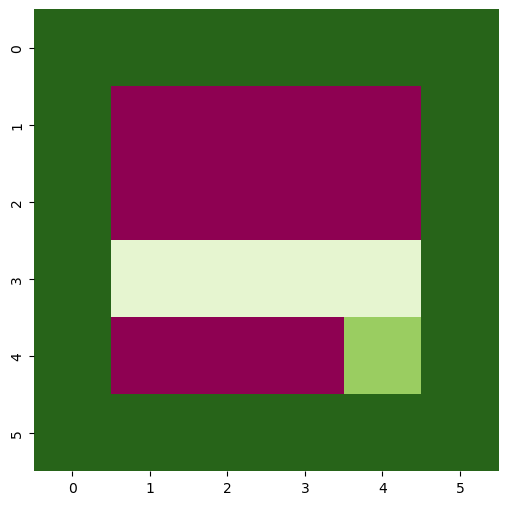

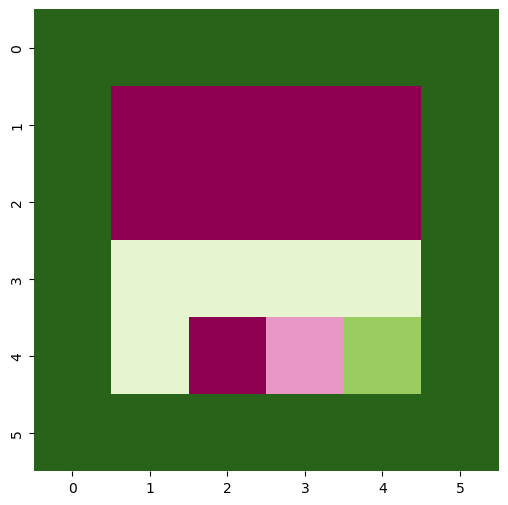

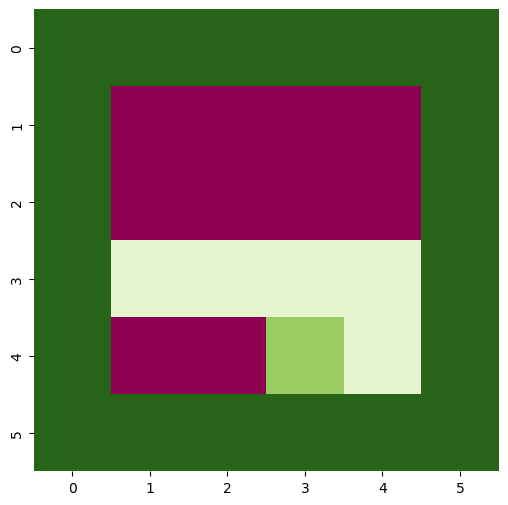

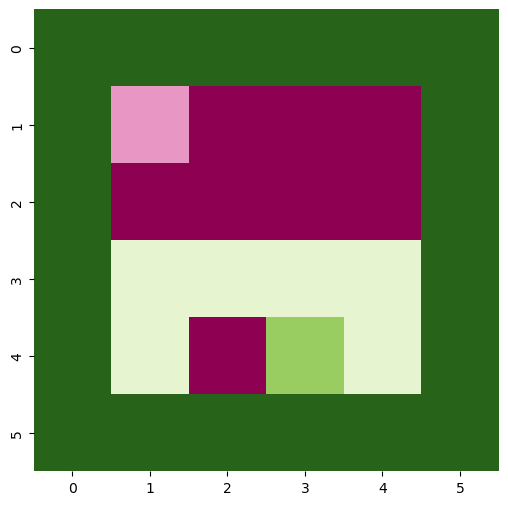

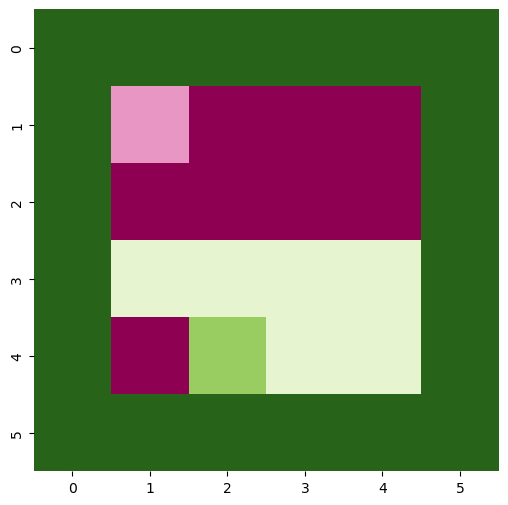

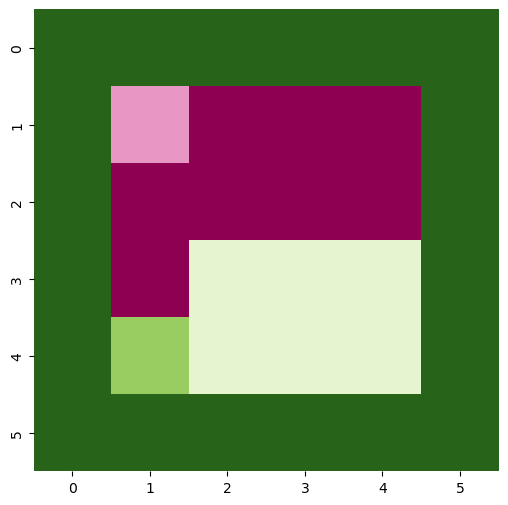

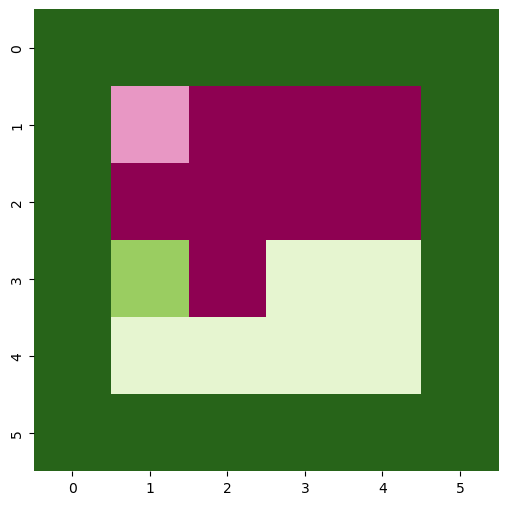

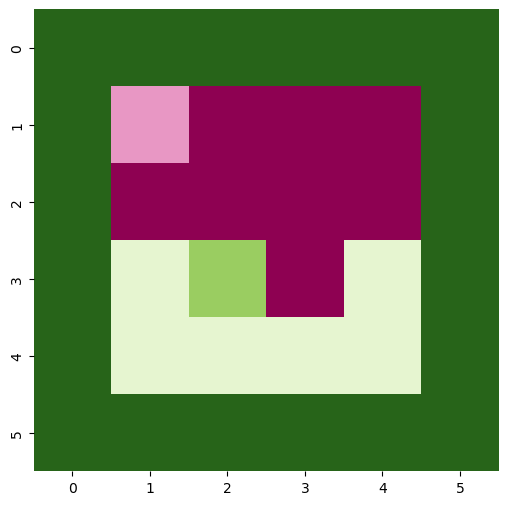

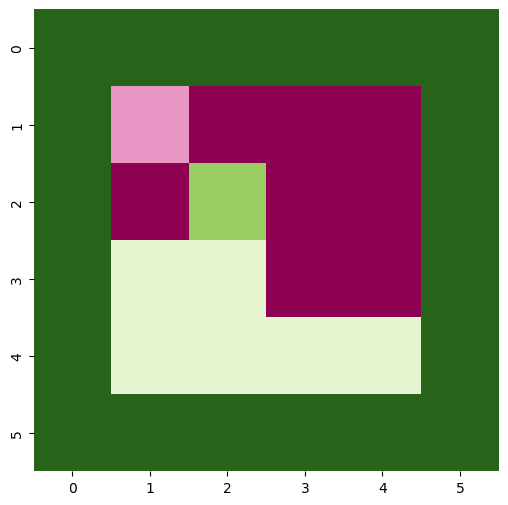

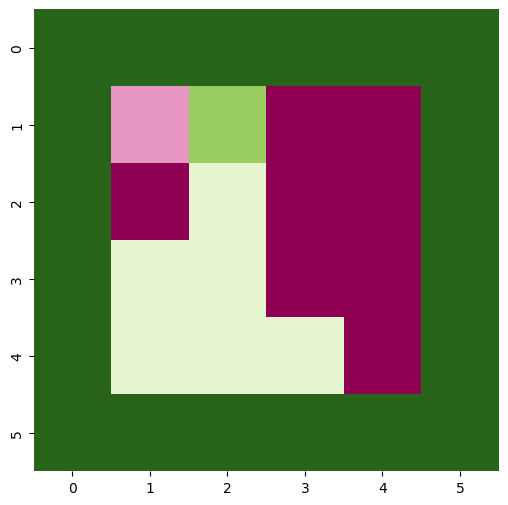

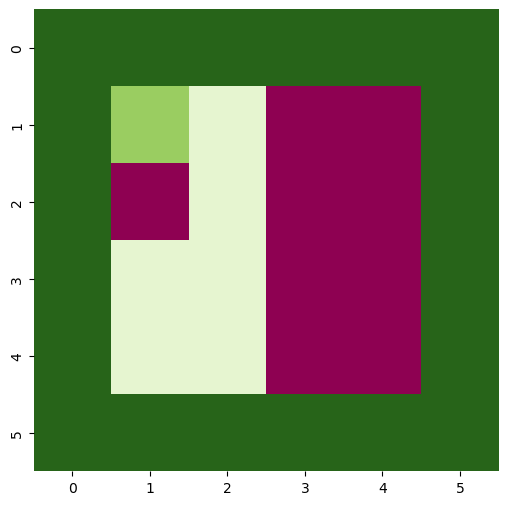

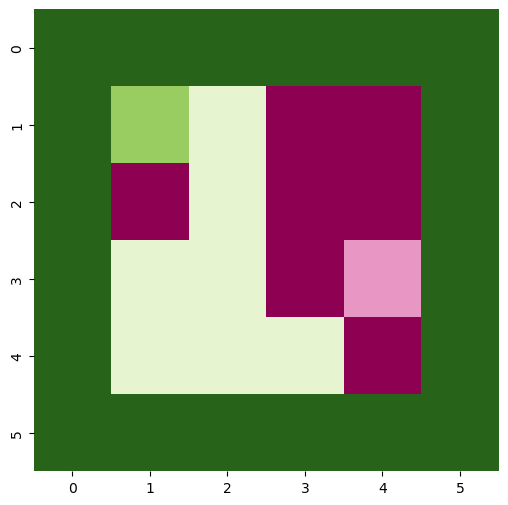

In [82]:
applySearch(depth_first_search,"Depth-First-Search (DFS)")

{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Uniform-Cost-Search (UCS)

Total nodes in maze : 15
Total nodes visited : 12  |  80.0 %
Final path distance : 4

Path through the Maze : [(3, 3), (2, 3), (1, 3), (1, 2)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): 

C:\Users\huang\AppData\Local\Temp\ipykernel_29308\3245365467.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize = (width,height))


{(1, 1): [((2, 1), 1)], (1, 2): [((2, 2), 1)], (1, 3): [((1, 4), 1)], (1, 4): [((2, 4), 1)], (2, 1): [((3, 1), 1), ((2, 2), 1)], (2, 2): [((2, 1), 1), ((3, 2), 1)], (2, 3): [((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Uniform-Cost-Search (UCS)

Total nodes in maze : 9
Total nodes visited : 3  |  33.33 %
Final path distance : 3

Path through the Maze : [(1, 1), (2, 1), (2, 2)]
{(1, 1): [], (1, 2): [], (1, 3): [((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((3, 1), 1)], (2, 2): [((3, 2), 1)], (2, 3): [((3, 3), 1), ((2, 4), 1)], (2, 4

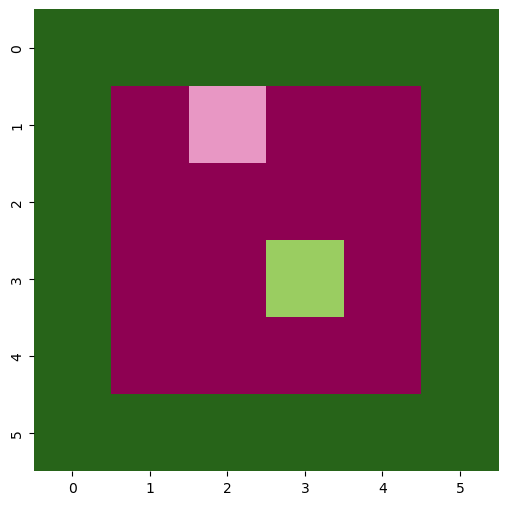

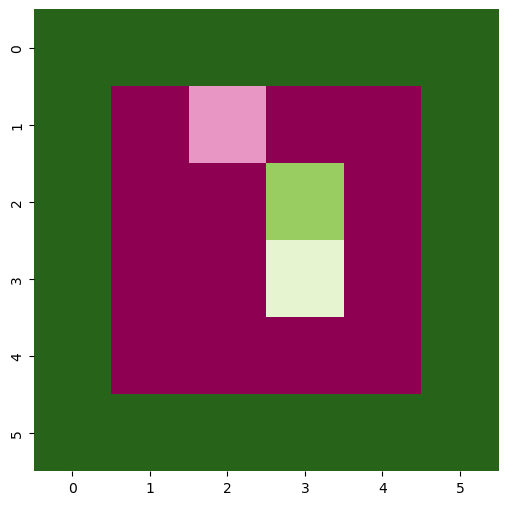

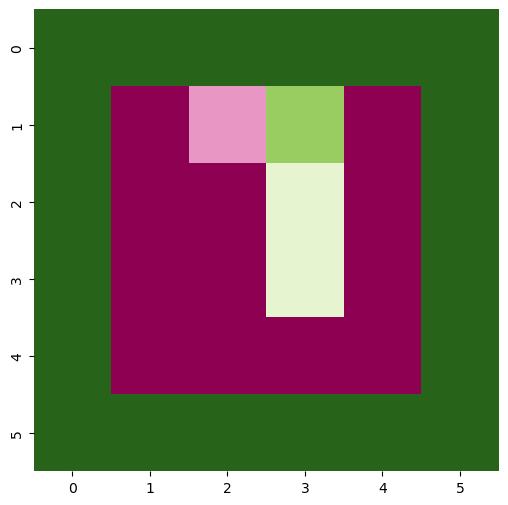

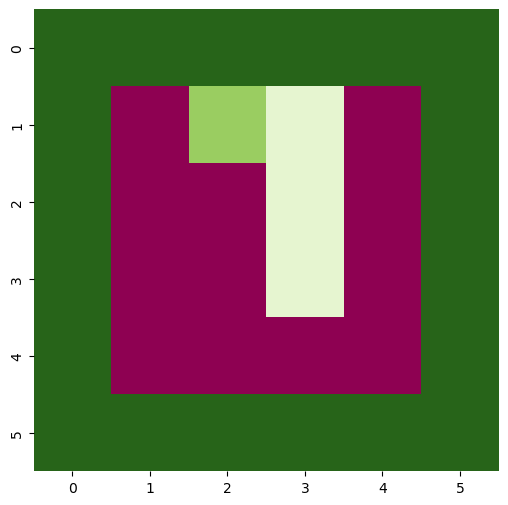

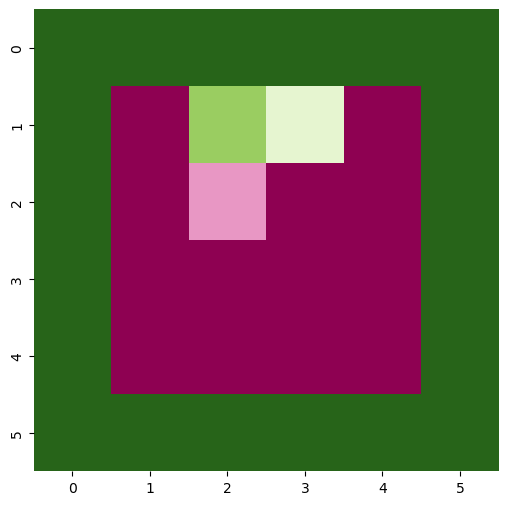

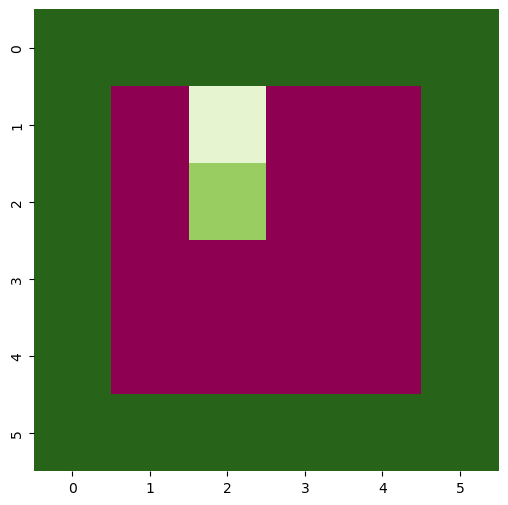

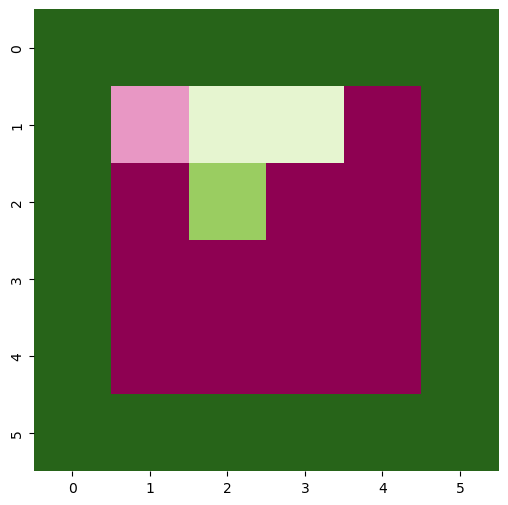

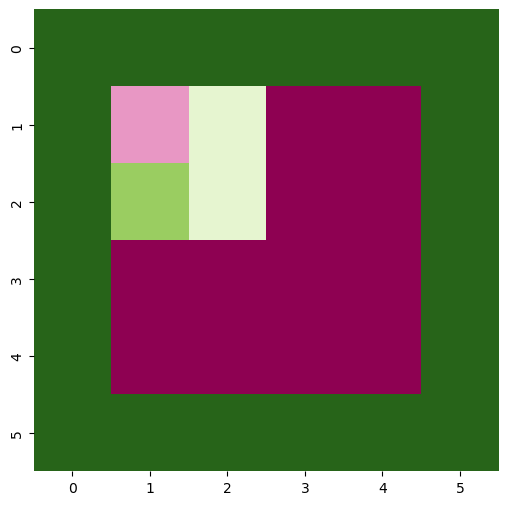

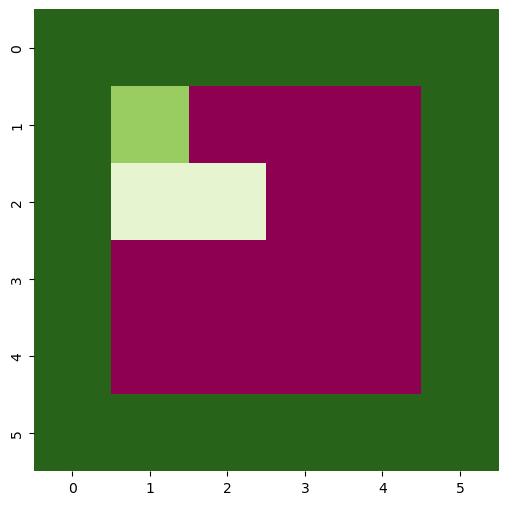

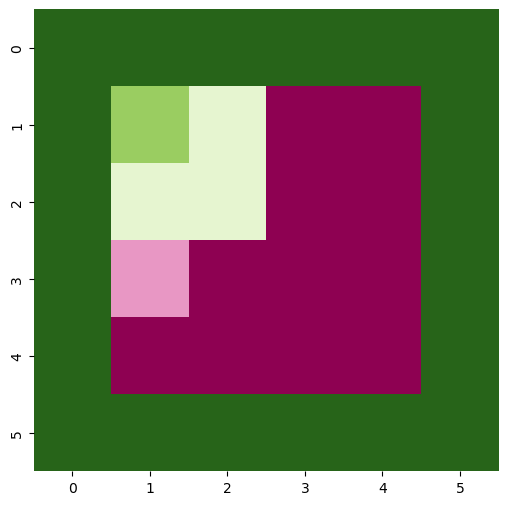

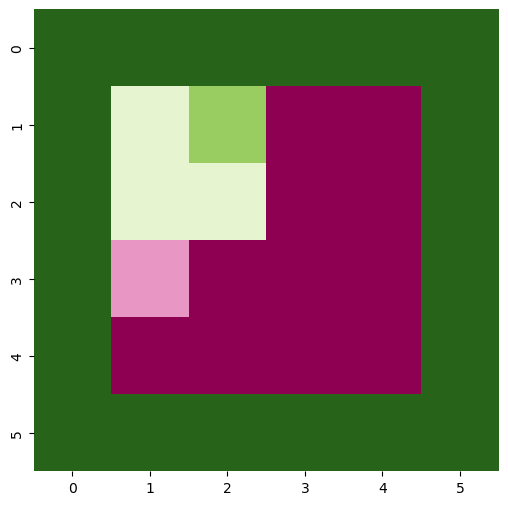

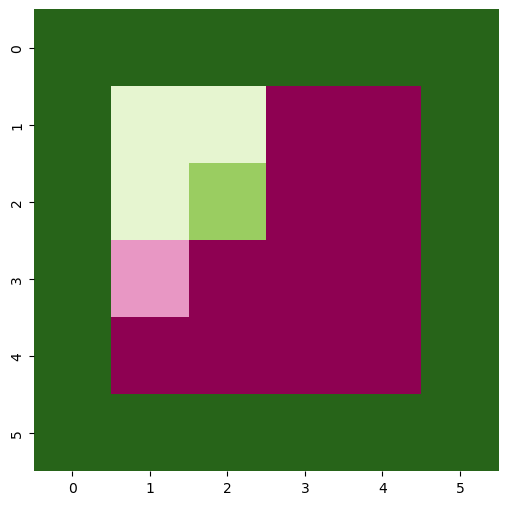

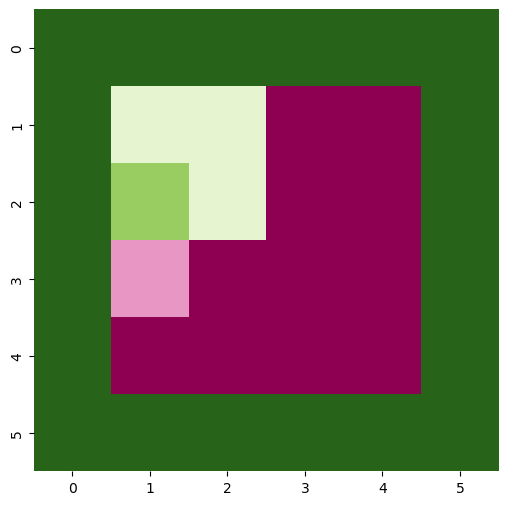

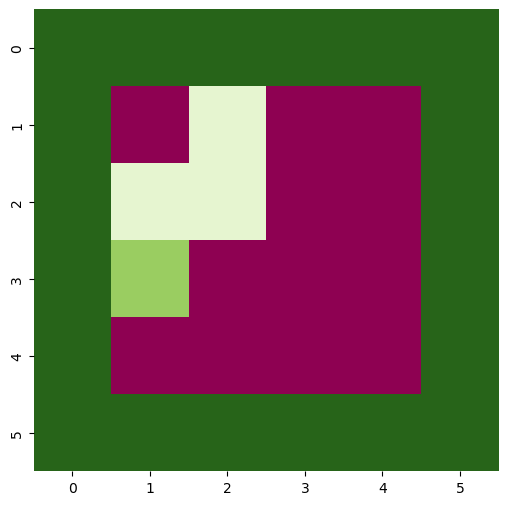

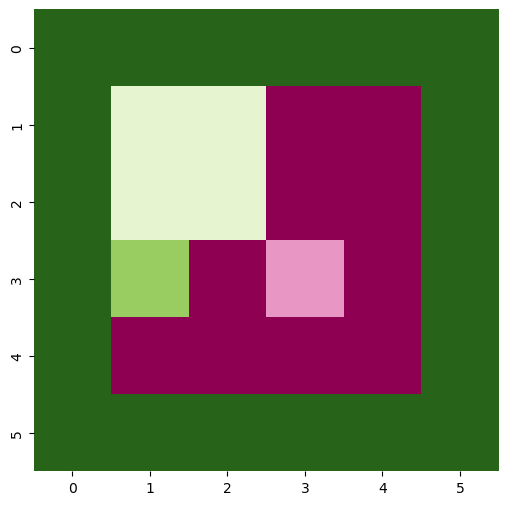

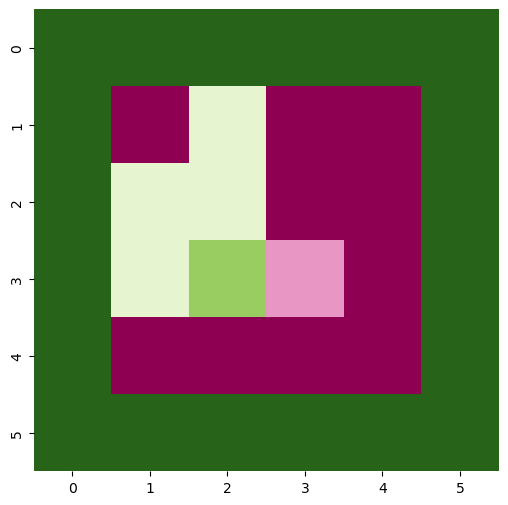

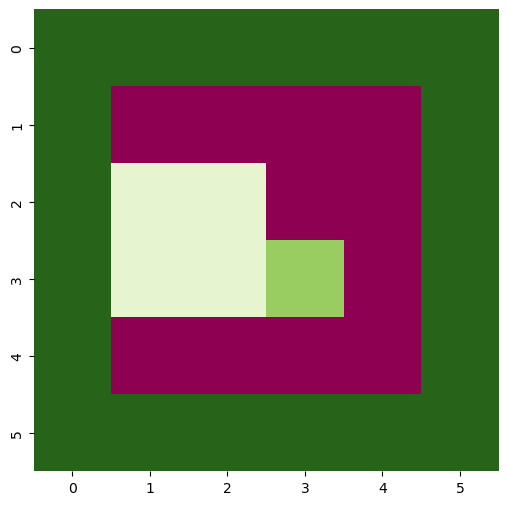

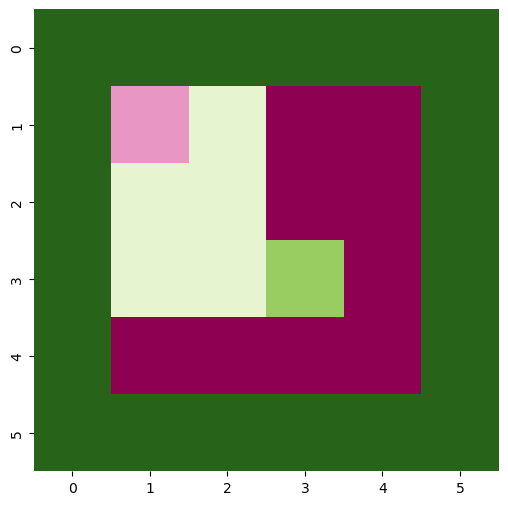

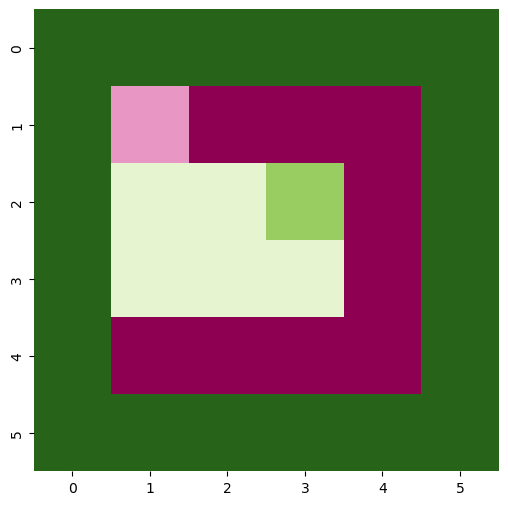

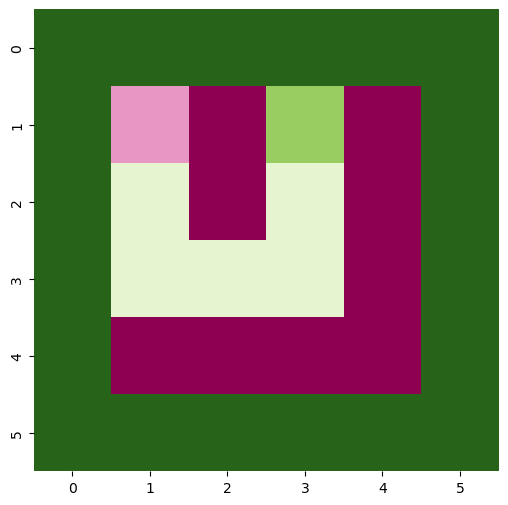

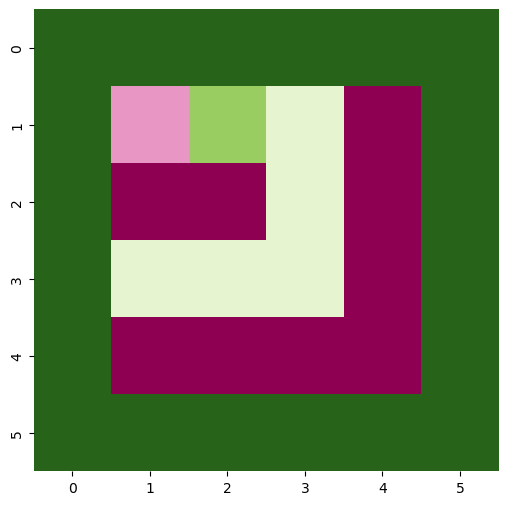

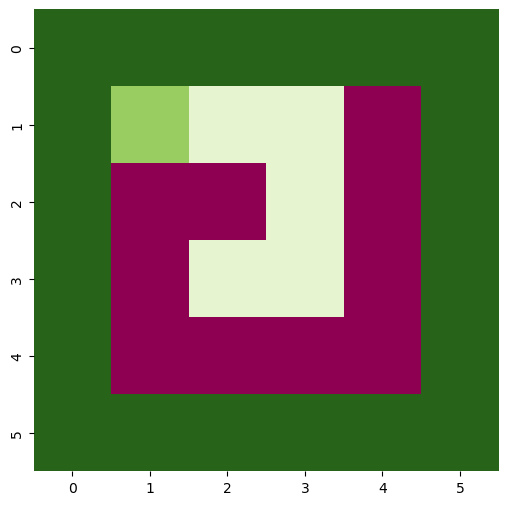

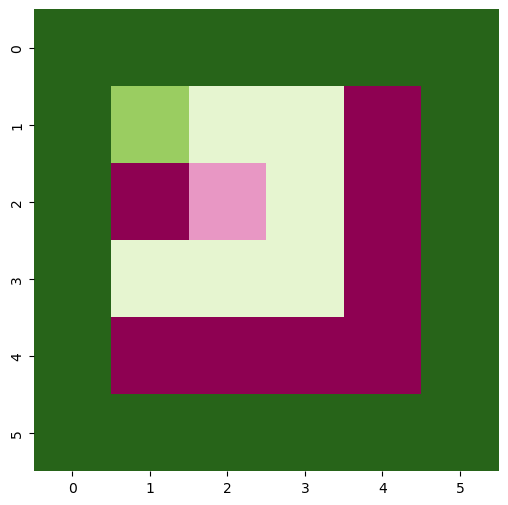

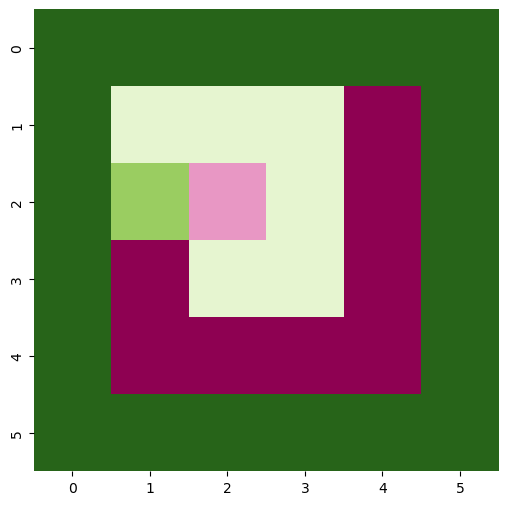

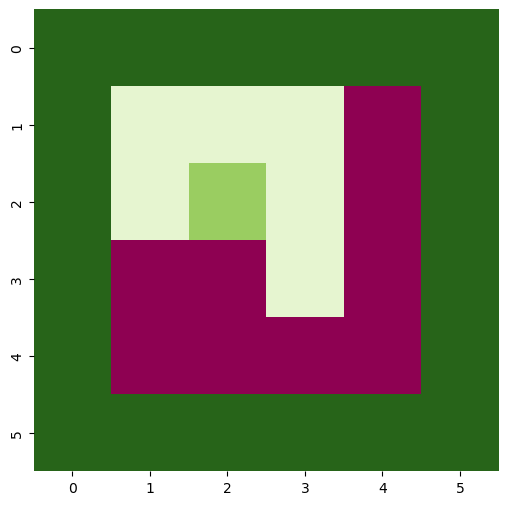

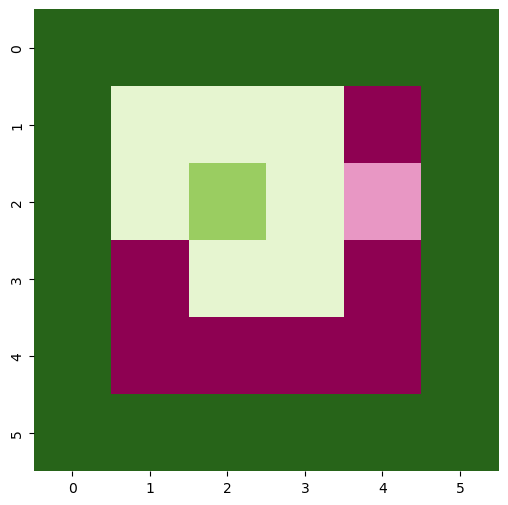

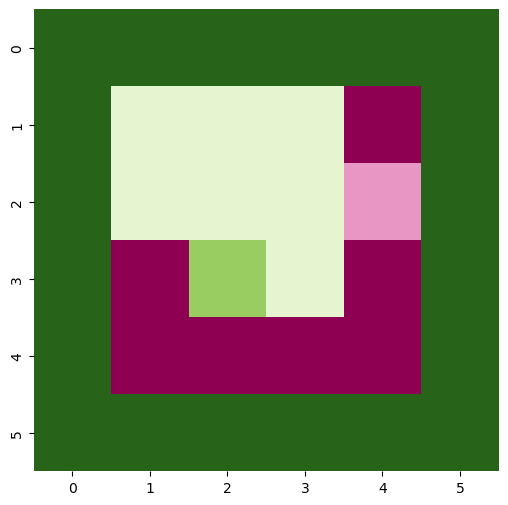

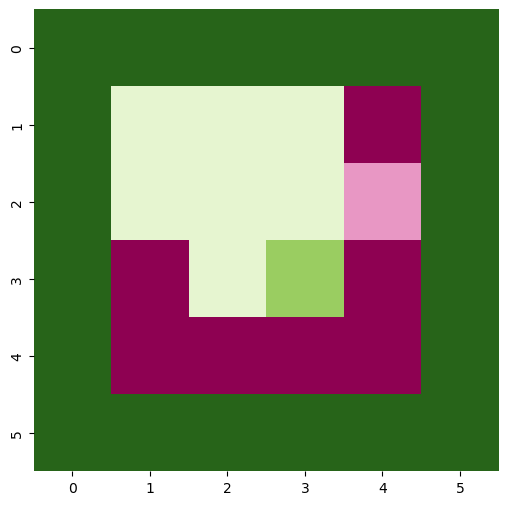

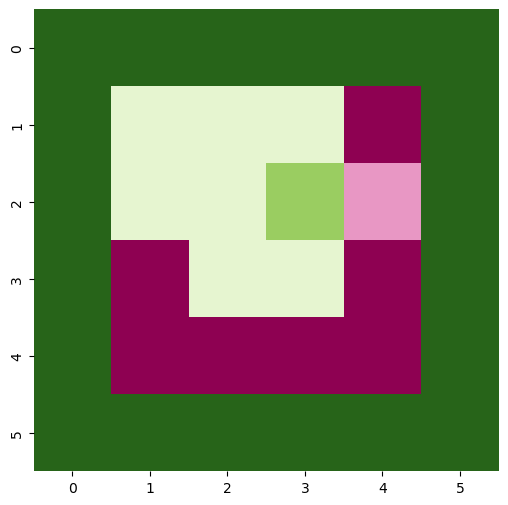

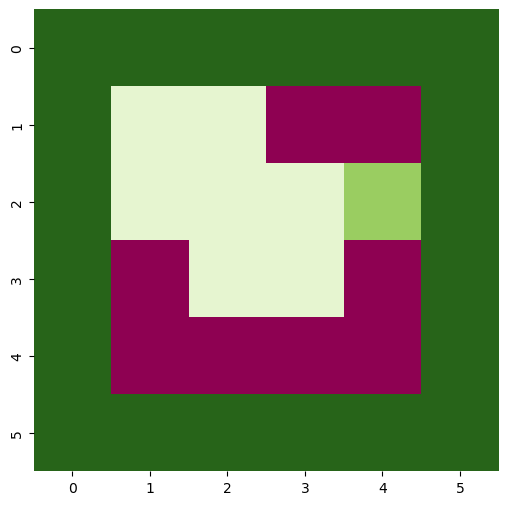

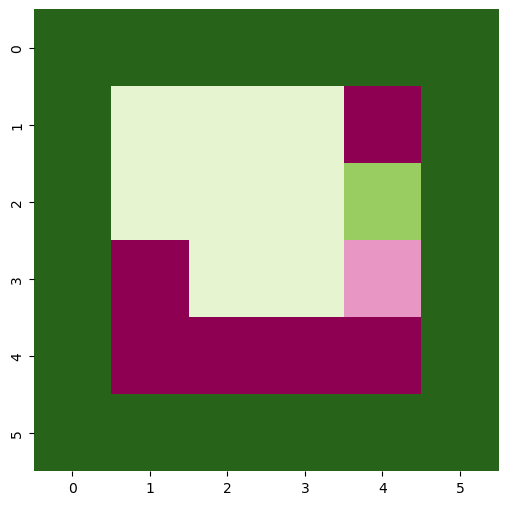

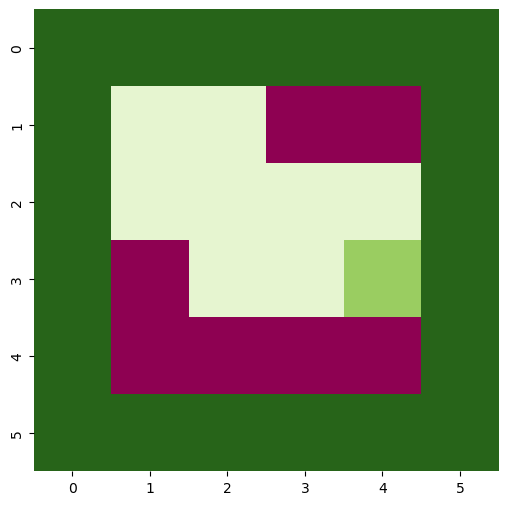

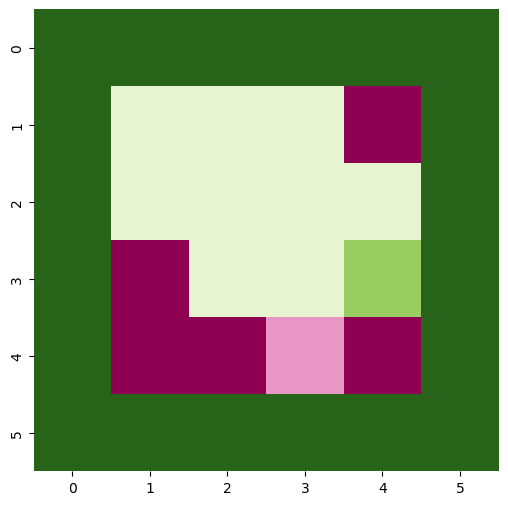

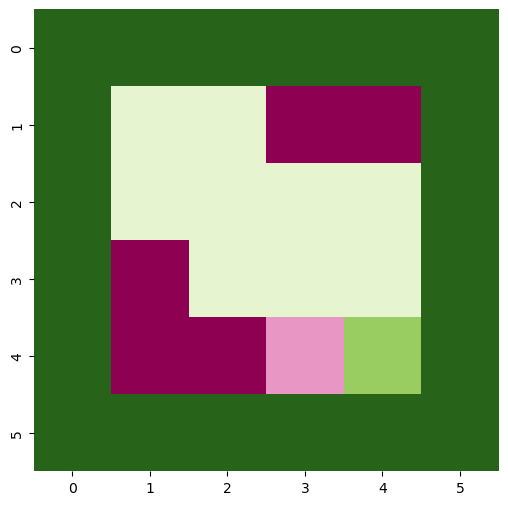

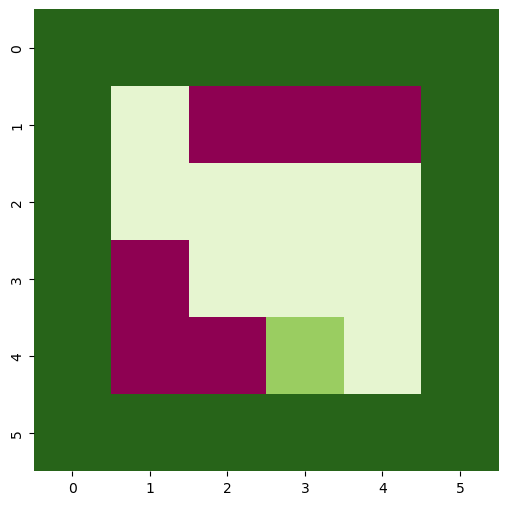

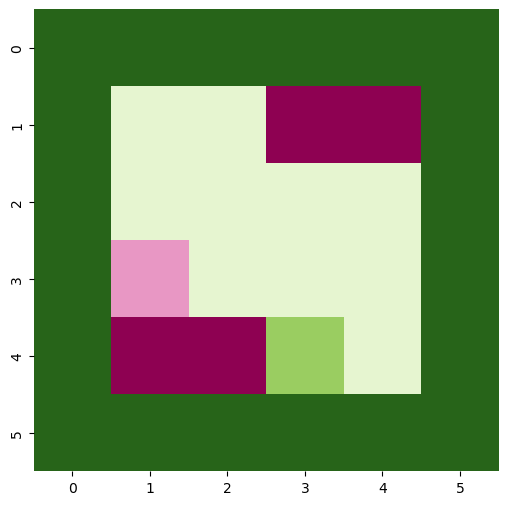

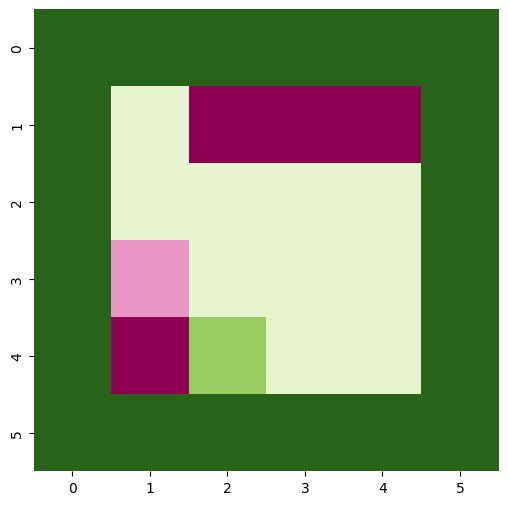

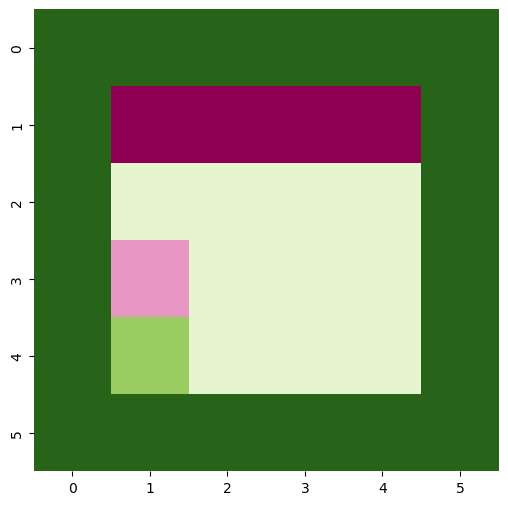

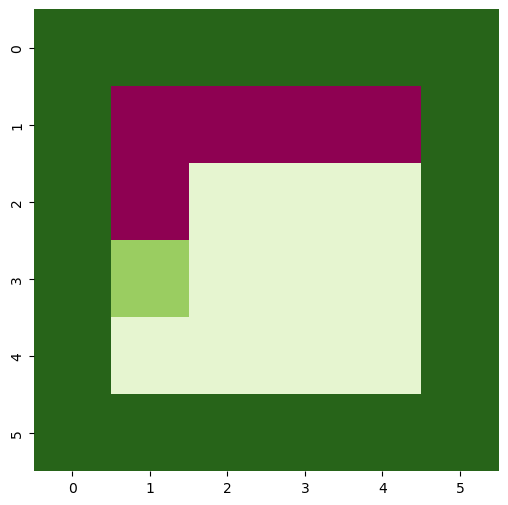

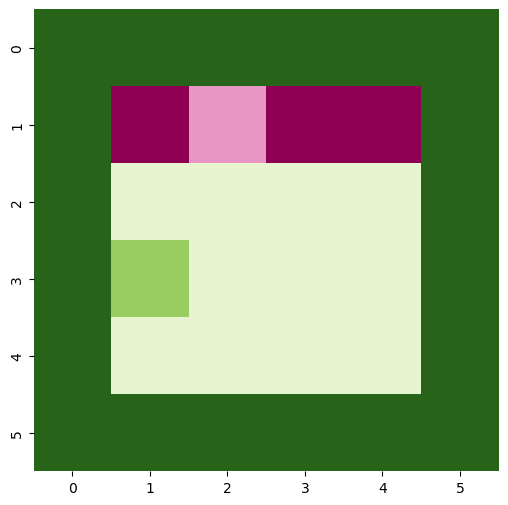

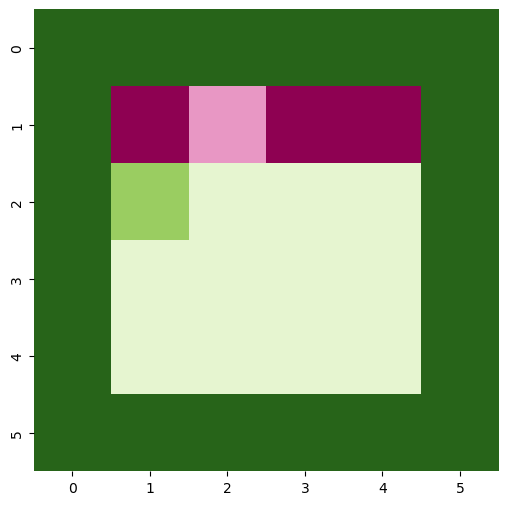

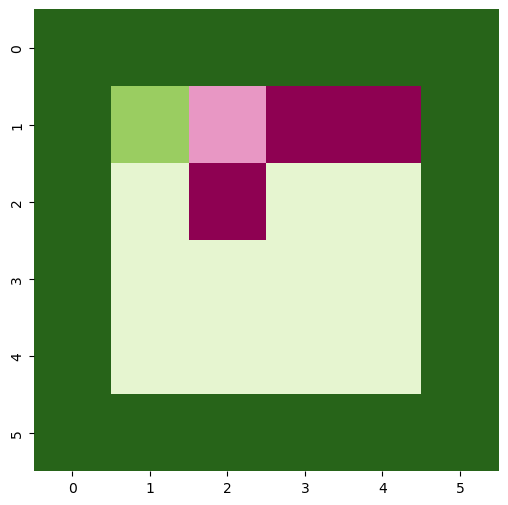

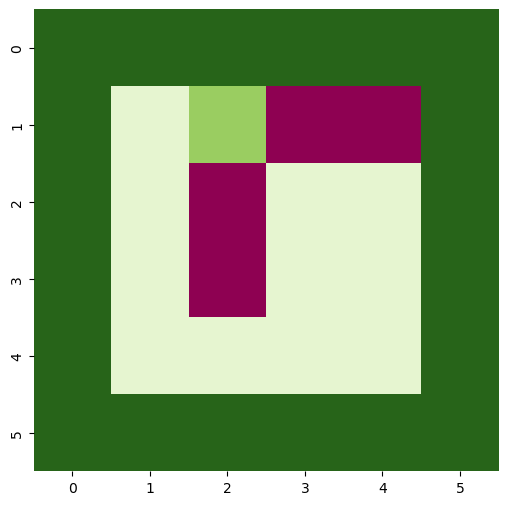

In [83]:
applySearch(uniform_cost_search,"Uniform-Cost-Search (UCS)")

Depth Limited Search

Total nodes in maze : 15
Total nodes visited : 9  |  60.0 %
Final path distance : 4

Path through the Maze : [(3, 3), (4, 3), (4, 2), (4, 1)]
Depth Limited Search

Total nodes in maze : 14
Total nodes visited : 11  |  78.57 %
Final path distance : 4

Path through the Maze : [(4, 1), (3, 1), (2, 1), (1, 1)]
Depth Limited Search

Total nodes in maze : 13
Total nodes visited : 3  |  23.08 %
Final path distance : 3

Path through the Maze : [(1, 1), (1, 2), (1, 3)]
Depth Limited Search

Total nodes in maze : 12
Total nodes visited : 2  |  16.67 %
Final path distance : 2

Path through the Maze : [(1, 3), (1, 4)]
Game Over!
Score:  5


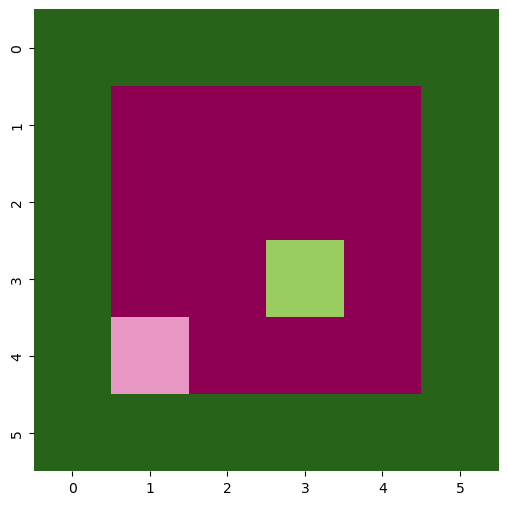

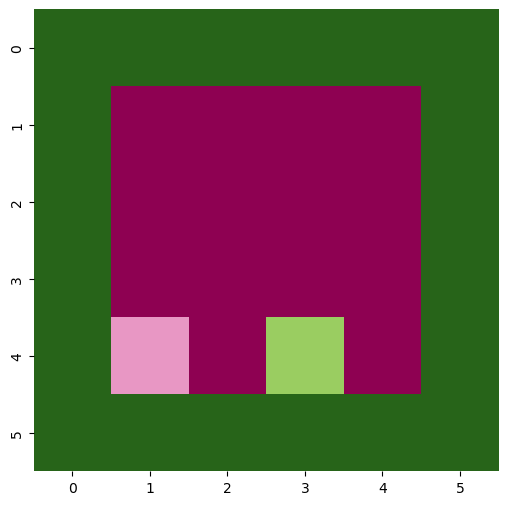

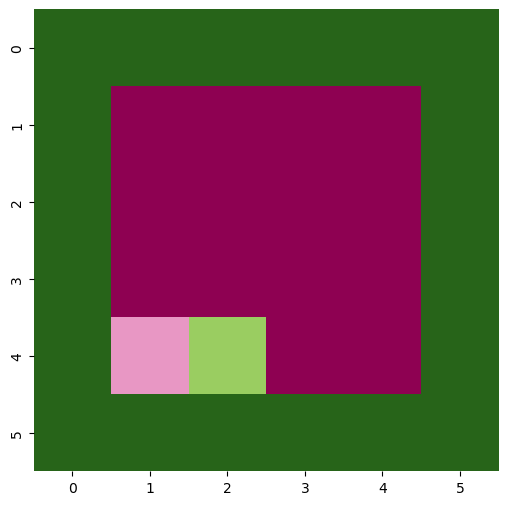

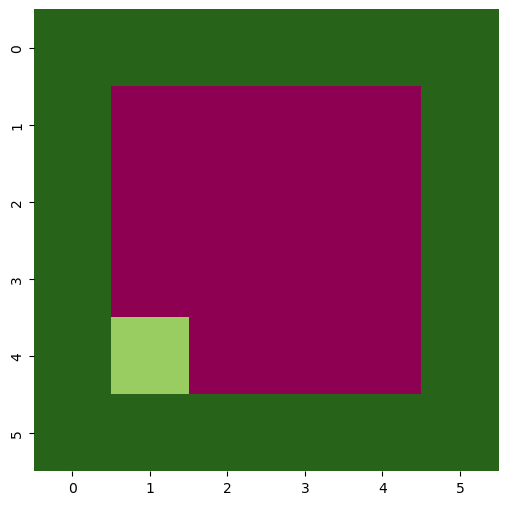

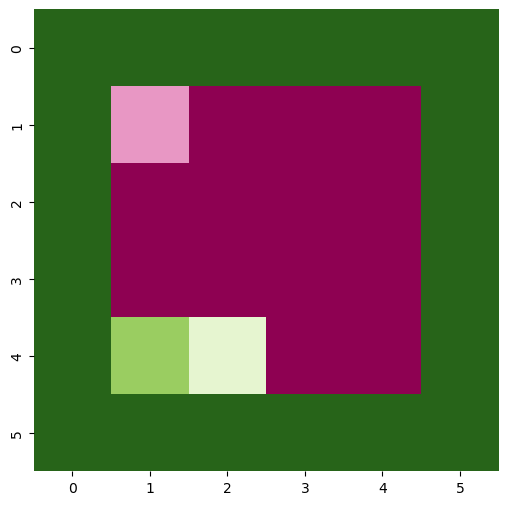

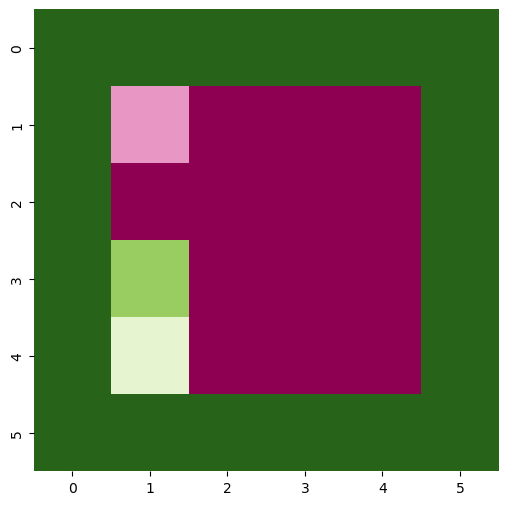

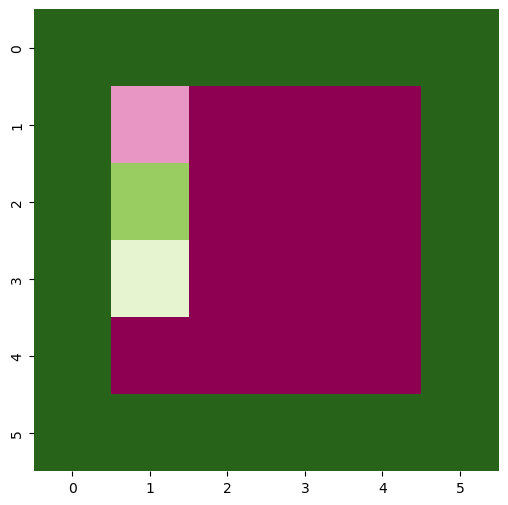

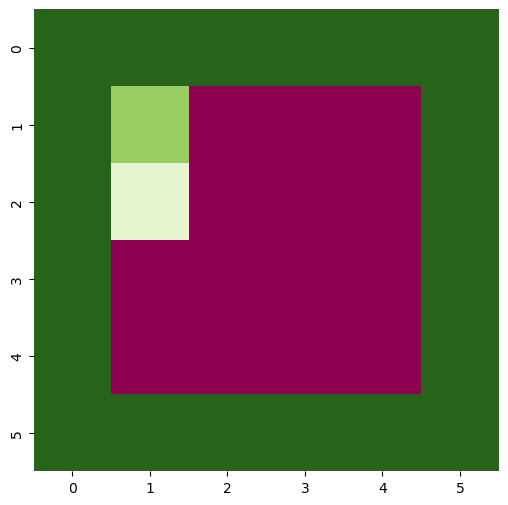

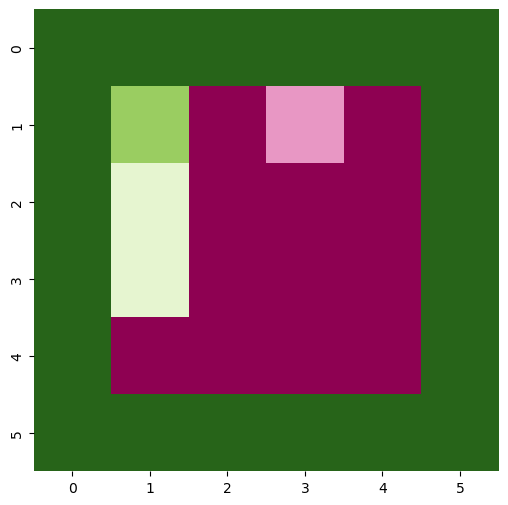

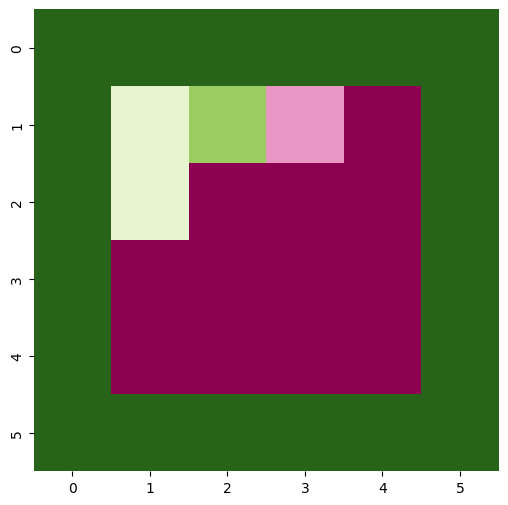

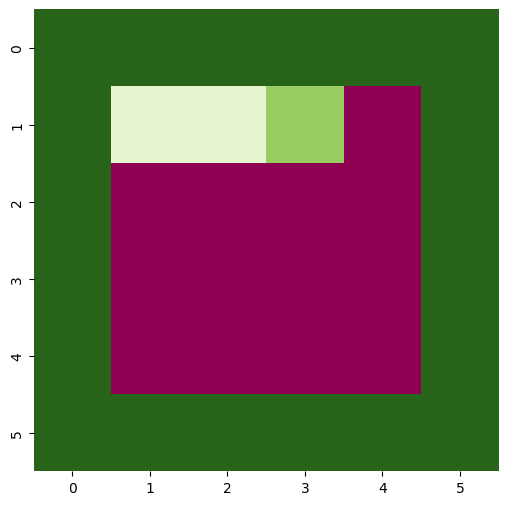

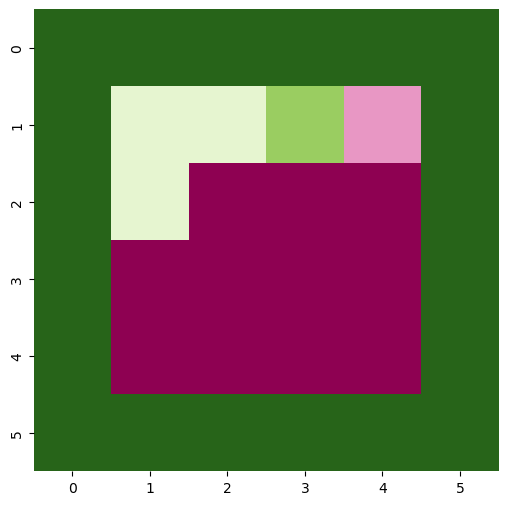

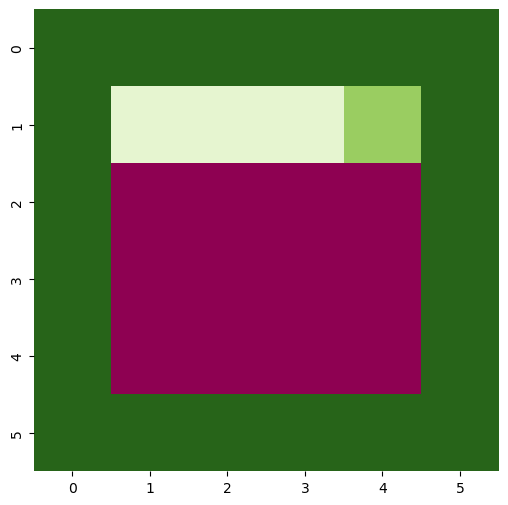

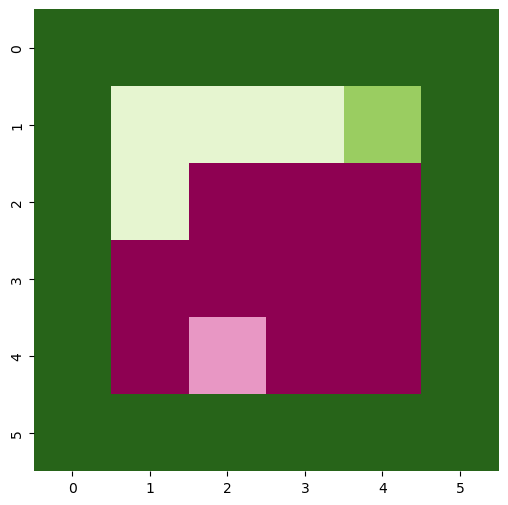

In [22]:
l = 4
applySearch(depth_limited_search(l), "Depth Limited Search")

{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Iterative Deepening Search

Total nodes in maze : 15
Total nodes visited : 13  |  86.67 %
Final path distance : 4

Path through the Maze : [(3, 3), (3, 2), (2, 2), (1, 2)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2)

C:\Users\huang\AppData\Local\Temp\ipykernel_29308\3245365467.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize = (width,height))


{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1)], (4, 4): []}
Iterative Deepening Search

Total nodes in maze : 10
Total nodes visited : 3  |  30.0 %
Final path distance : 2

Path through the Maze : [(4, 3), (3, 3)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3

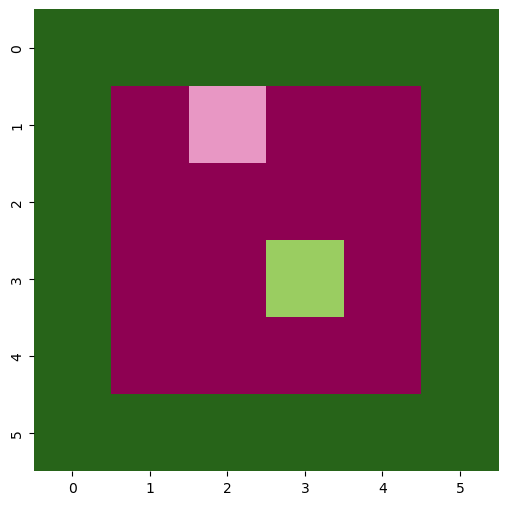

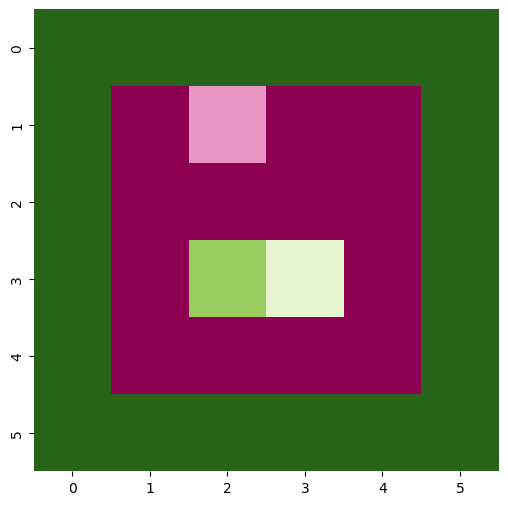

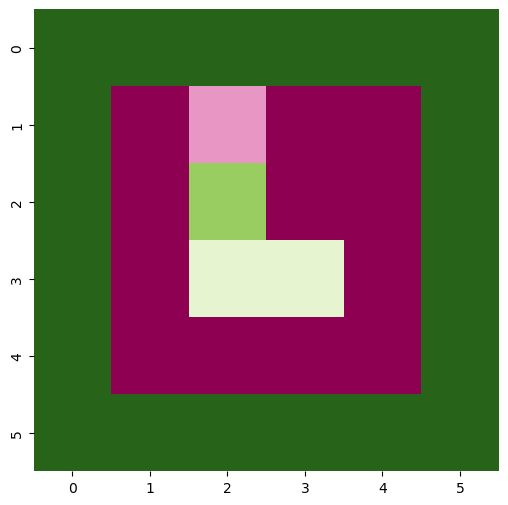

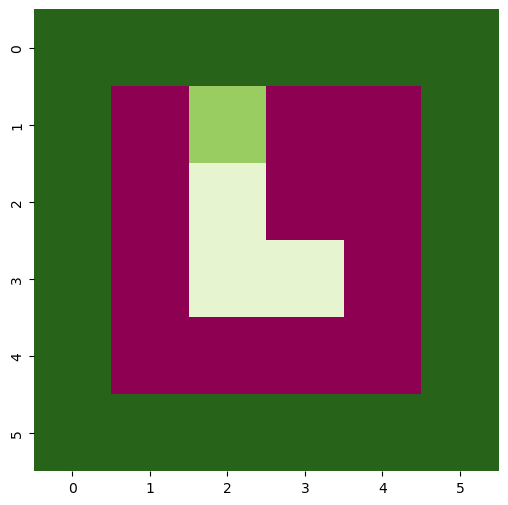

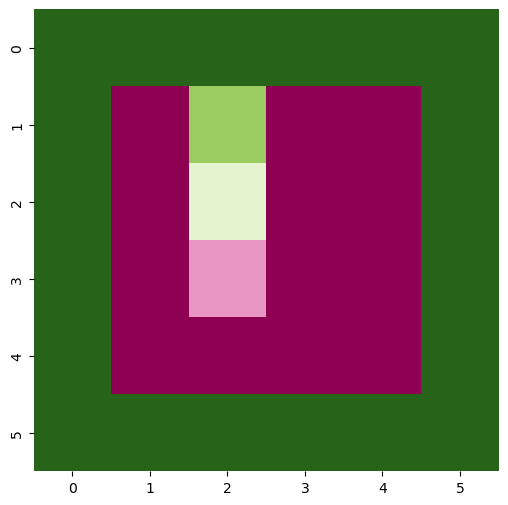

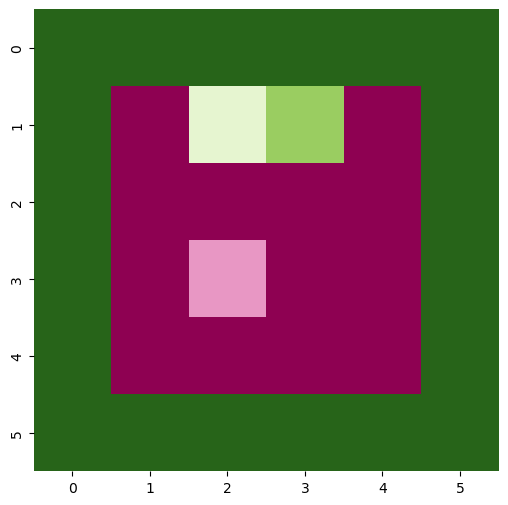

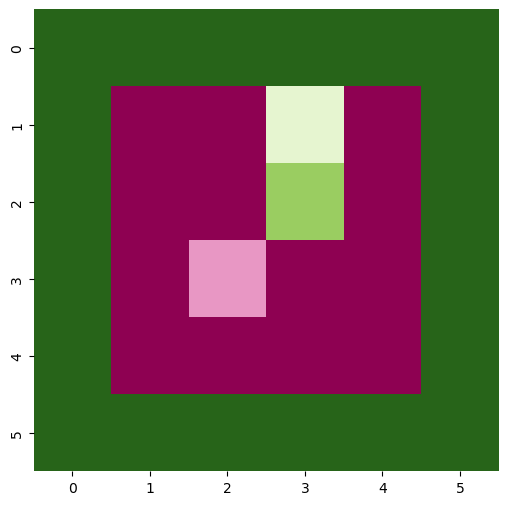

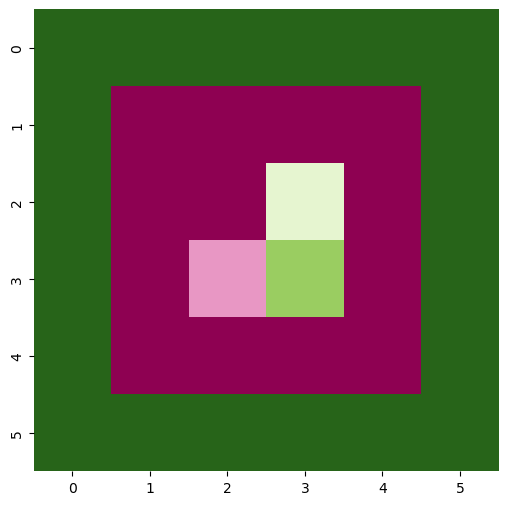

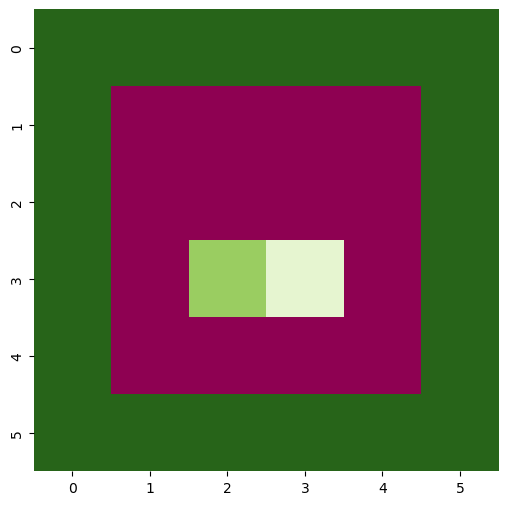

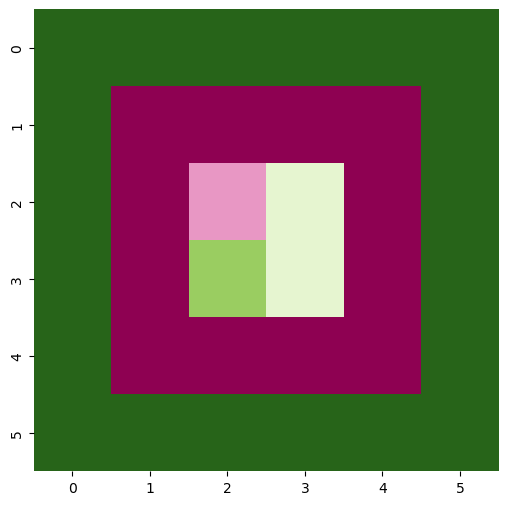

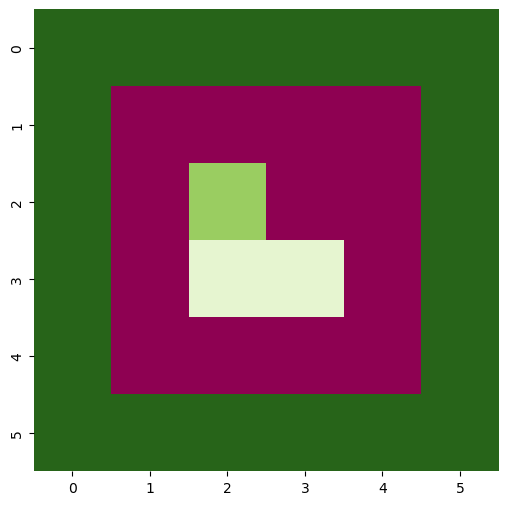

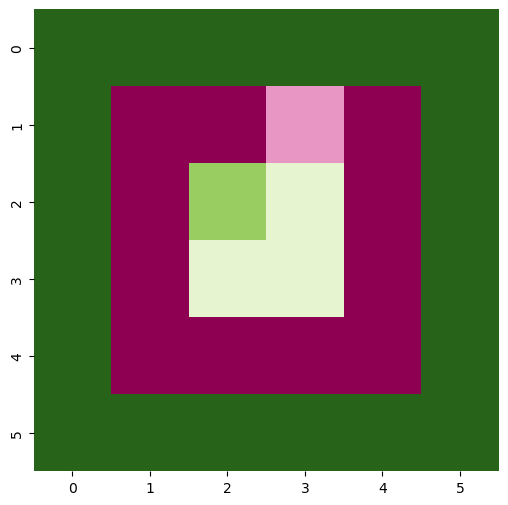

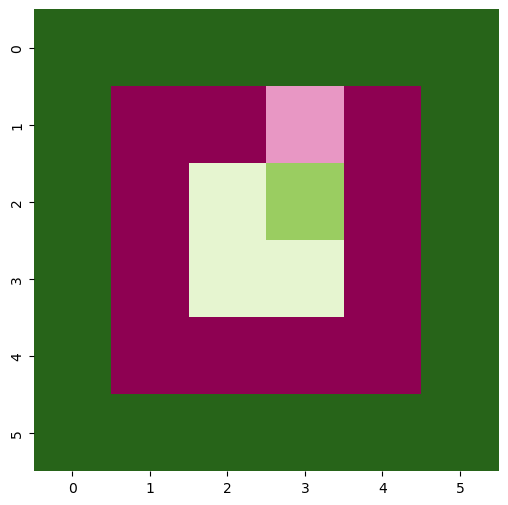

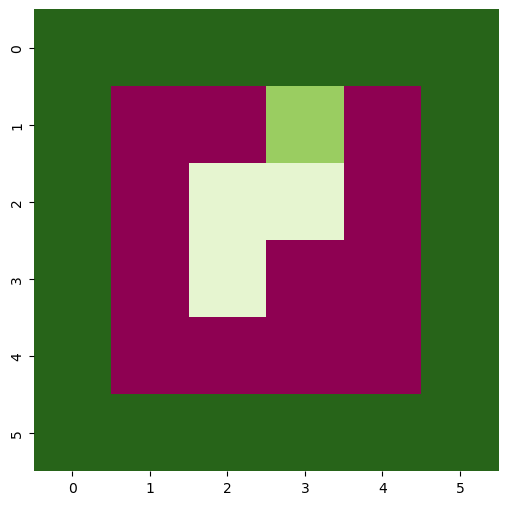

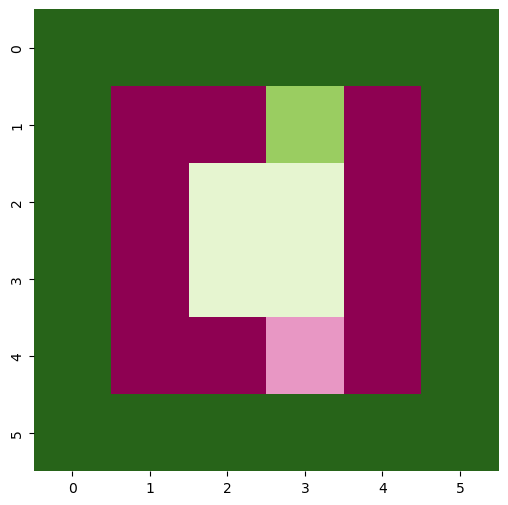

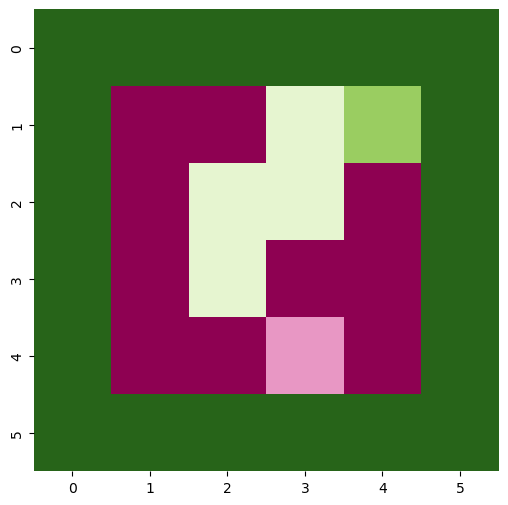

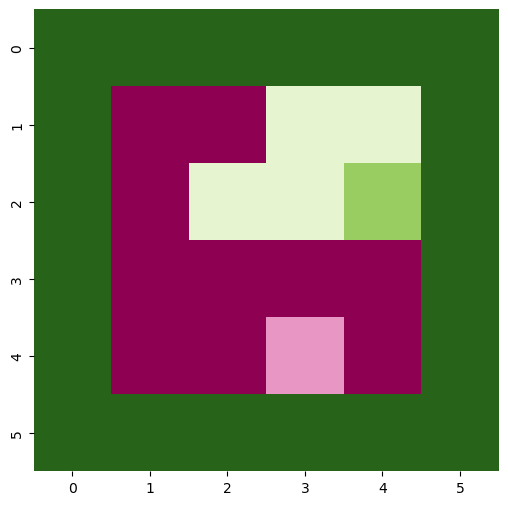

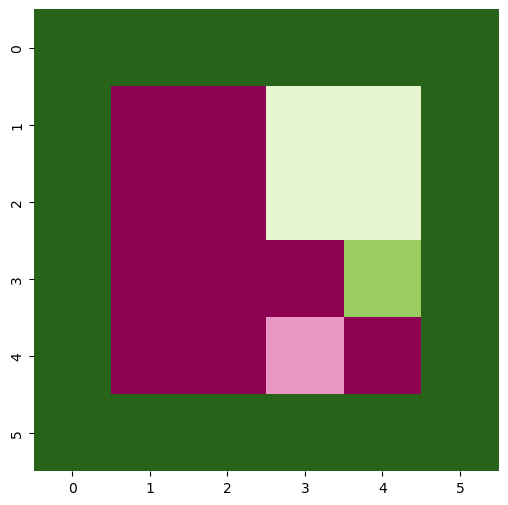

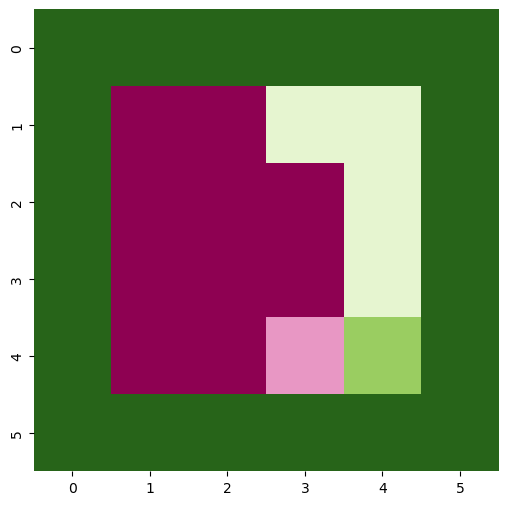

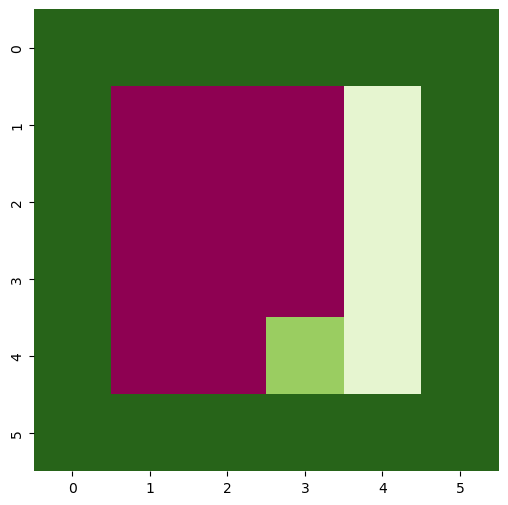

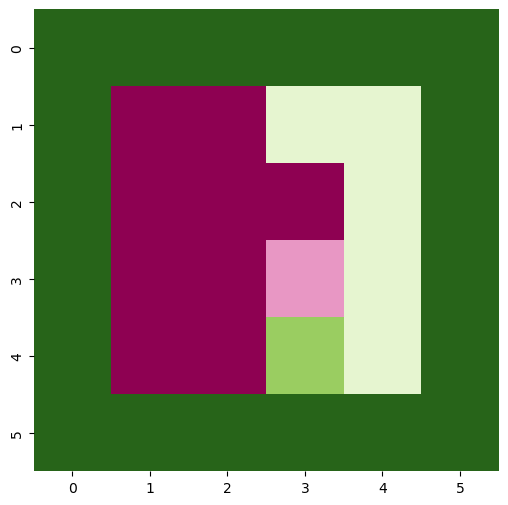

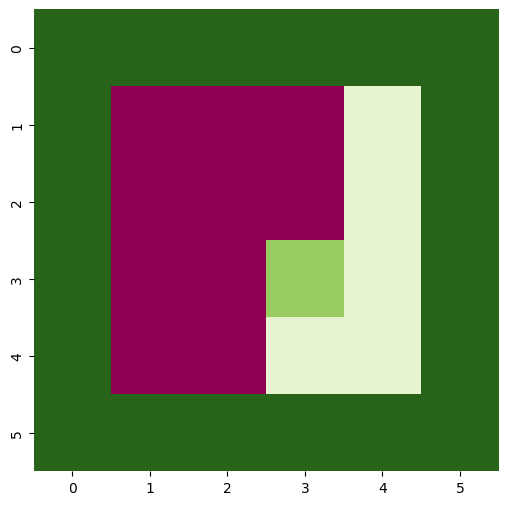

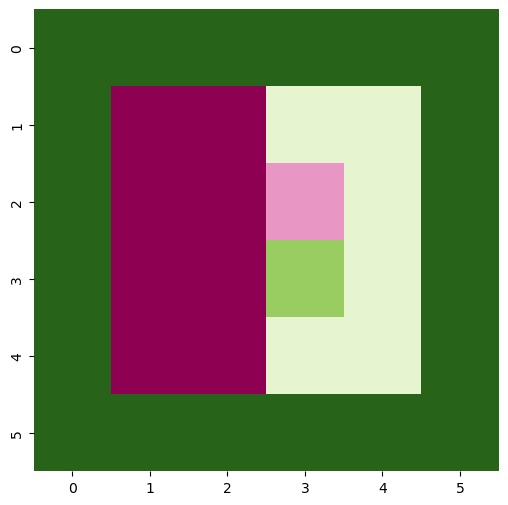

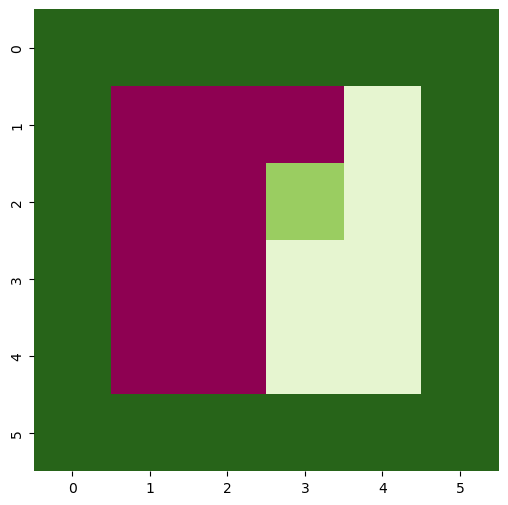

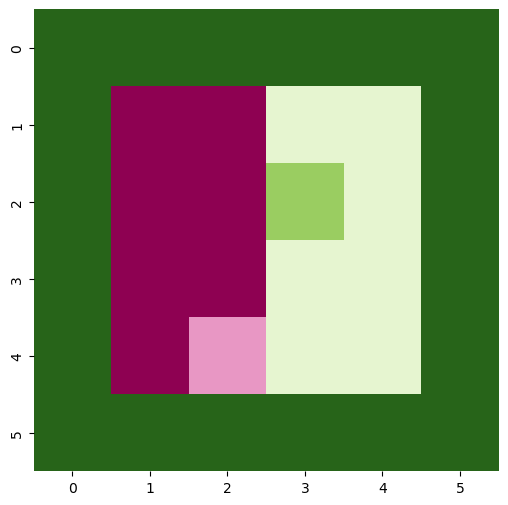

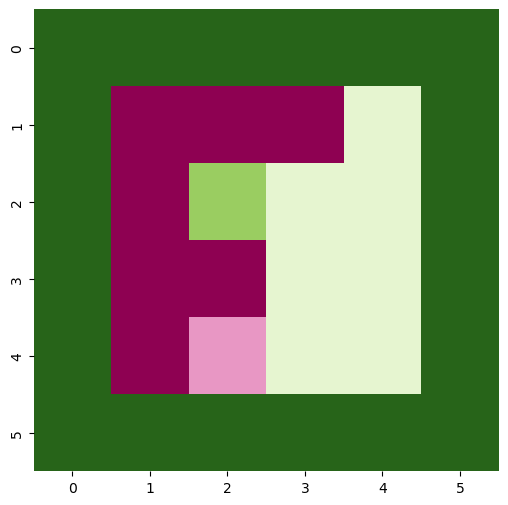

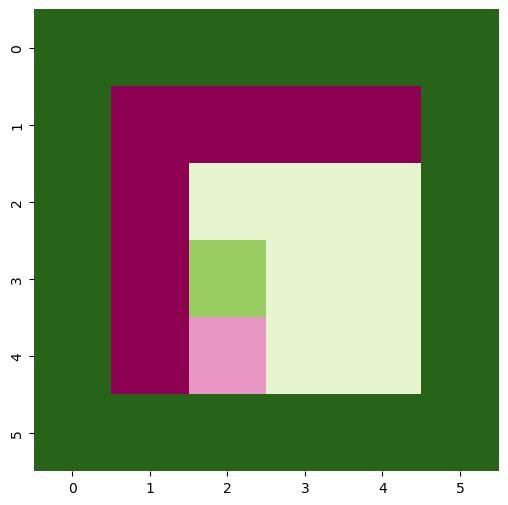

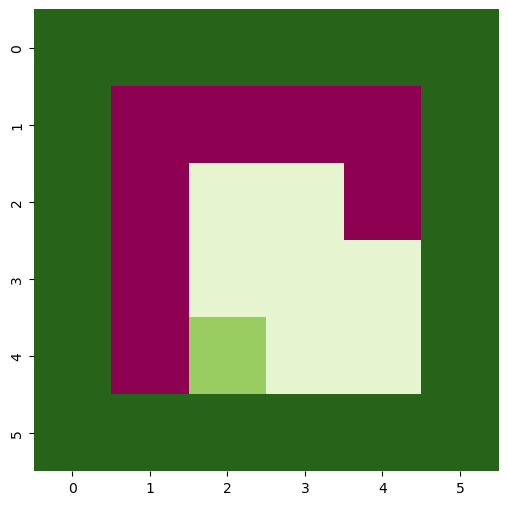

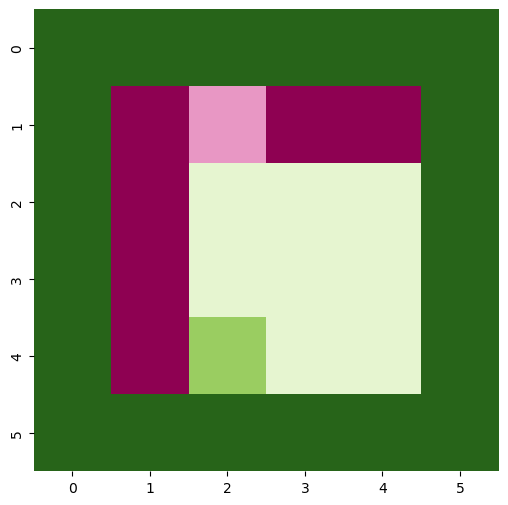

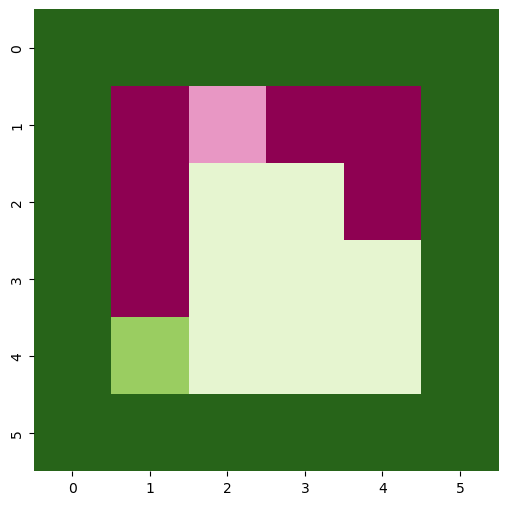

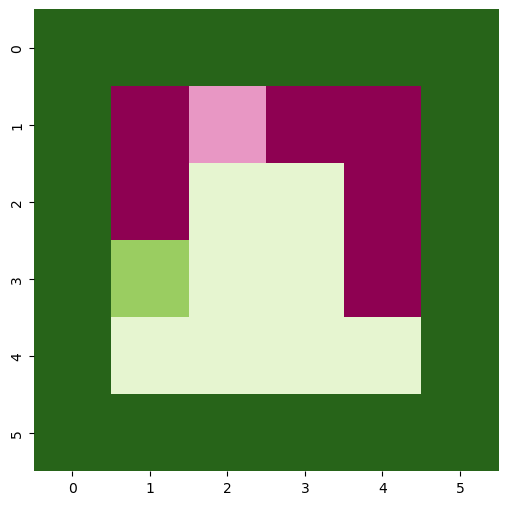

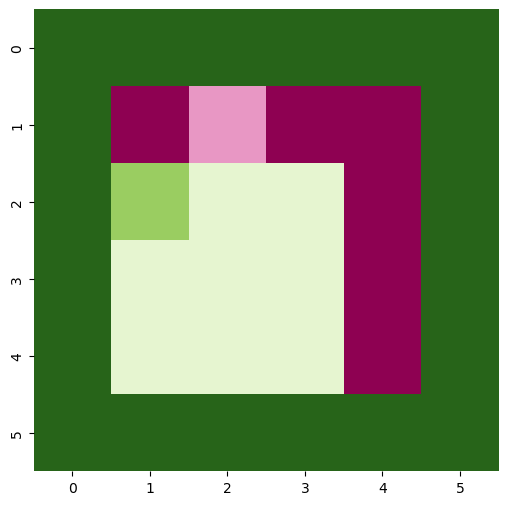

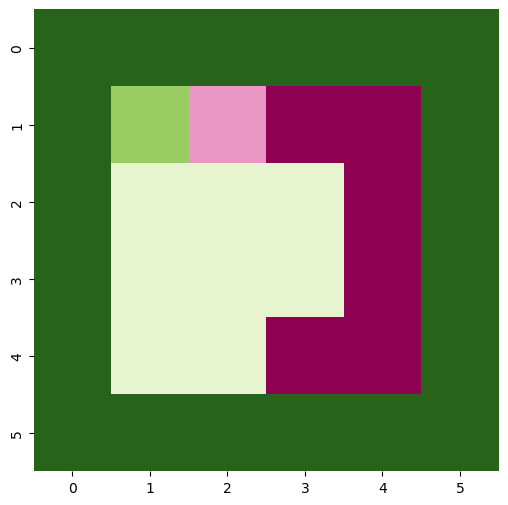

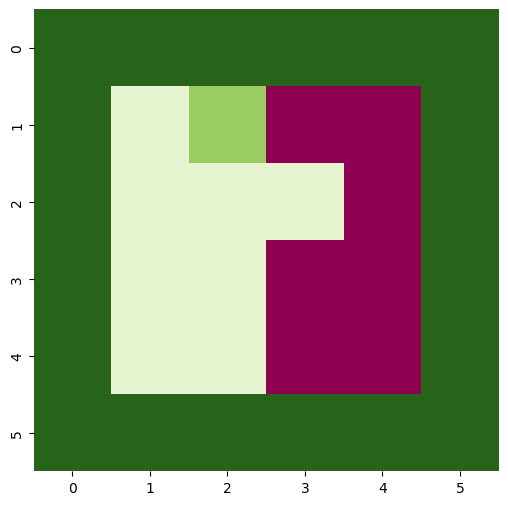

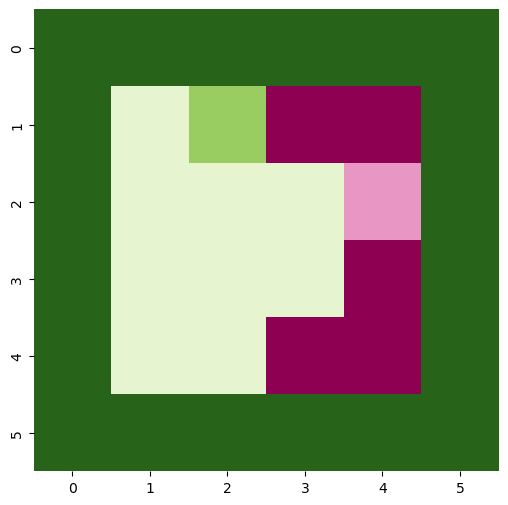

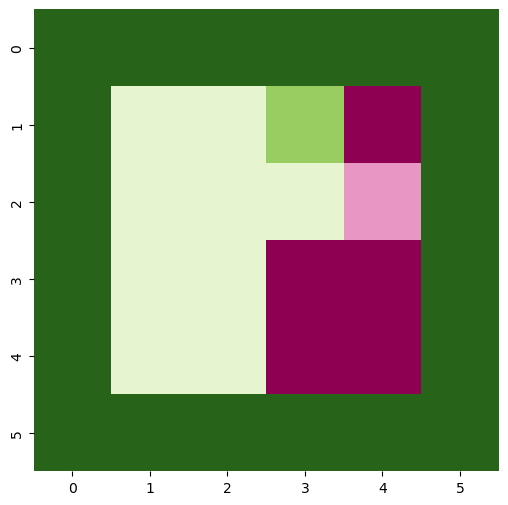

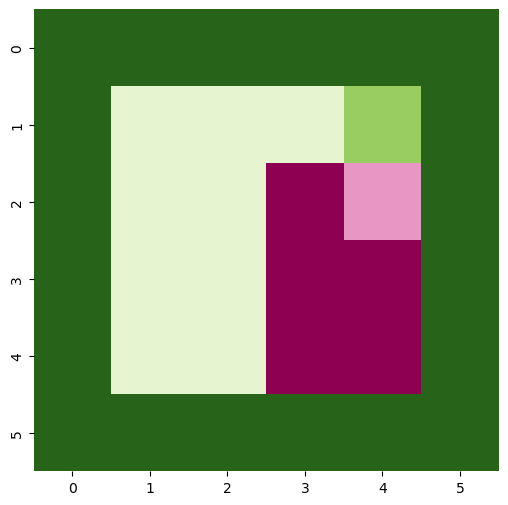

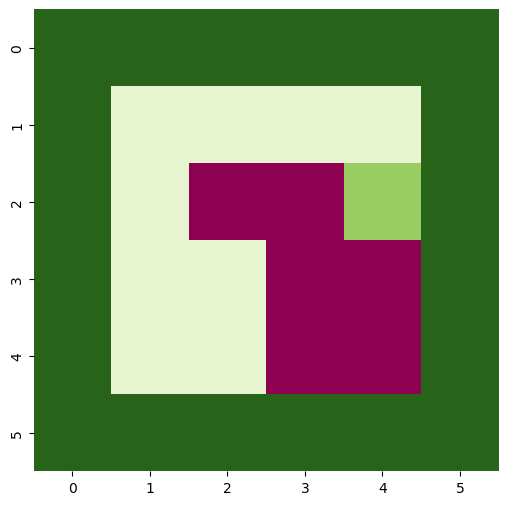

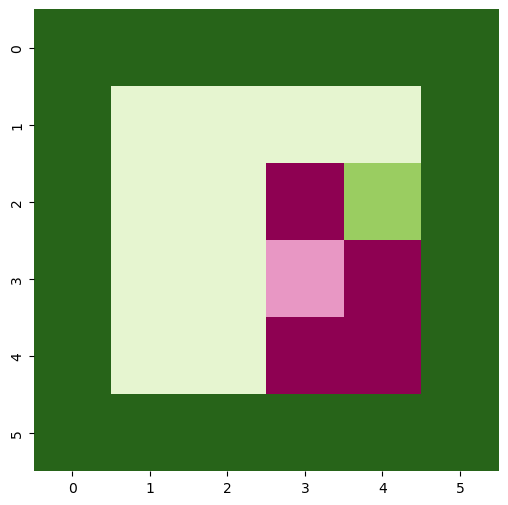

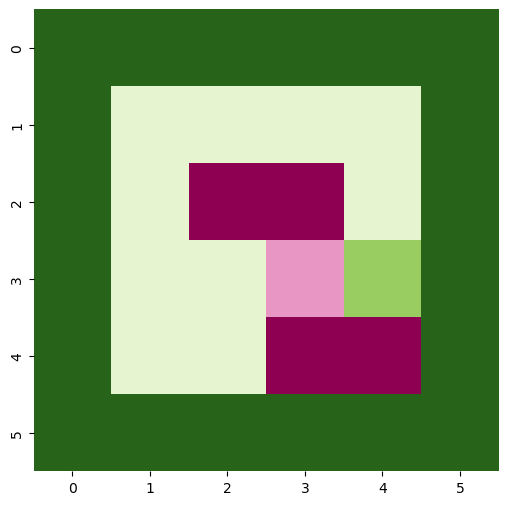

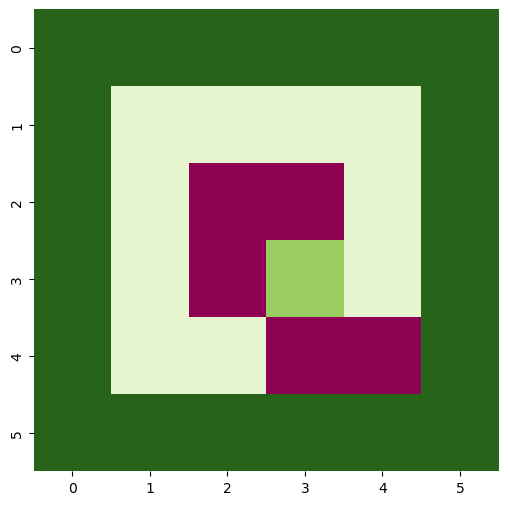

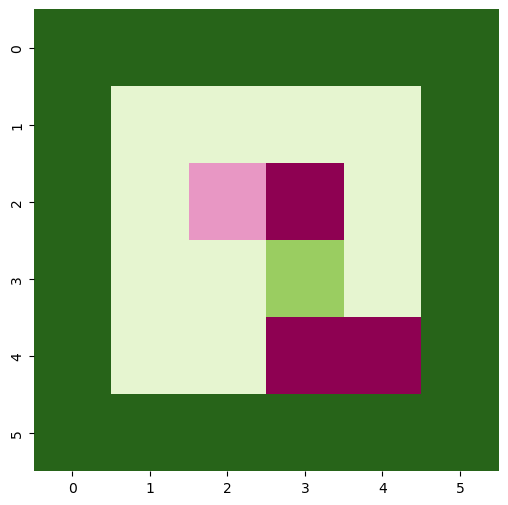

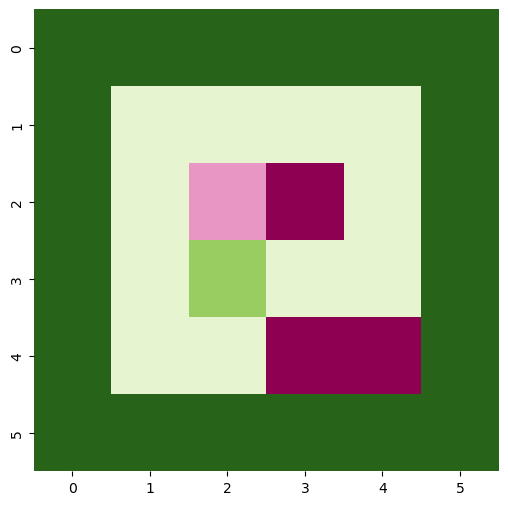

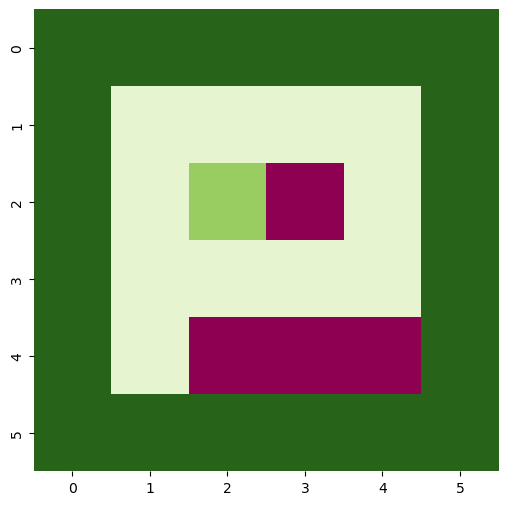

In [84]:
applySearch(iterative_deepening_search, "Iterative Deepening Search")

{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Greedy-Search (GS)

Total nodes in maze : 15
Total nodes visited : 3  |  20.0 %
Final path distance : 3

Path through the Maze : [(3, 3), (3, 2), (4, 2)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((

C:\Users\huang\AppData\Local\Temp\ipykernel_29308\3245365467.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize = (width,height))


{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1)], (2, 2): [((1, 2), 1), ((3, 2), 1)], (2, 3): [((1, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((3, 4), 1)], (3, 1): [((4, 1), 1), ((3, 2), 1)], (3, 2): [((4, 2), 1)], (3, 3): [((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((4, 4), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
Greedy-Search (GS)

Total nodes in maze : 9
Total nodes visited : 3  |  33.33 %
Final path distance : 3

Path through the Maze : [(3, 3), (3, 4), (2, 4)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1)], (2, 3): [((1,

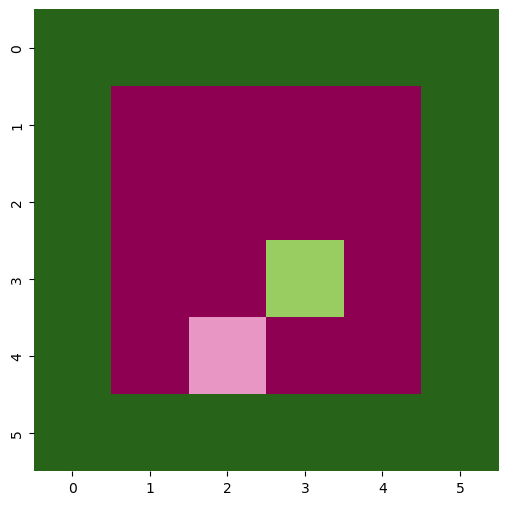

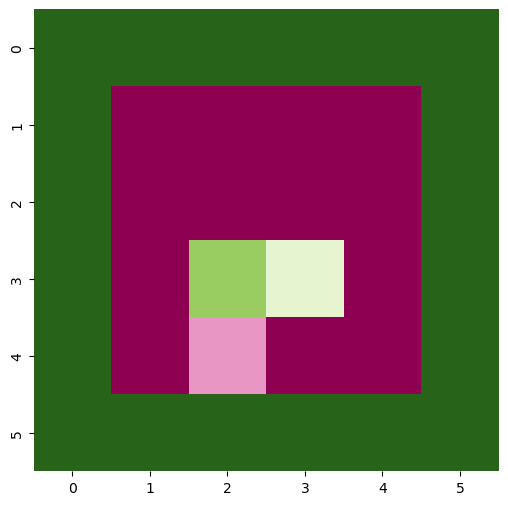

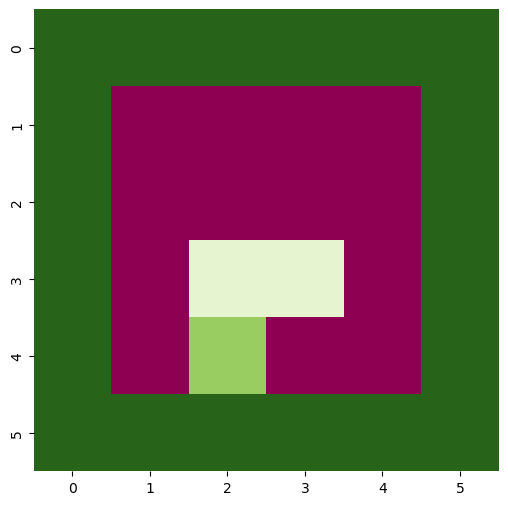

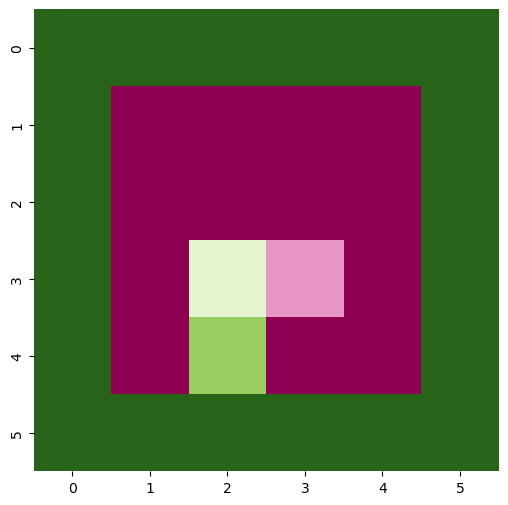

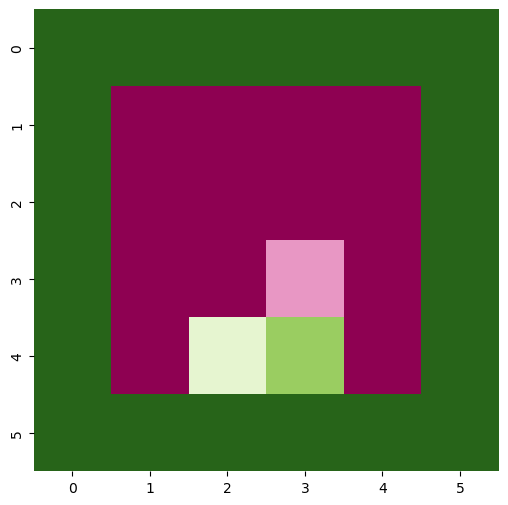

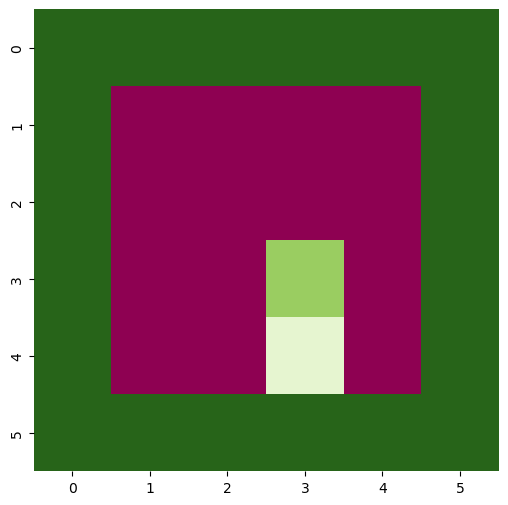

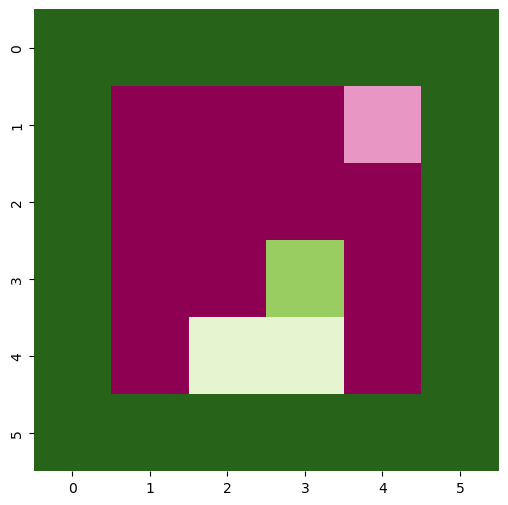

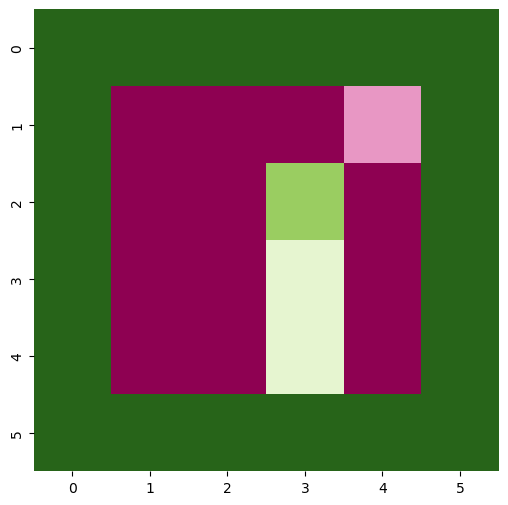

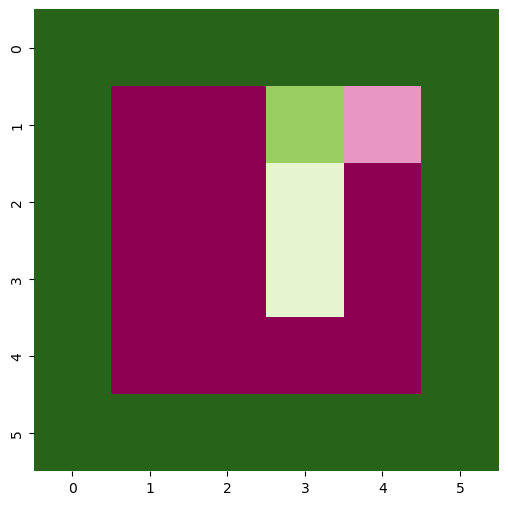

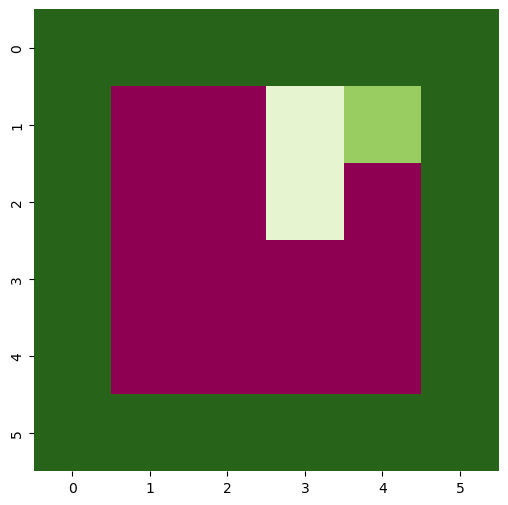

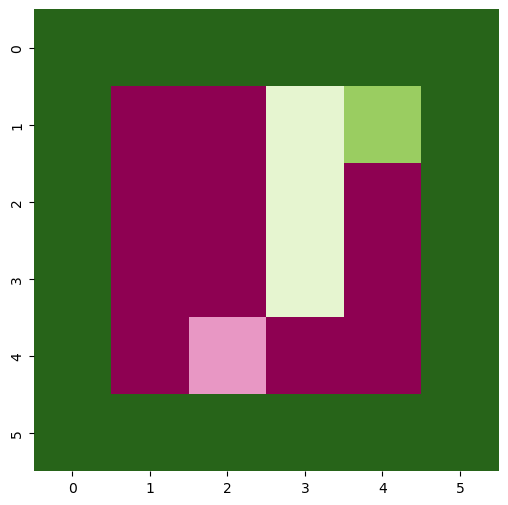

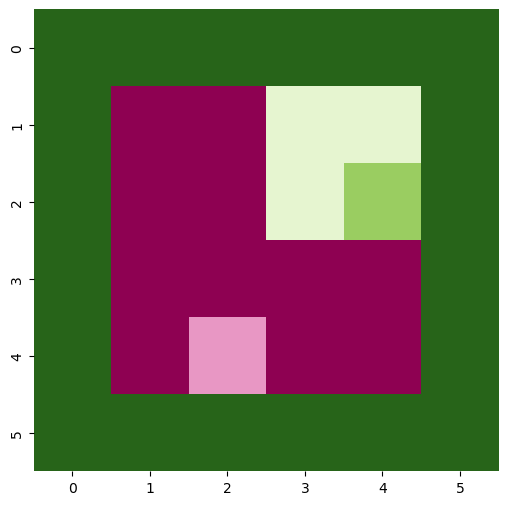

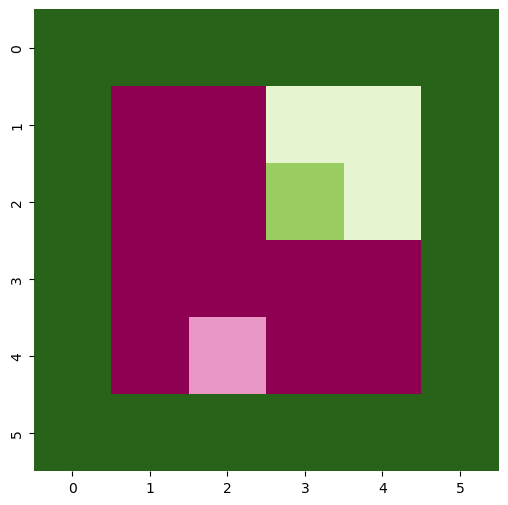

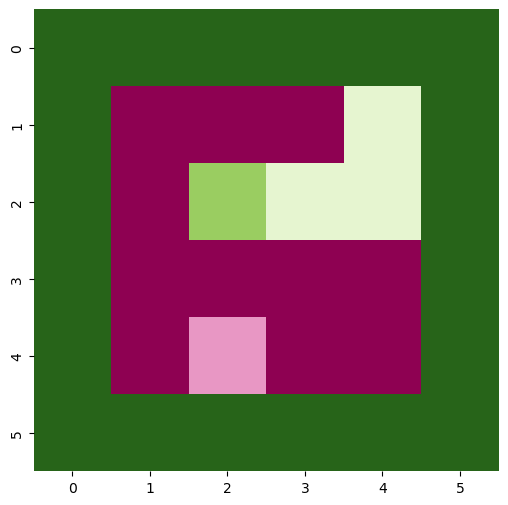

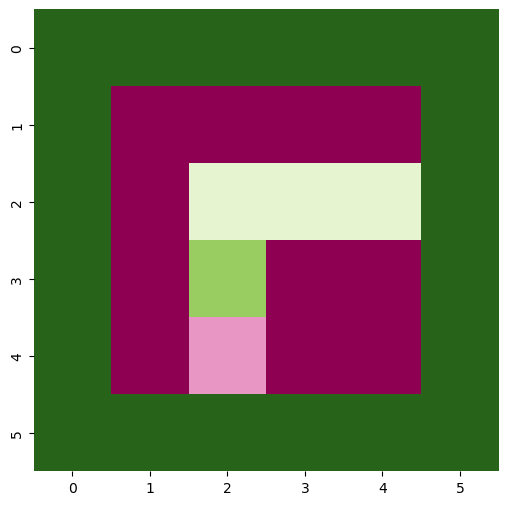

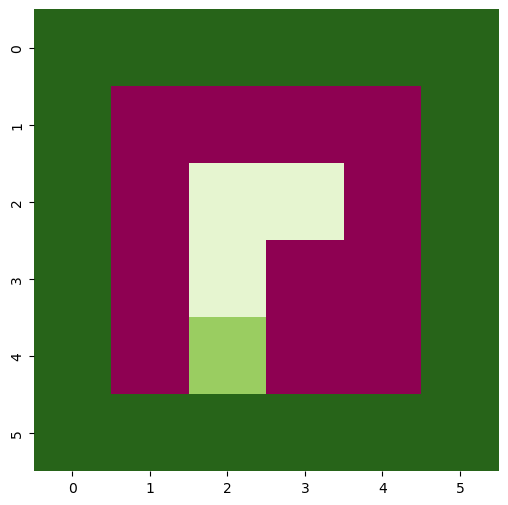

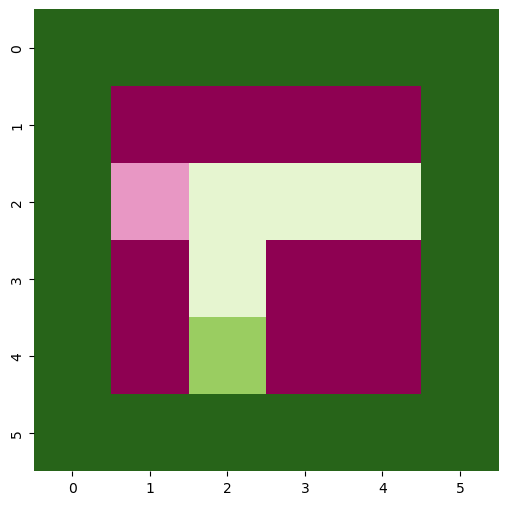

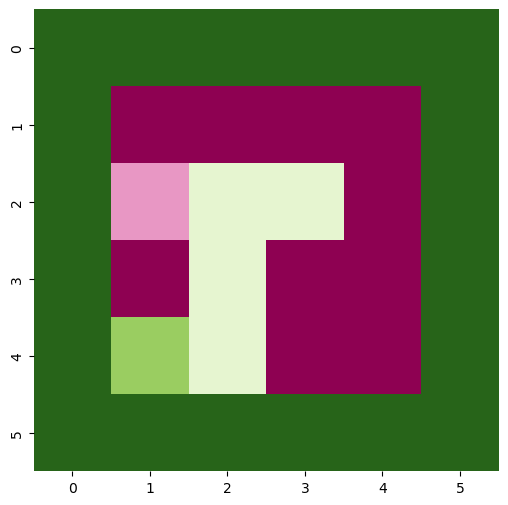

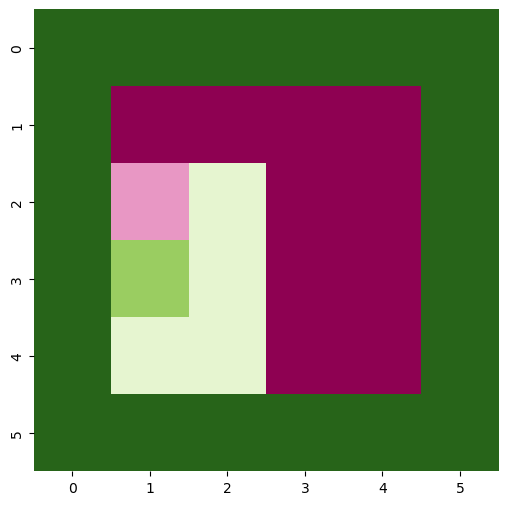

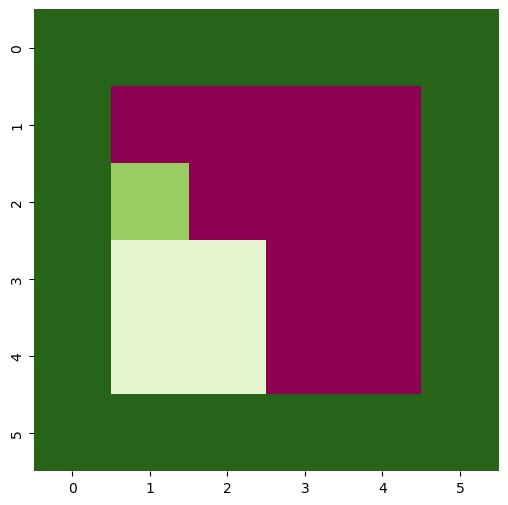

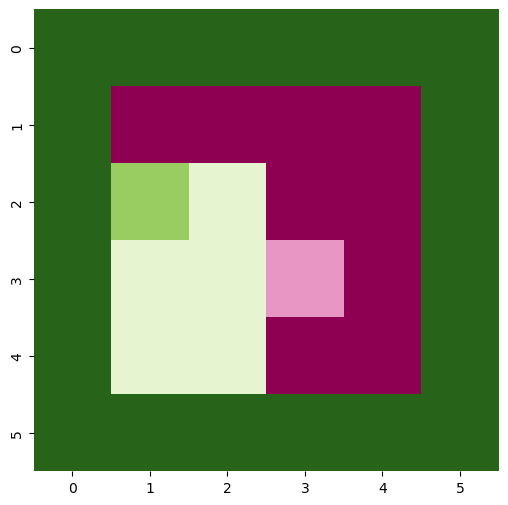

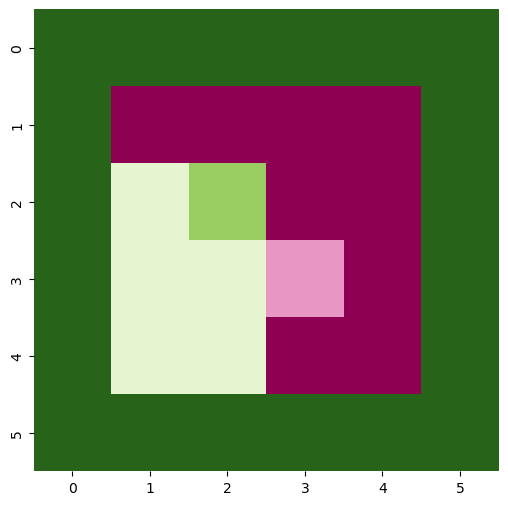

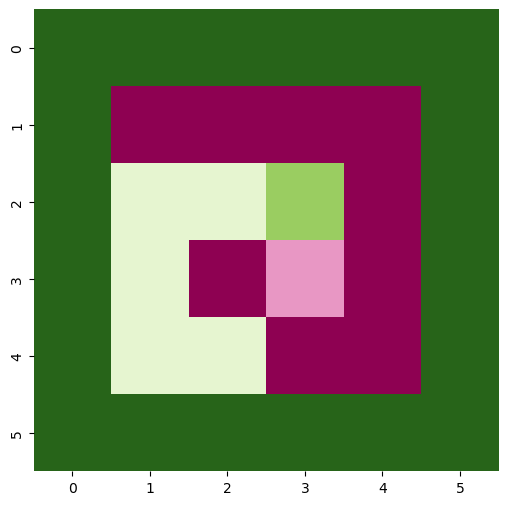

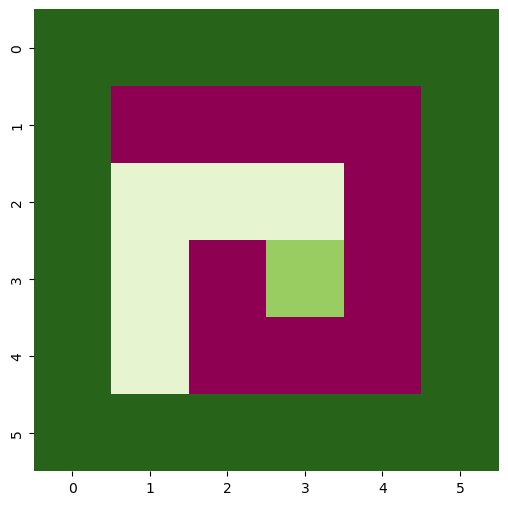

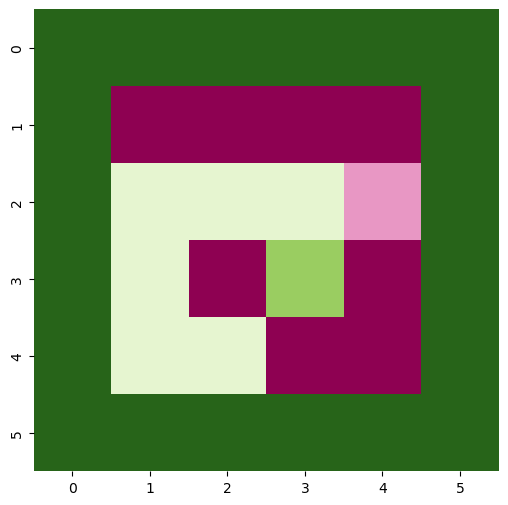

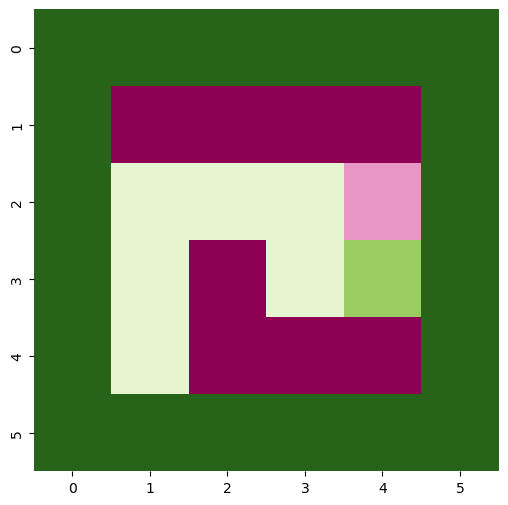

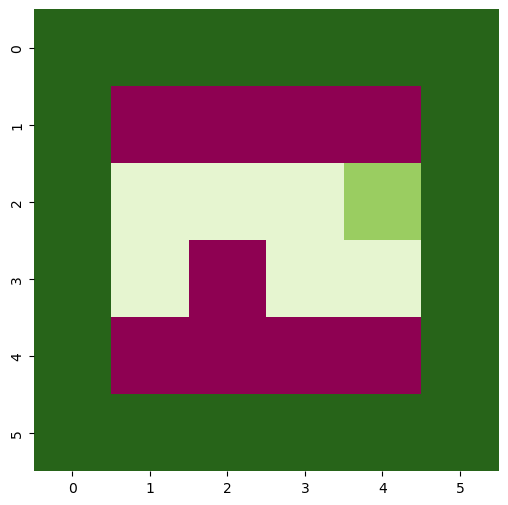

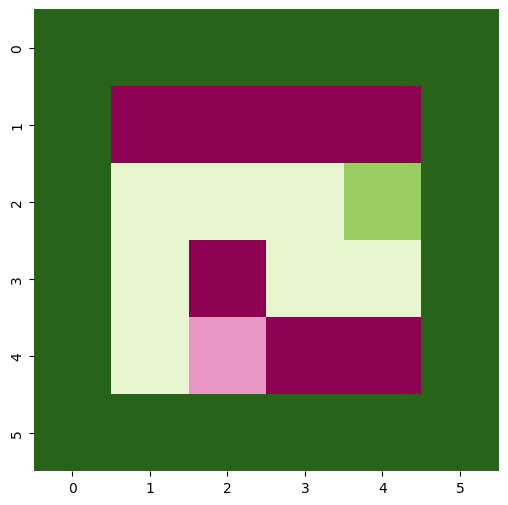

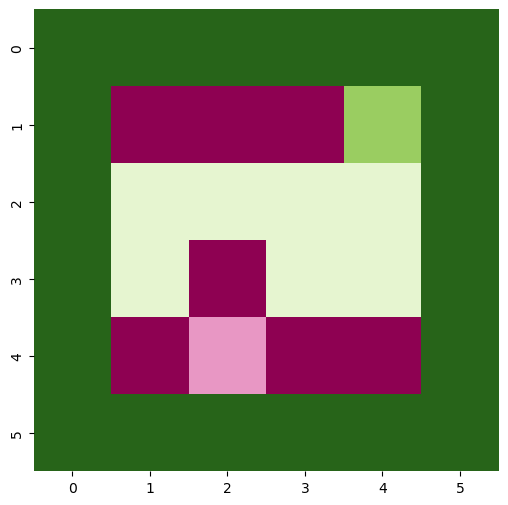

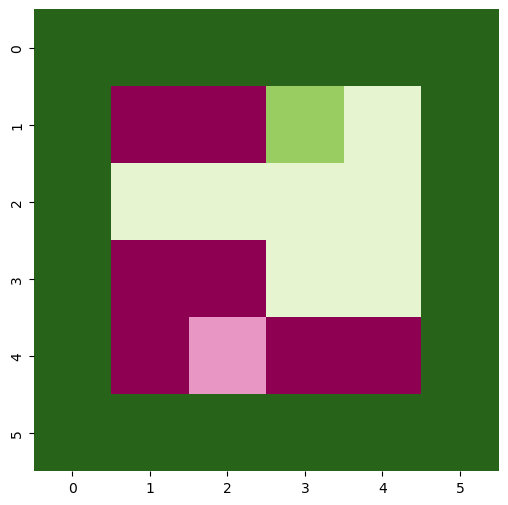

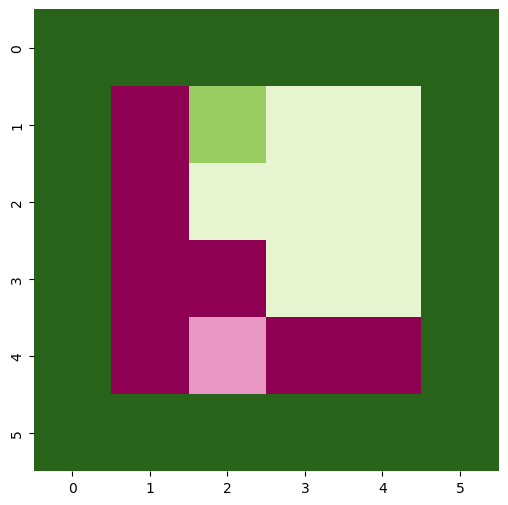

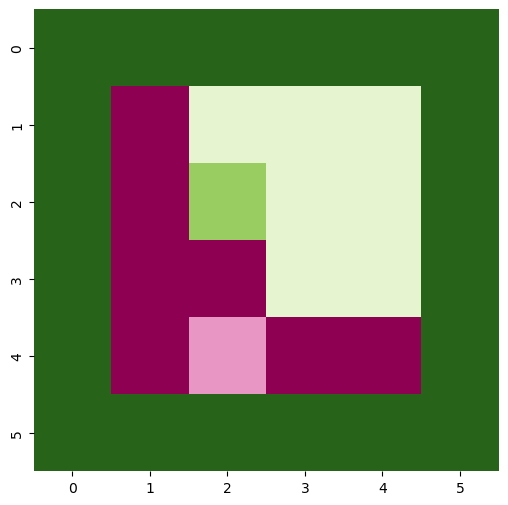

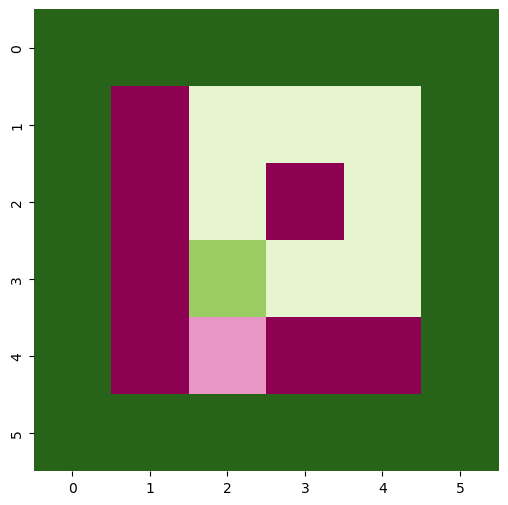

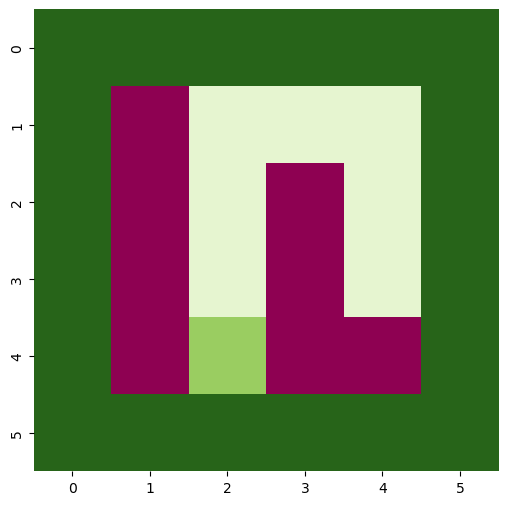

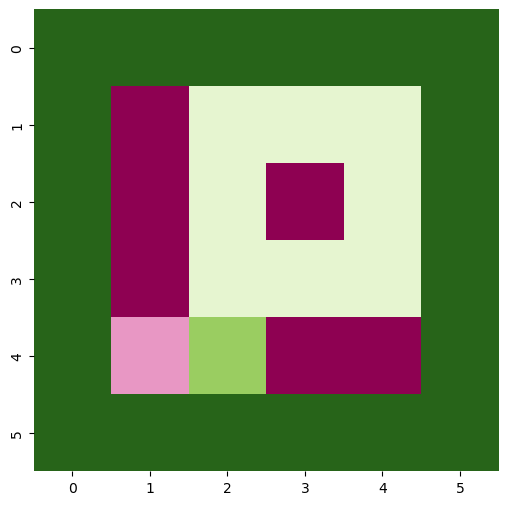

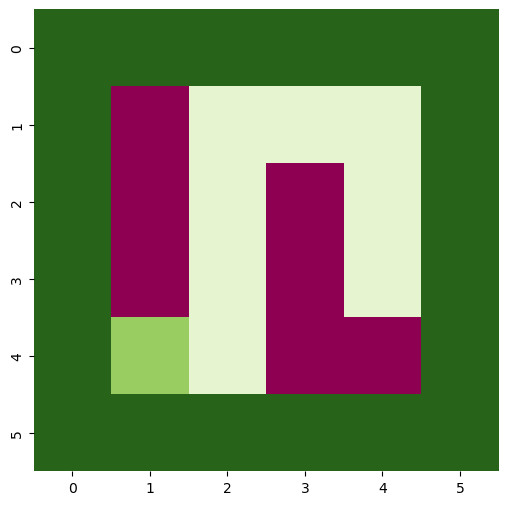

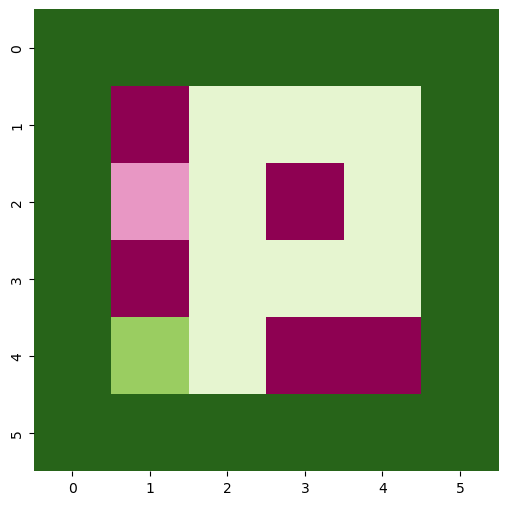

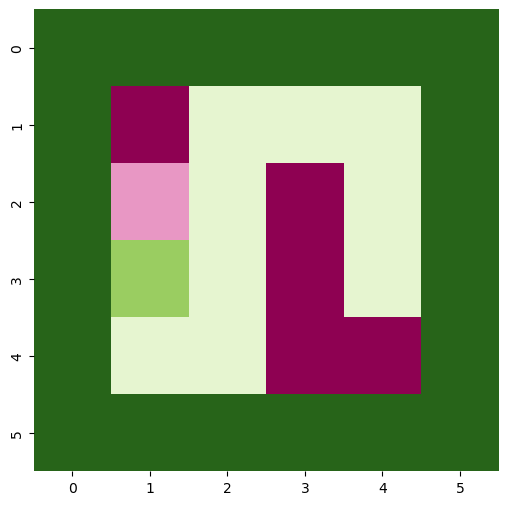

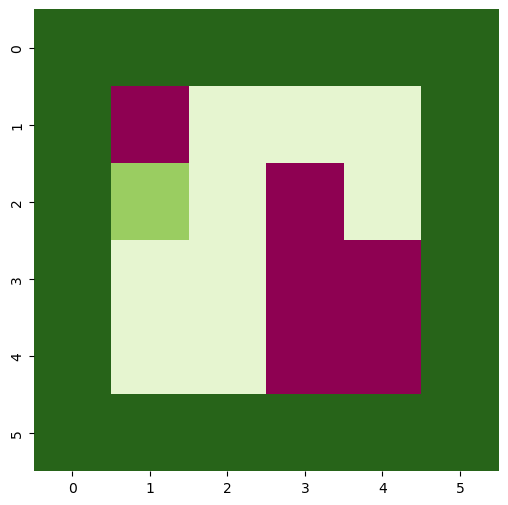

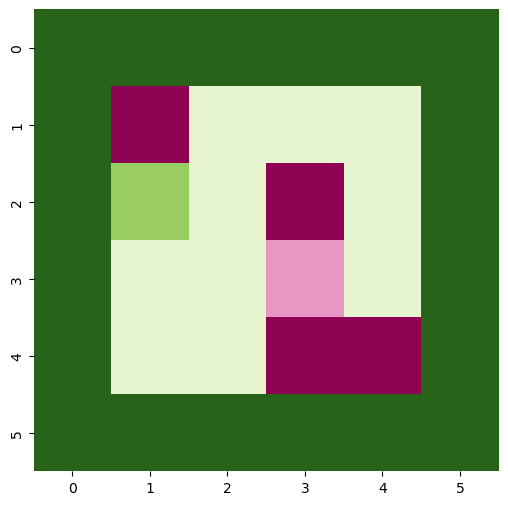

In [85]:
applySearch(greedy_search,"Greedy-Search (GS)")

{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)], (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)], (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((3, 1), 1), ((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
A*-Search (A*S)

Total nodes in maze : 15
Total nodes visited : 2  |  13.33 %
Final path distance : 2

Path through the Maze : [(3, 3), (3, 2)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1),

C:\Users\huang\AppData\Local\Temp\ipykernel_29308\3245365467.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize = (width,height))


{(1, 1): [((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2, 1): [((2, 2), 1)], (2, 2): [((1, 2), 1), ((3, 2), 1), ((2, 3), 1)], (2, 3): [((1, 3), 1), ((2, 2), 1), ((3, 3), 1), ((2, 4), 1)], (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)], (3, 1): [((3, 2), 1)], (3, 2): [((2, 2), 1), ((4, 2), 1), ((3, 3), 1)], (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)], (3, 4): [((2, 4), 1), ((3, 3), 1), ((4, 4), 1)], (4, 1): [((4, 2), 1)], (4, 2): [((3, 2), 1), ((4, 3), 1)], (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)], (4, 4): [((3, 4), 1), ((4, 3), 1)]}
A*-Search (A*S)

Total nodes in maze : 9
Total nodes visited : 4  |  44.44 %
Final path distance : 4

Path through the Maze : [(4, 1), (4, 2), (3, 2), (3, 3)]
{(1, 1): [((2, 1), 1), ((1, 2), 1)], (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)], (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)], (1, 4): [((1, 3), 1), ((2, 4), 1)], (2

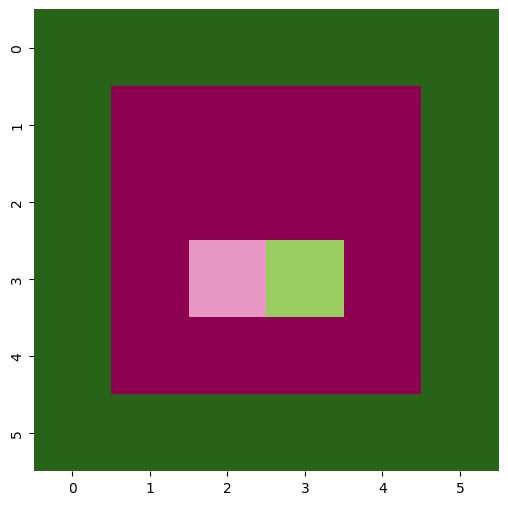

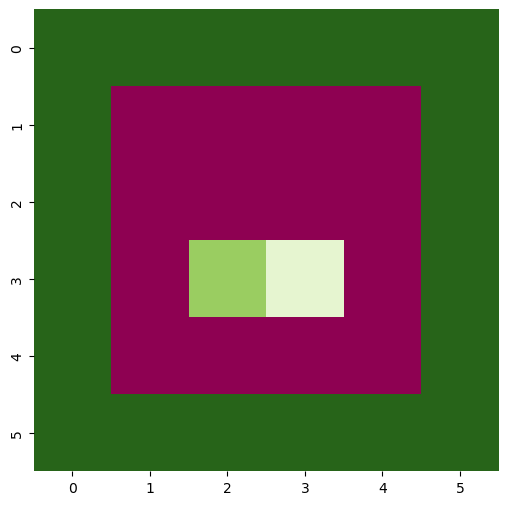

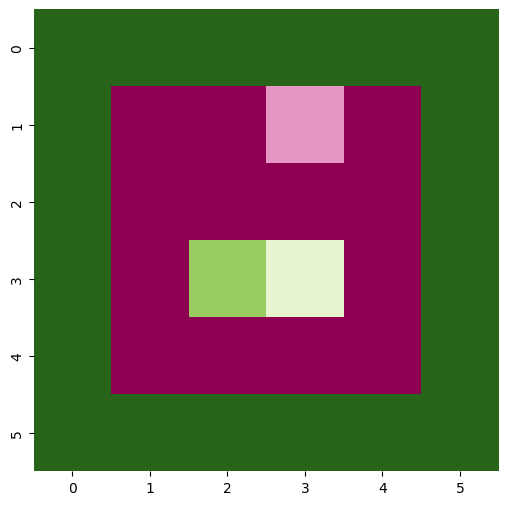

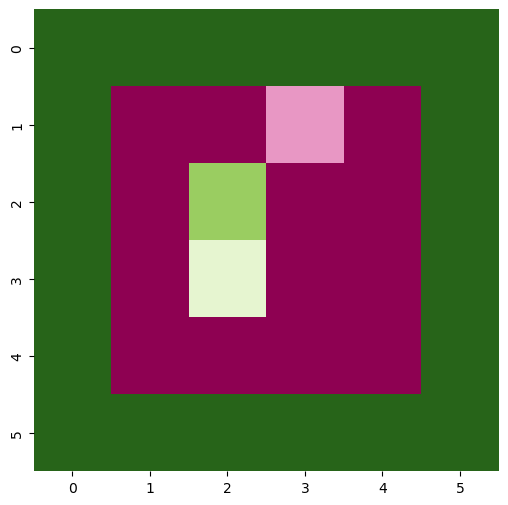

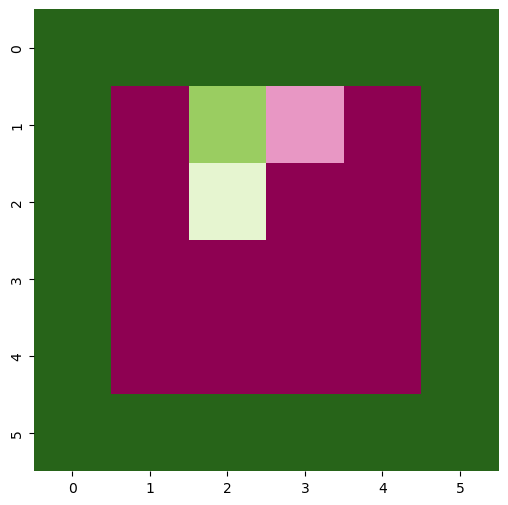

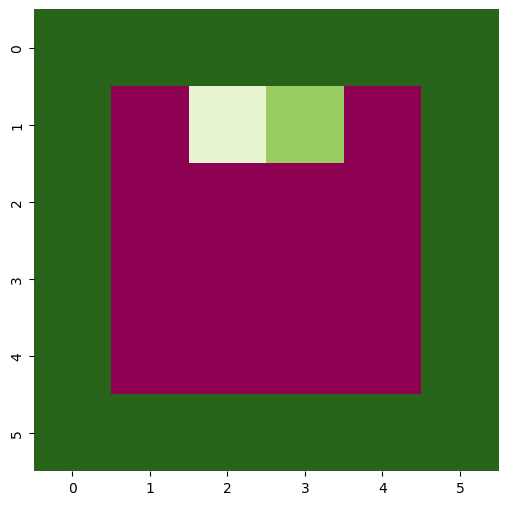

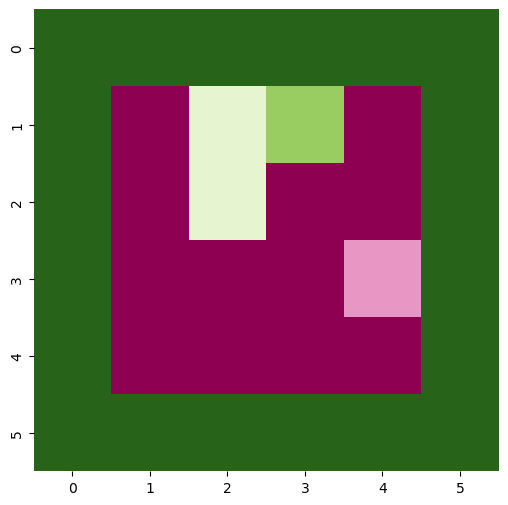

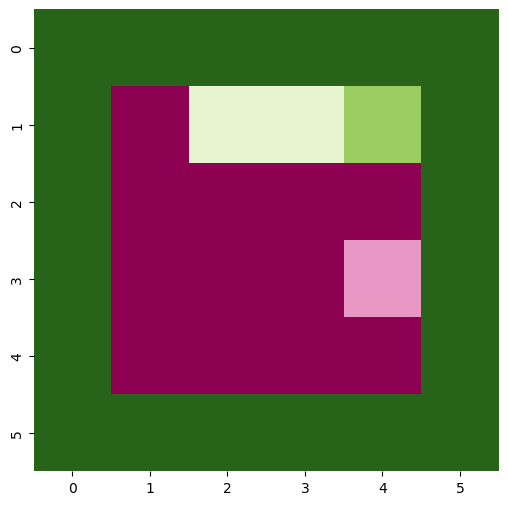

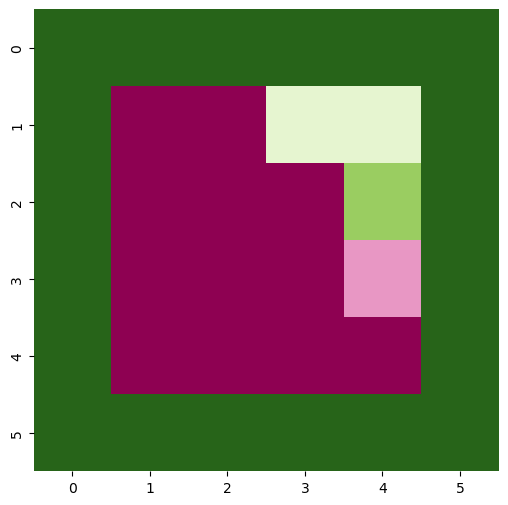

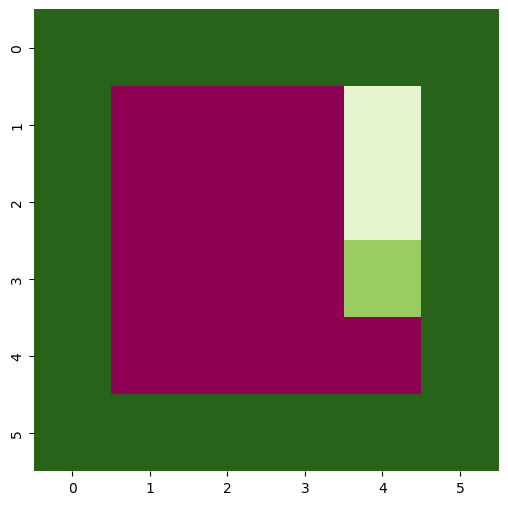

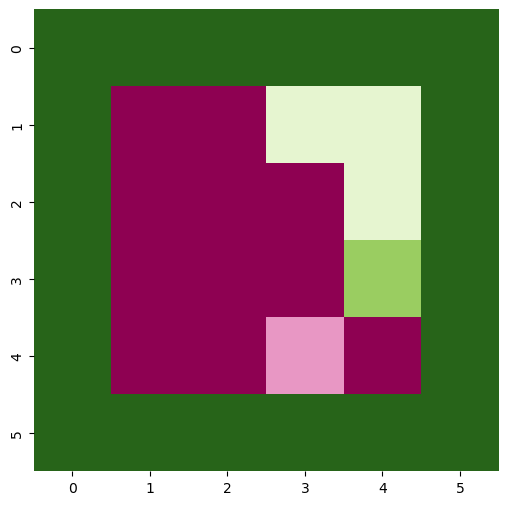

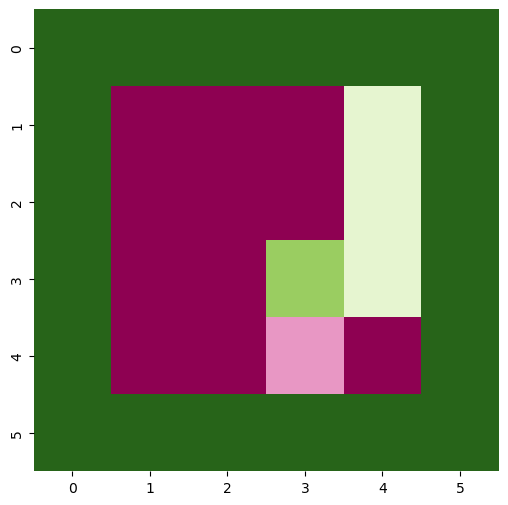

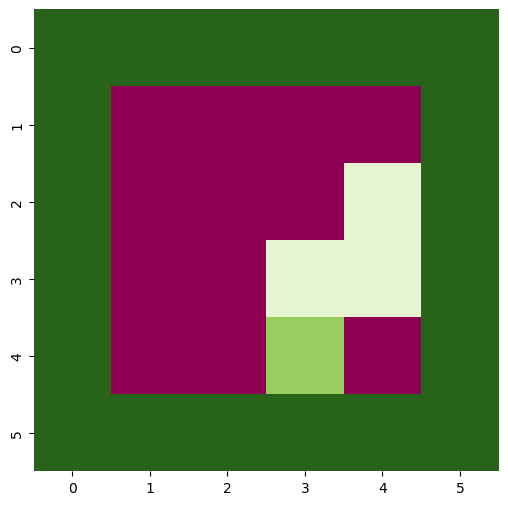

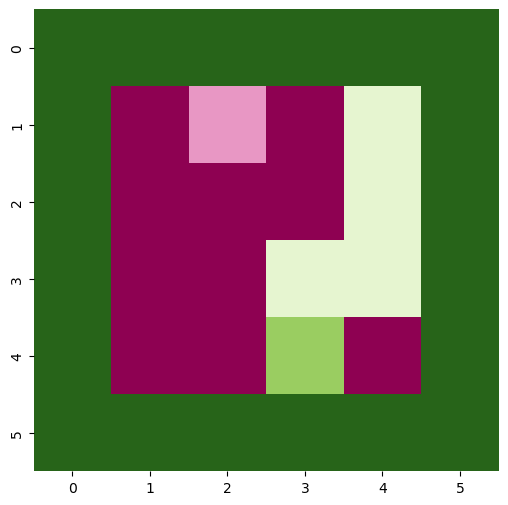

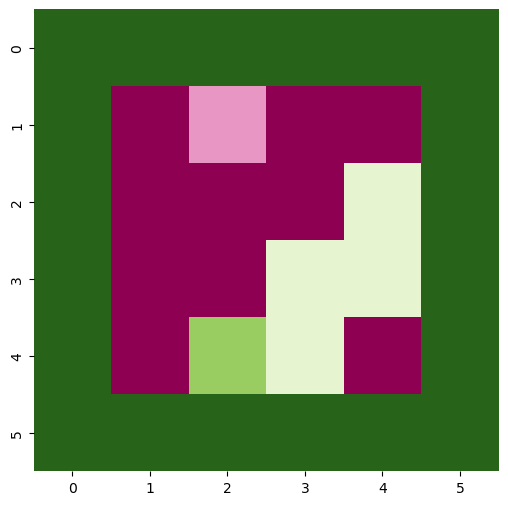

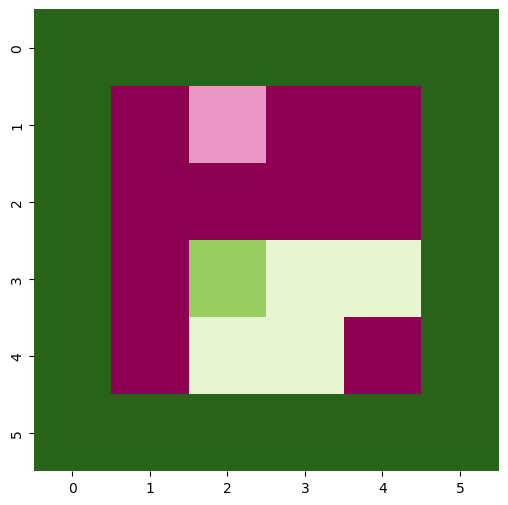

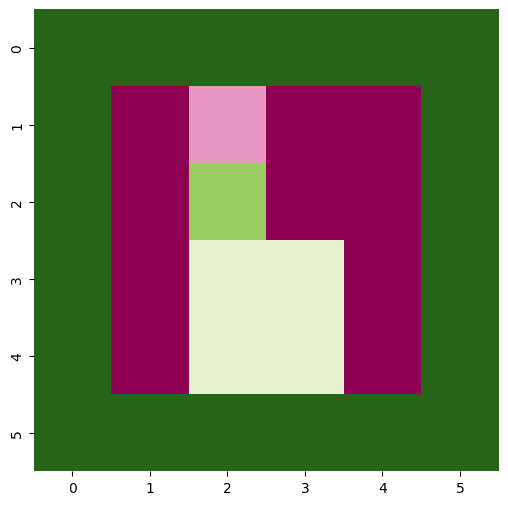

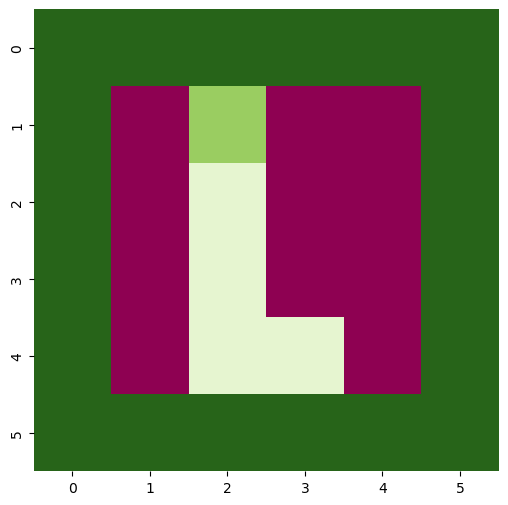

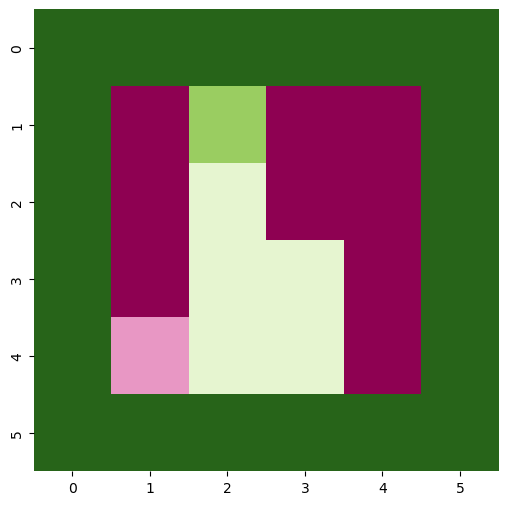

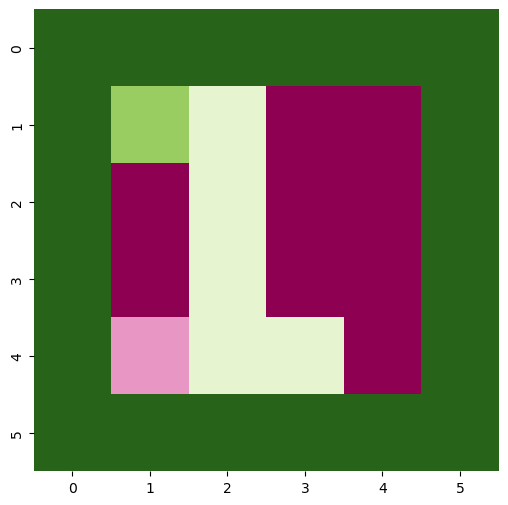

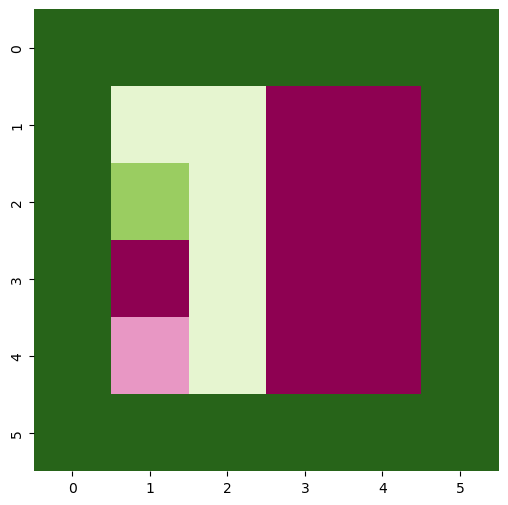

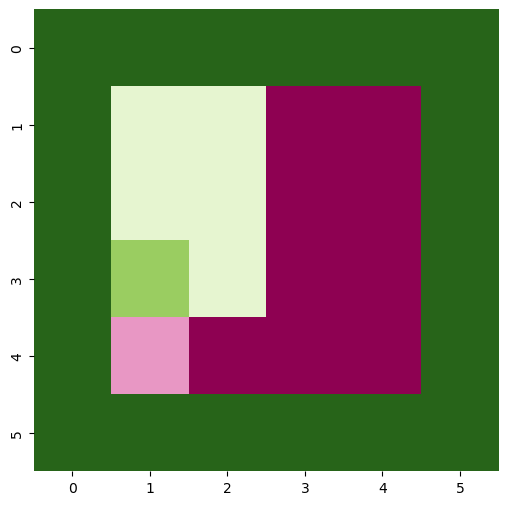

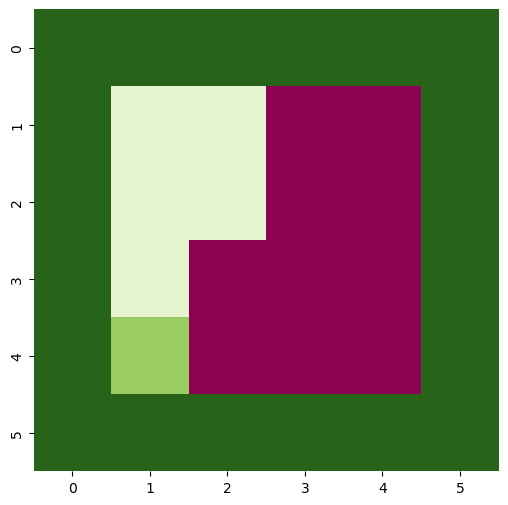

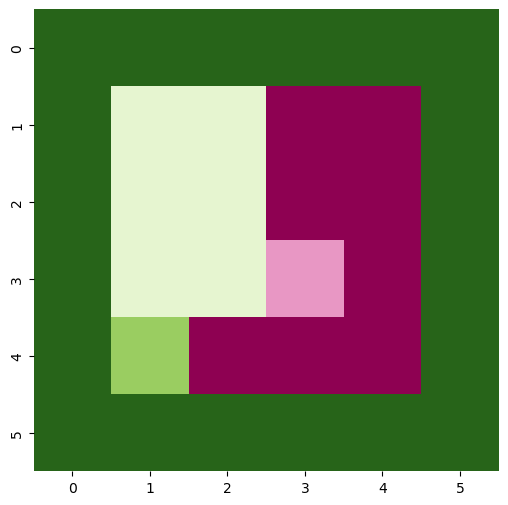

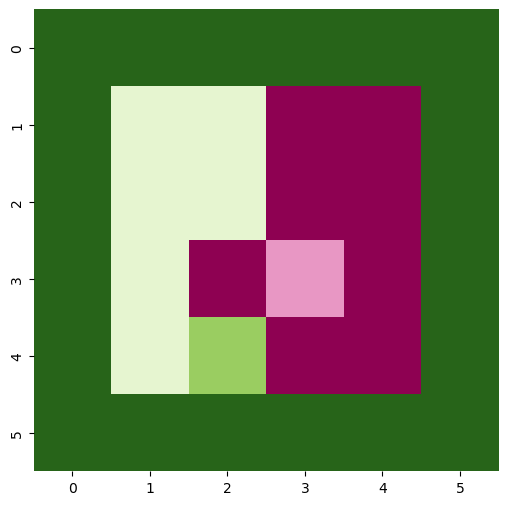

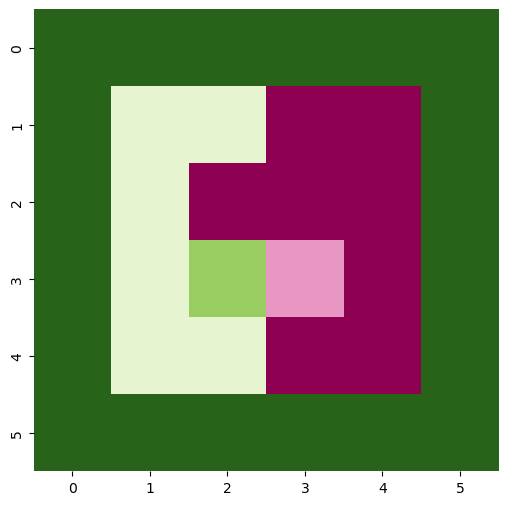

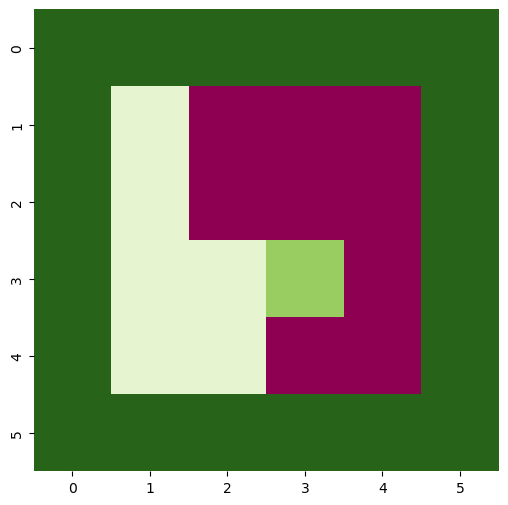

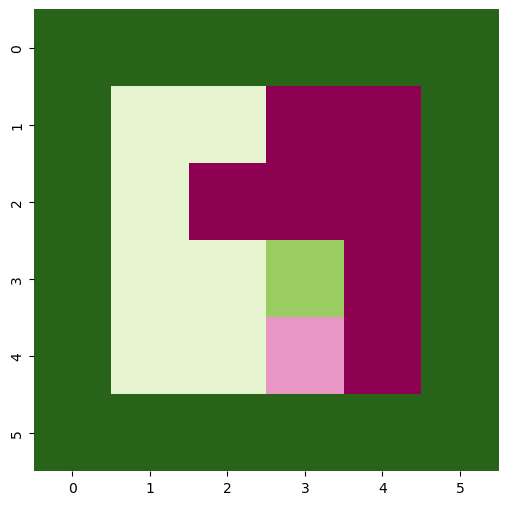

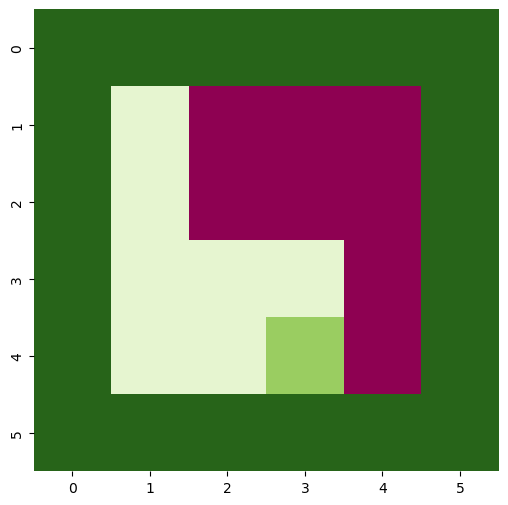

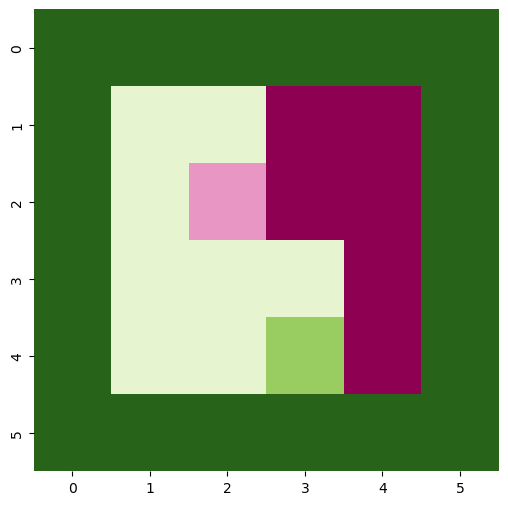

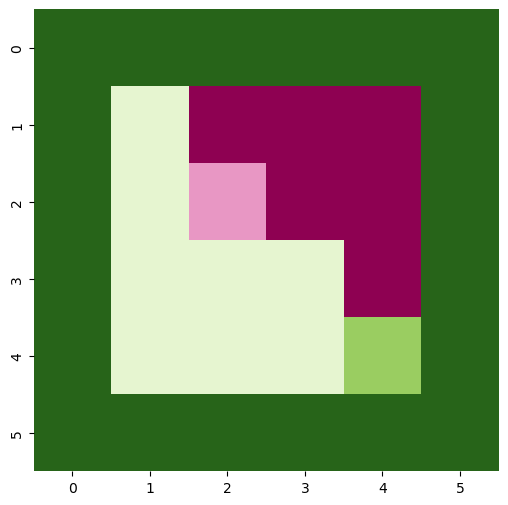

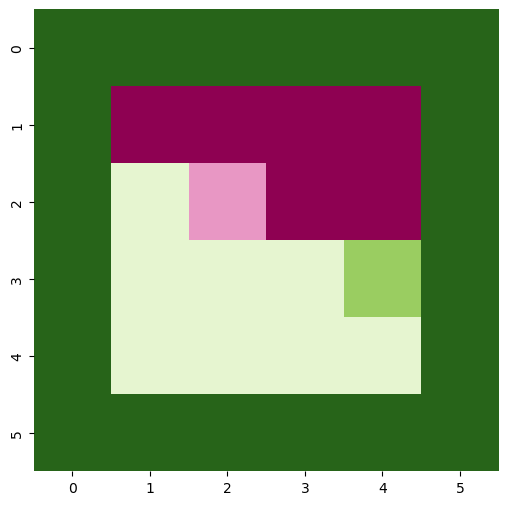

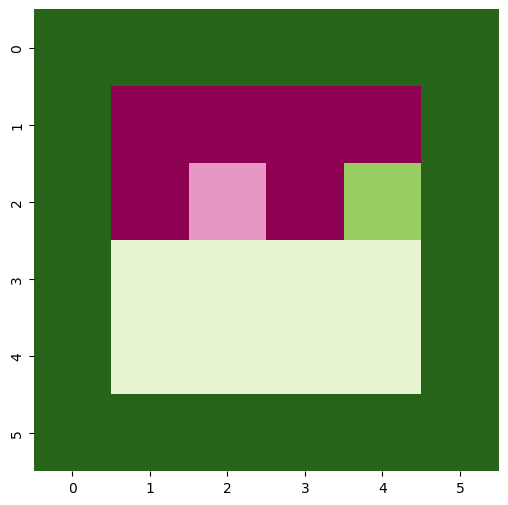

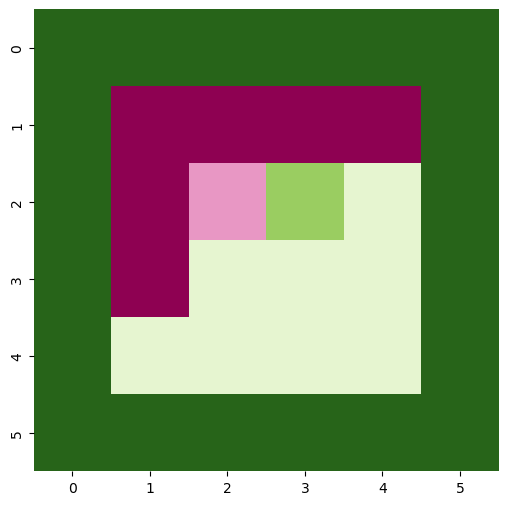

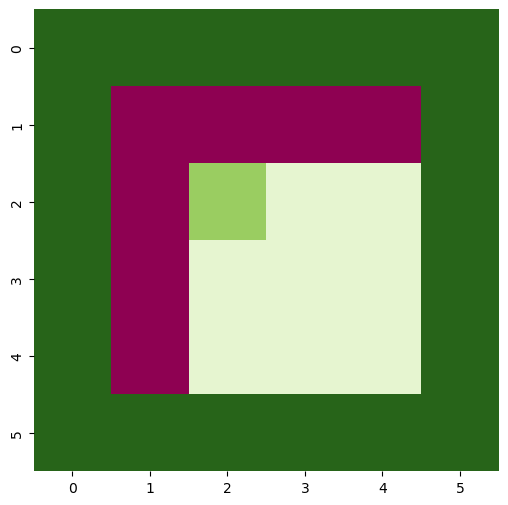

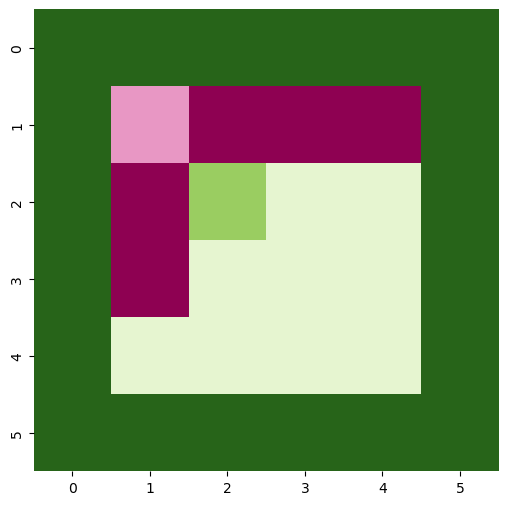

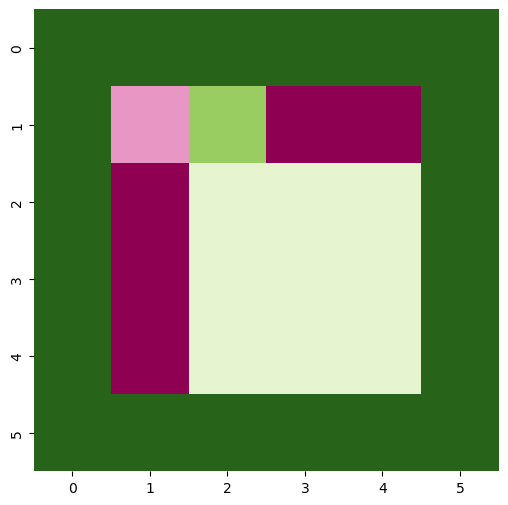

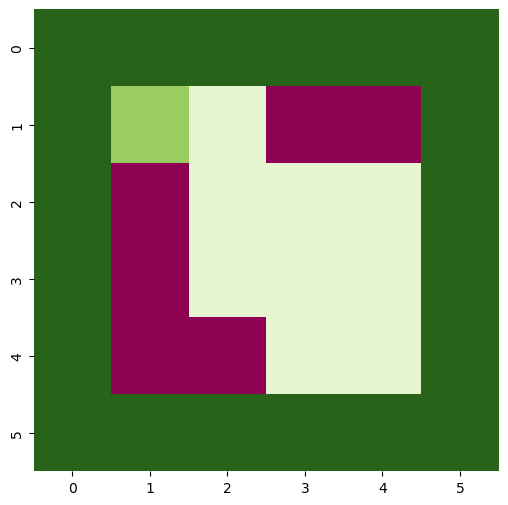

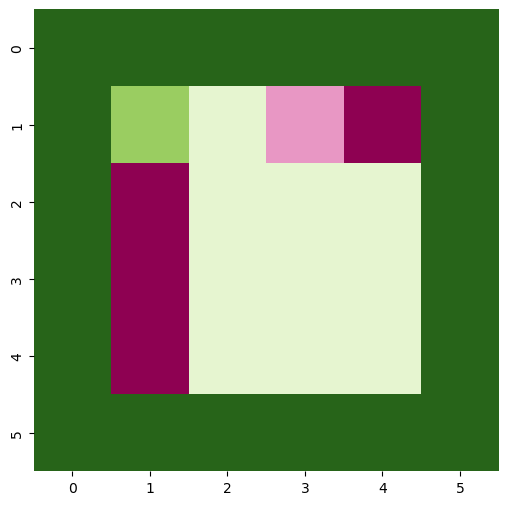

In [86]:
applySearch(astar_search,"A*-Search (A*S)")